# **Important Instructions**

**Please read before executing the notebook**

**1) This notebook is made for running in the Google Colab environment.**

**2) If planning to run the notebook in a an Anaconda environment on your local PC, please make sure that the cells relevant to Google Colab are commented out and that you create a new virtual environment and install all the required packages for running this code**

**3) I highly recommend using Colab as it does not require any manual changes to be made. If running on Anaconda, you will have to manually fix the bug in the descartes installation**

**4) Please make sure the other required Python notebooks and the python code for fetching COVID-19 data from the Open Data API are also available in the current working directory of the notebook**

**5)To use the Google Maps API to fetch the geocoding data, you will have to create a Google cloud account and set up an API and an access key. The access key should be copied and pasted on the origin-destination-matrix.ipynb notebook.**


# 1. Import standard and other required specialised Python packages

## 1.1. Install the required packages in Google Colab

In [1]:
!pip install shapely
!pip install descartes
!pip install geopandas
!pip install networkx
!pip install osmnx
!pip install contextily
!pip install rasterio
!pip install lmfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 6.8 MB/s eta 0:00:00


In [2]:
import os
#Print current working directory
os.getcwd()

'/content'

In [3]:
!python --version

Python 3.10.12


In [4]:
!pip list -v | grep [Dd]escartes

descartes                        1.1.0                 /usr/local/lib/python3.10/dist-packages pip


Verify the location of the descartes installation and check for 'patch.py' file in the folder

In [5]:
!ls '/usr/local/lib/python3.10/dist-packages/descartes'

__init__.py  patch.py  __pycache__  tests.py


### **The descartes module installed using conda or the pip package managers have an inherent error in the patch.py file in the installation directory for the package. We need to fix this error by calling the 'coords' attribute in the t.exterior call.**

More details and solution available in the link: https://stackoverflow.com/questions/75287534/indexerror-descartes-polygonpatch-wtih-shapely

The below script will take care of this issue.

In [6]:
#Location of 'patch.py' file in the descartes installation.
file_path = '/usr/local/lib/python3.10/dist-packages/descartes/patch.py'

replace_status_flag = 0

# Read the file contents
with open(file_path, 'r') as file:
    lines = file.readlines()

# Check all the lines if they contain the target code
target_code = """concatenate([asarray(t.exterior)[:, :2]]"""
for i in range(len(lines)):
  #print(f"{i}: {lines[i]}")
  if target_code in lines[i]:
      # Replace the code
      replace_status_flag = 1
      lines[i] = lines[i].replace("t.exterior", "t.exterior.coords")

      # Write the modified contents back to the file
      with open(file_path, 'w') as file:
          file.writelines(lines)
      print("File modified successfully!")

if not(replace_status_flag):
  print("Target text not found.")

File modified successfully!


Mount google drive location and change current working directory to the Project folder

In [7]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Dissertation/')

Mounted at /content/drive


In [8]:
#Standard and specialised module imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, shape, box
import geopandas as gpd
import seaborn as sns
import warnings
from datetime import datetime as dt
from pathlib import Path
import rasterio as rio
from shapely import wkt
from rasterio.mask import mask
from rasterio import features
import contextily as ctx
from geopy.geocoders import Nominatim, GoogleV3
from shapely.ops import unary_union
import networkx as nx
from collections import namedtuple
from scipy.integrate import odeint
import datetime
from requests import get
from scipy.optimize import minimize
from covid_19_numbers import fn_generateSEIRHD_data, fn_get_COVID19_London_data
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
from lmfit import minimize, Parameters
from lmfit import report_fit
from scipy.optimize import curve_fit
import random
import tensorflow as tf
from matplotlib.ticker import FuncFormatter

In [9]:
#Set random seed so that results can be duplicated
random.seed(260758)

# 2. Import the map of required city from OpenStreetMaps

epsg:4326
+proj=utm +zone=30 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


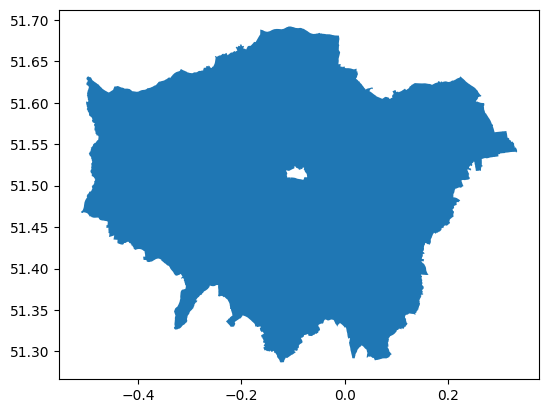

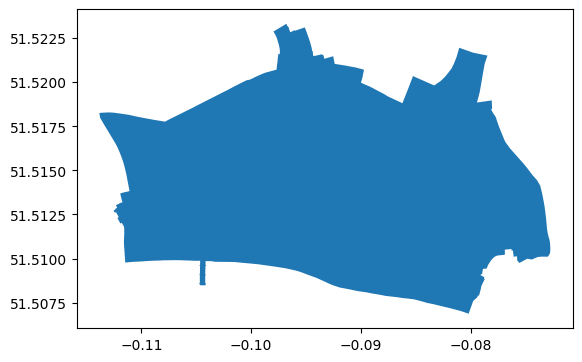

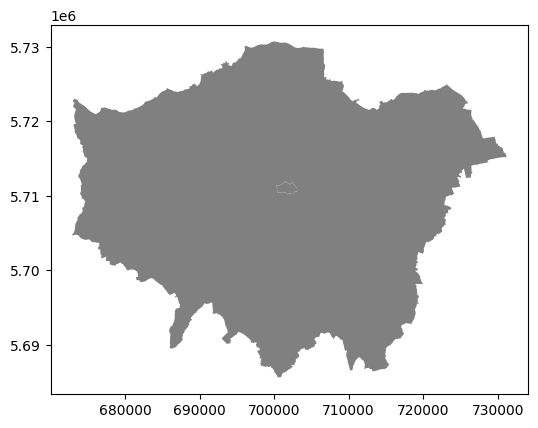

In [10]:
#Load Lonndon city from openstreetmap using osmnx api
london = ox.geocode_to_gdf("London, UK", which_result=1)
london.plot()

city_of_london = ox.geocode_to_gdf("City of London, UK", which_result=1)
city_of_london.plot()

#Concatenate the London Region and the City of London to form single GeoDataFrame.
city = pd.concat([london, city_of_london])
print(city.crs)
city = ox.project_gdf(city)
ax = city.plot(fc='grey', ec='none')
#_ = ax.axis('off')
print(city.crs)

## 2.1. Save the geographical information as a shapefile

In [11]:
city.to_file('LONDON_shapefile.shp', driver='ESRI Shapefile')

<ipython-input-11-634642bf76d4>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  city.to_file('LONDON_shapefile.shp', driver='ESRI Shapefile')


In [12]:
london_geometry = unary_union([city['geometry'].iloc[0], city['geometry'].iloc[1]])
print(type(london_geometry))

<class 'shapely.geometry.polygon.Polygon'>


## 2.2. Split the city into equal square grids of any width (12km x 12km)

In [13]:
geometry_grids_split = ox.utils_geo._quadrat_cut_geometry(london_geometry, quadrat_width=12000)
print(type(geometry_grids_split))

<class 'shapely.geometry.multipolygon.MultiPolygon'>


In [14]:
print(geometry_grids_split.geoms[0].representative_point().coords[:][0])

(680537.3914519881, 5703207.925333559)


## 2.3. Assign ID's to each grid and plot the city

(672920.2076624214, 731187.6705769316, 5685642.414560587, 5730734.648360872)

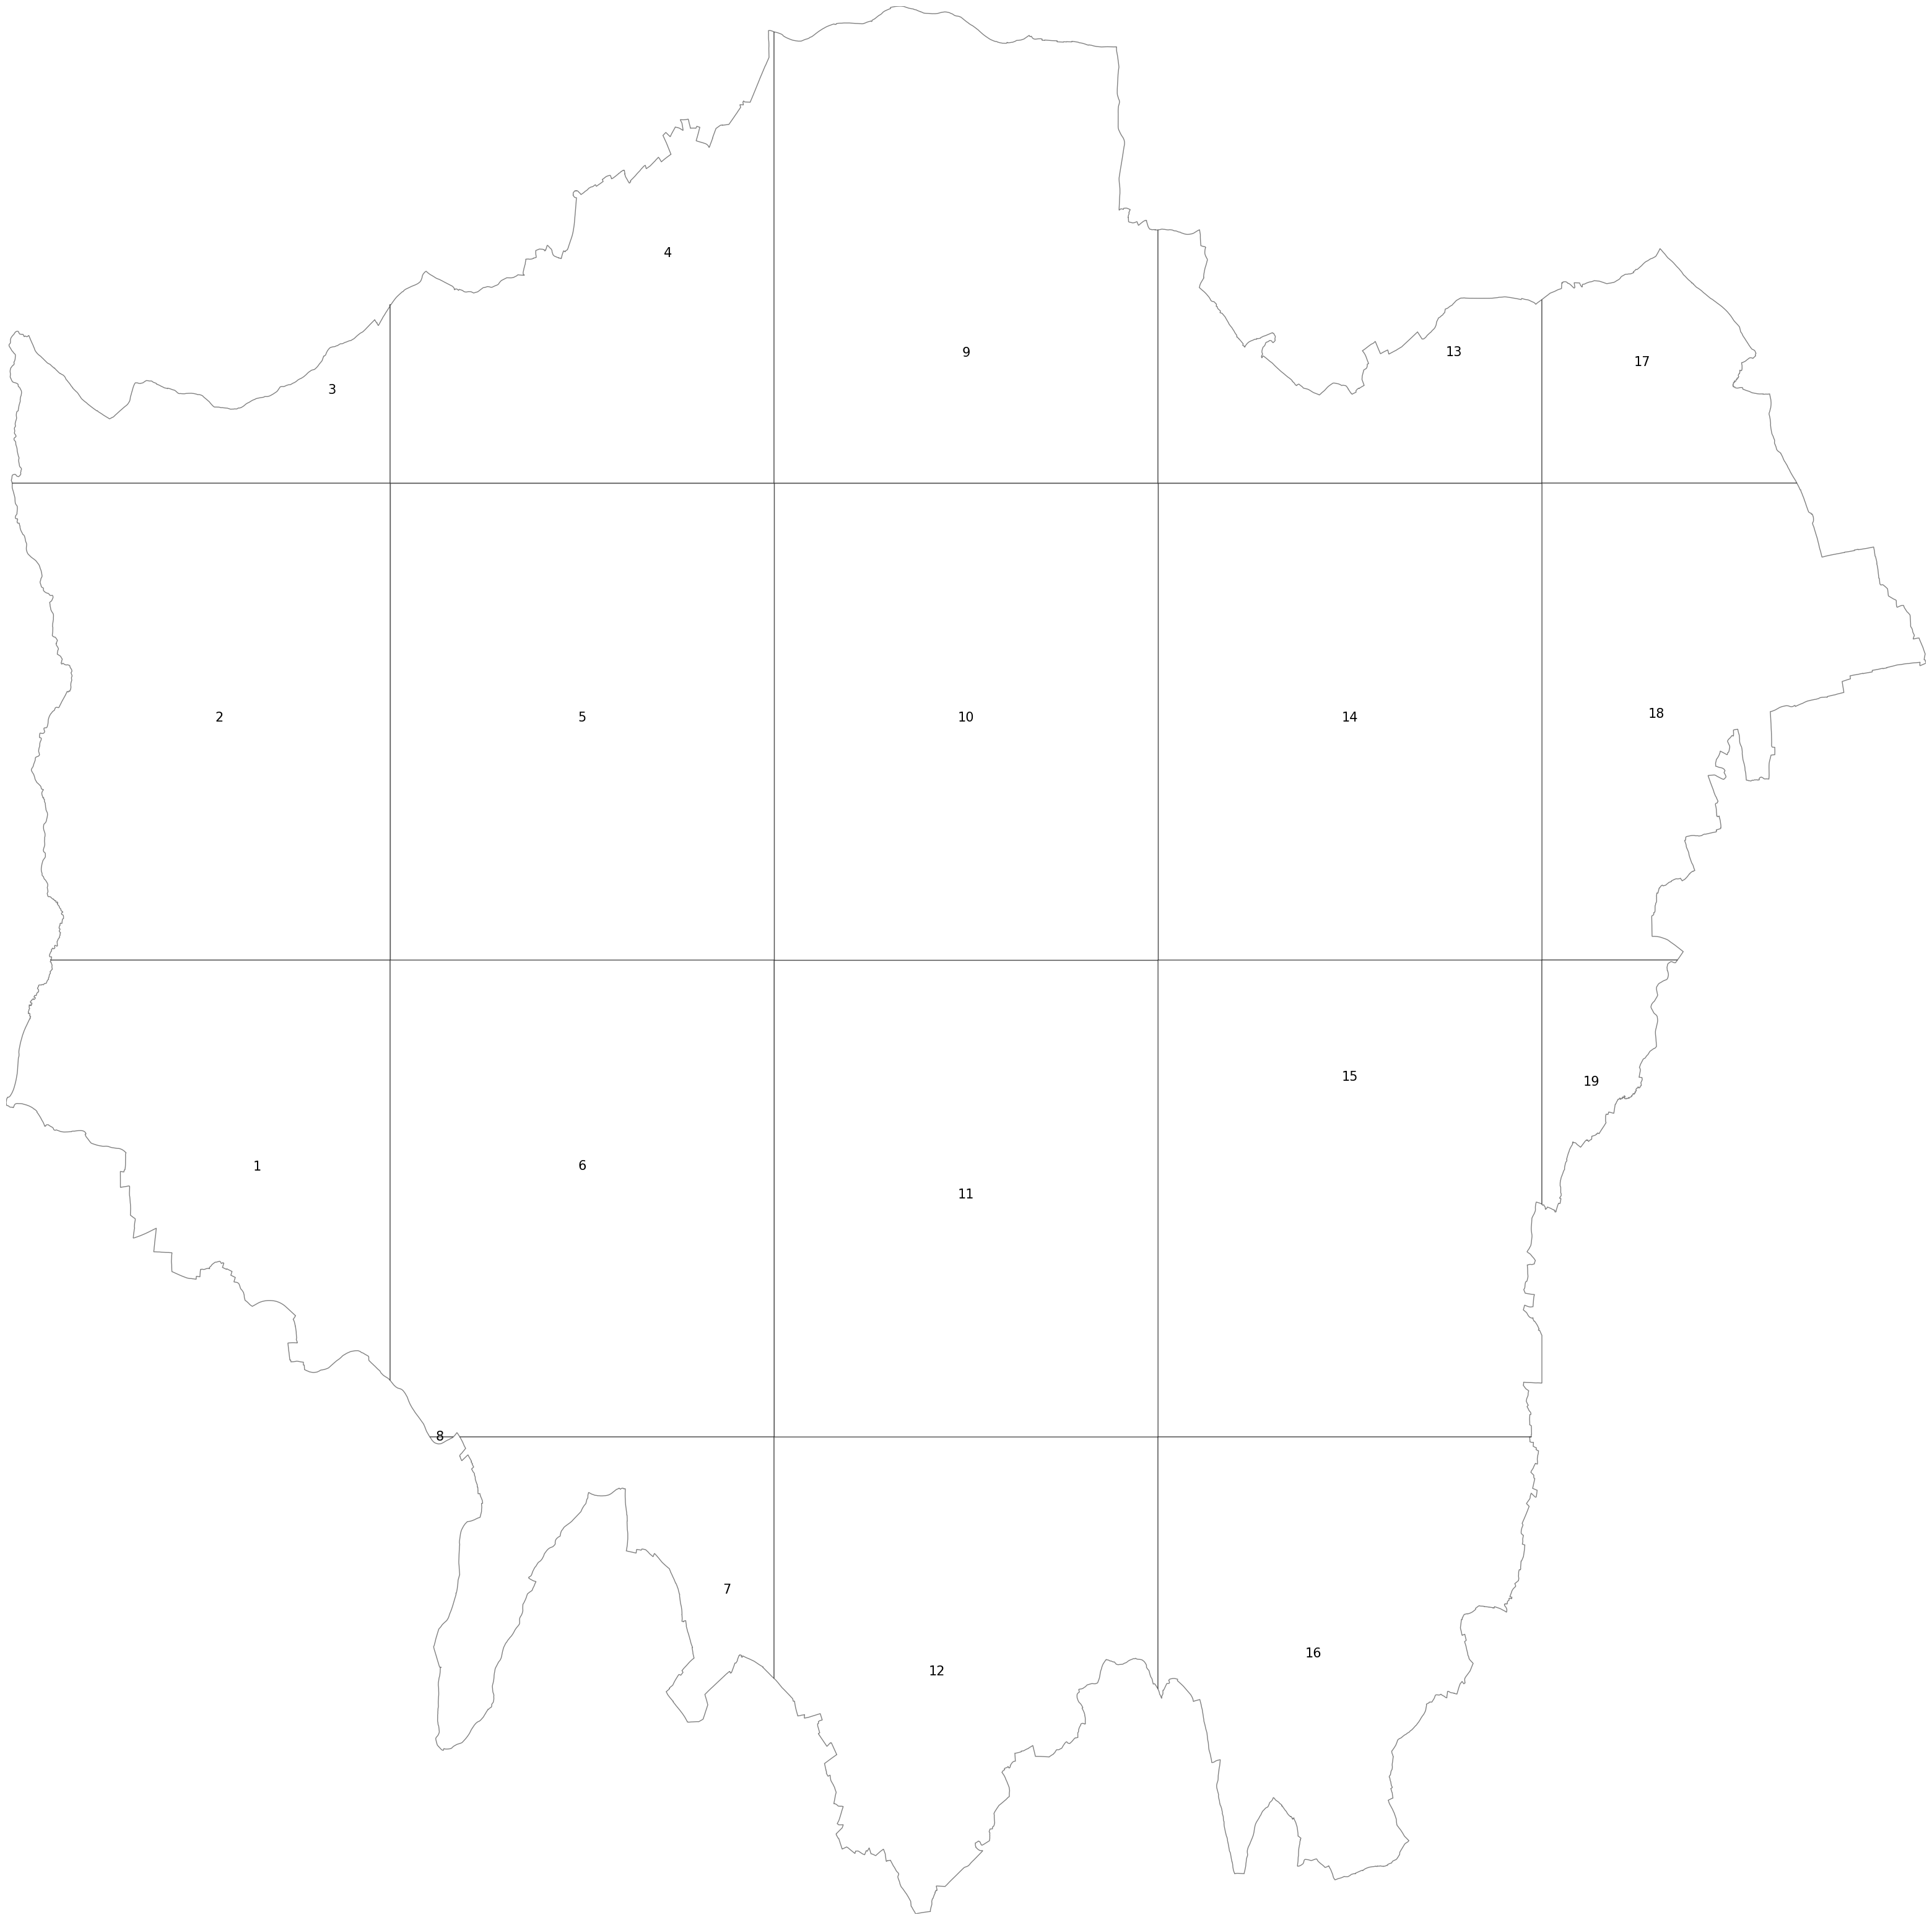

In [15]:
list_polygons = [p for p in list(geometry_grids_split.geoms)]

#Figure out the bounds of the city
west, south, east, north = city.unary_union.bounds

#Plot the city and grids
fig, ax = plt.subplots(figsize=(40,40))
for polygon, n in zip(geometry_grids_split.geoms, np.arange(1, len(list_polygons))):
    #print(polygon)
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    plt.annotate(text=n, xy=p, horizontalalignment='center', size=15)

ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')

In [16]:
gdf_polygons = gpd.GeoDataFrame(geometry=list_polygons)
gdf_polygons.crs = city.crs
print(gdf_polygons.crs)
gdf_polygons.head()

+proj=utm +zone=30 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


geometry
0  POLYGON ((672921.309 5704834.163, 672925.683 5...
1  POLYGON ((674270.652 5708188.531, 674270.960 5...
2  POLYGON ((673100.520 5719461.590, 673097.780 5...
3  POLYGON ((684573.700 5723679.685, 684574.588 5...
4  POLYGON ((696227.193 5719461.590, 696227.193 5...

## 2.4. Overlay the city on the rest of the map (using contextily)

In [17]:
#ctx uses crs epsg:3857
#we need to convert the crs to espg:3857
gdf_polygons_3857 = gdf_polygons.to_crs(epsg=3857)
gdf_polygons_3857['grid_index'] = gdf_polygons_3857.index
west, south, east, north = gdf_polygons_3857.unary_union.bounds

ax = gdf_polygons_3857.plot(figsize=(20,20), alpha=0.5, edgecolor='k')
for idx, row in gdf_polygons_3857.iterrows():
    label = row['grid_index']  # Replace 'grid_index' with the desired column containing labels or information
    centroid_coords = row['geometry'].centroid.coords[0]
    ax.annotate(text=label, xy=centroid_coords, horizontalalignment='center', size=30)
#add the rest of the map in the background
ctx.add_basemap(ax, zoom=13) #,source=ctx.providers.Stamen.TonerLite)
ax.set_xlim(west, east)
ax.set_ylim(south, north)

Output hidden; open in https://colab.research.google.com to view.

# 3. Obtain the population information for the city

For obtaining the population information for the chosen city (London), I am relying on the Gridded Population of the World Dataset (GPW v4).

"The Gridded Population of the World, Version 4 (GPWv4): Population Count, Revision 11 consists of estimates of human population (number of persons per pixel), consistent with national censuses and population registers, for the years 2000, 2005, 2010, 2015, and 2020. A proportional allocation gridding algorithm, utilizing approximately 13.5 million national and sub-national administrative units, was used to assign population counts to 30 arc-second grid cells. The data files were produced as global rasters at 30 arc-second (~1 km at the equator) resolution. To enable faster global processing, and in support of research communities, the 30 arc-second data were aggregated to 2.5 arc-minute, 15 arc-minute, 30 arc-minute and 1 degree resolutions" **[1]**


In this notebook, I am relying on 30 arc-second data which approximately provides the population for a 1KM x 1KM grid at the equator.



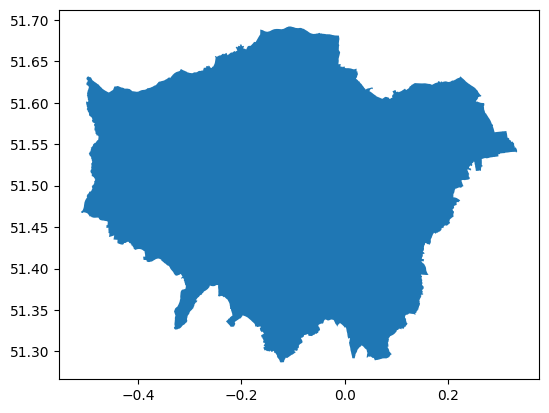

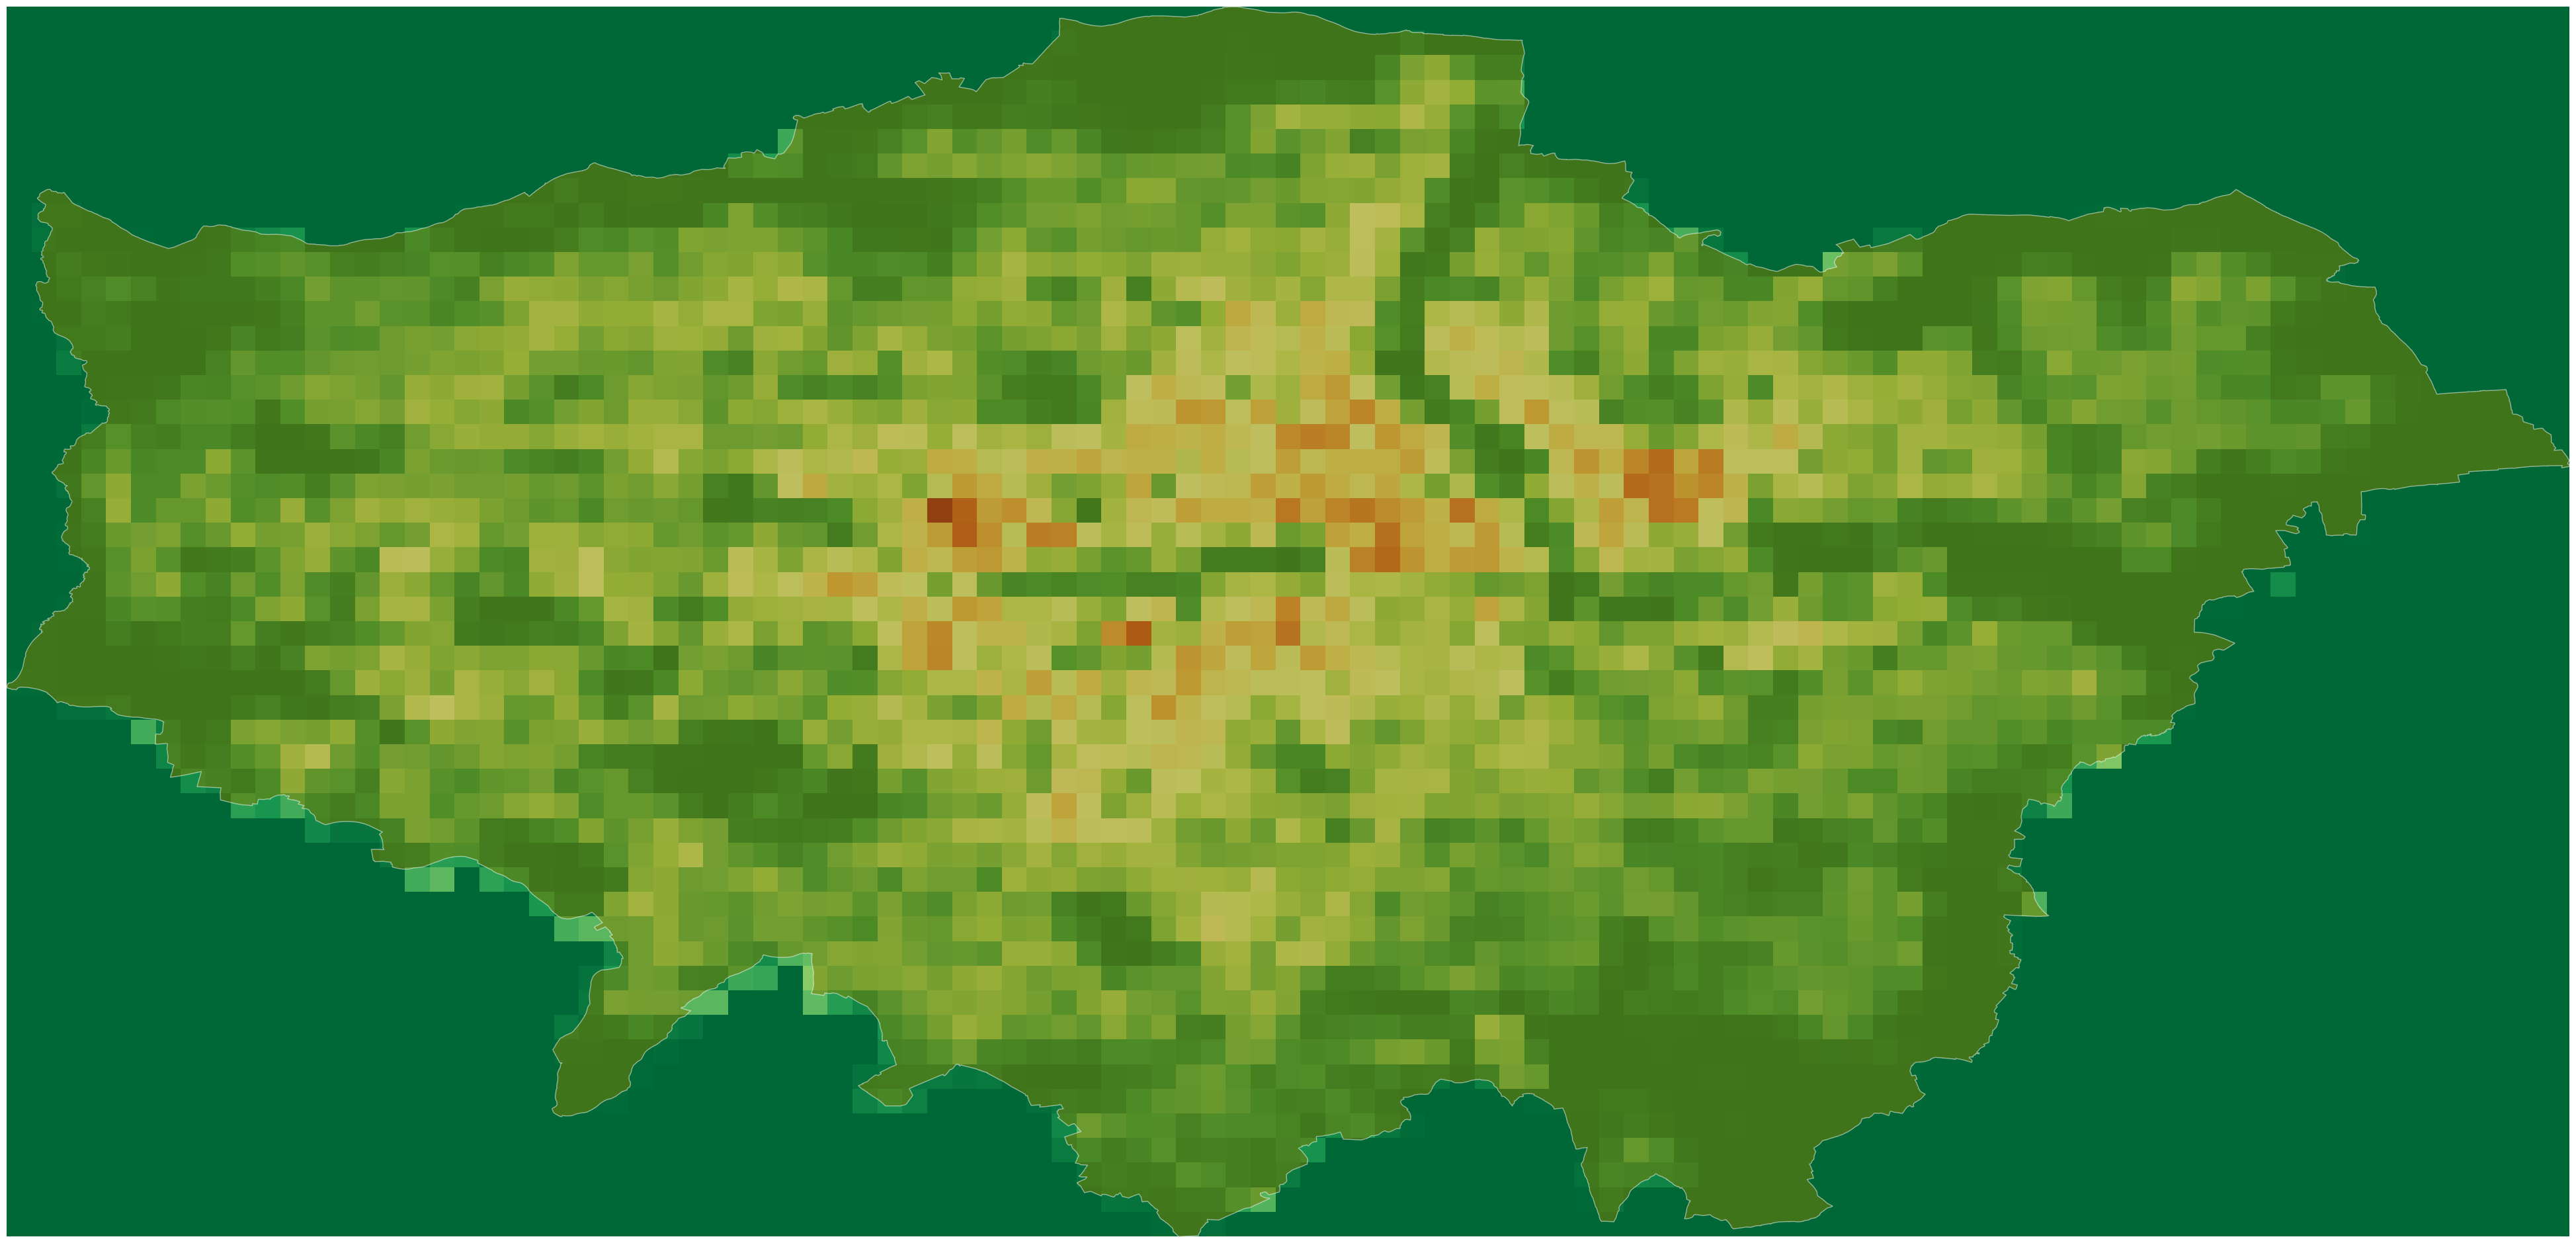

GeoDataFrame saved to LONDON_gpw_output.geojson


In [18]:
gpw = rio.open('Important Data/GPW Data/gpw_v4_population_count_rev11_2020_30_sec.tif')

#Initialise Variables
REGION = "LONDON"

#gdf_london_region = ox.geocode_to_gdf("London, UK", which_result=1)
gdf_london_region = gpd.read_file('LONDON_shapefile.shp')
gdf_london_region['geometry'] = unary_union([gdf_london_region['geometry'].iloc[0], gdf_london_region['geometry'].iloc[1]])
gdf_london_region = gdf_london_region.head(1)
gdf_london_region = gdf_london_region.to_crs('4326')
gdf_london_region.plot()

box = gdf_london_region.total_bounds
gpw_region = gpw.read(1, window=gpw.window(*box))


# hide
def fn_showGeoDataFrame_WithMask(gpdObject, maskObject):
    """
    This function displays the  GeoDataframe and overlays the mask on top of the GeoDataframe

    Inputs:
    GeoDataframe: This is the actual GeoDataframe passed as input to the function that needs to be displayed
    Mask object: This is the mask that needs to be displayed over the object.

    Outputs:
    None
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(50, 50))
    ax.set_axis_off()

    gpdObject.plot(ax=ax, facecolor='olive', edgecolor='white', alpha=0.5)
    ax.imshow(maskObject, cmap='RdYlGn_r', extent=box[[0,2,1,3]])
    plt.show()



region_mask, region_mask_tfm = mask(dataset=gpw, shapes=gdf_london_region.geometry, all_touched=True, crop=True, filled=True)
region_mask = np.where(region_mask < 0, 0, region_mask).squeeze()


fn_showGeoDataFrame_WithMask(gdf_london_region, region_mask)


# Save the clipped raster
region_meta = gpw.meta
region_meta.update(dict(
    driver='GTiff',
    height=region_mask.shape[0],
    width=region_mask.shape[1],
    transform=region_mask_tfm
))
with rio.open(f'{REGION}_gpw_output.tif', 'w', **region_meta) as f: f.write(region_mask, indexes=1)


# Path to the clipped raster
clipped_raster_path = f'{REGION}_gpw_output.tif'

# Read the clipped raster
with rio.open(clipped_raster_path) as src:
    region_mask = src.read(1)
    transform = src.transform

# Get shapes (polygons) from the raster
shapes = features.shapes(region_mask, transform=transform)

# Prepare data for GeoDataFrame
data = {
    'tile_idx': [],
    'tile_population': [],
    'geometry': [],
    'tile_width': [],
    'tile_height': []
}

for idx, (geometry, value) in enumerate(shapes):
    if value != 0:  # Skip polygons with no data (value = 0)
        tile_idx = idx + 1
        tile_population = int(value)
        geometry = shape(geometry)
        tile_width, tile_height = geometry.bounds[2] - geometry.bounds[0], geometry.bounds[3] - geometry.bounds[1]

        data['tile_idx'].append(tile_idx)
        data['tile_population'].append(tile_population)
        data['geometry'].append(geometry)
        data['tile_width'].append(tile_width)
        data['tile_height'].append(tile_height)

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(data)

# Save the GeoDataFrame to a shapefile or other formats if needed
output_shapefile_path = f'{REGION}_gpw_output.geojson'
#gdf = gdf.to_crs(epsg=3857)
gdf.to_file(output_shapefile_path)

print(f"GeoDataFrame saved to {output_shapefile_path}")

In [19]:
tiles_gdf = gpd.read_file(f'{REGION}_gpw_output.geojson')
tiles_gdf

tile_idx  tile_population  tile_width  tile_height  \
0            1               68    0.008333     0.008333   
1            2              100    0.008333     0.008333   
2            3              302    0.008333     0.008333   
3            4               27    0.008333     0.008333   
4            5               27    0.008333     0.008333   
...        ...              ...         ...          ...   
3148      3152              242    0.008333     0.008333   
3149      3154               28    0.008333     0.008333   
3150      3155               32    0.008333     0.008333   
3151      3156               29    0.008333     0.008333   
3152      3157               27    0.008333     0.008333   

                                               geometry  
0     POLYGON ((-0.11667 51.70000, -0.11667 51.69167...  
1     POLYGON ((-0.10833 51.70000, -0.10833 51.69167...  
2     POLYGON ((-0.16667 51.69167, -0.16667 51.68333...  
3     POLYGON ((-0.15833 51.69167, -0.15833 51.68333...  
4     POLYGON ((-0.15000 51.69167, -0.15000 51.68333...  
...                                                 ...  
3148  POLYGON ((-0.11667 51.29167, -0.11667 51.28333...  
3149  POLYGON ((0.05000 51.29167, 0.05000 51.28333, ...  
3150  POLYGON ((0.05833 51.29167, 0.05833 51.28333, ...  
3151  POLYGON ((0.06667 51.29167, 0.06667 51.28333, ...  
3152  POLYGON ((0.07500 51.29167, 0.07500 51.28333, ...  

[3153 rows x 5 columns]

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

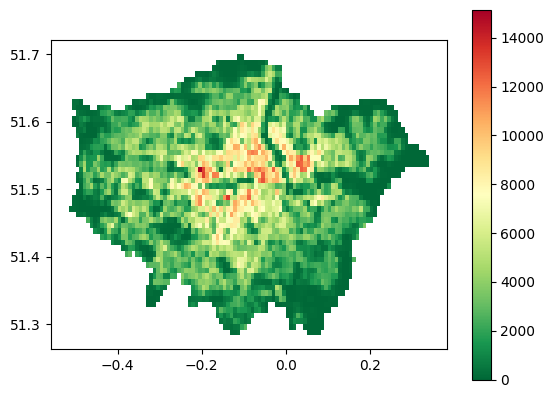

In [20]:
tiles_gdf.plot('tile_population',cmap='RdYlGn_r', legend=True)
tiles_gdf.crs

In [21]:
tiles_gdf_mercator = tiles_gdf.to_crs(epsg=3857)
tiles_gdf_mercator.to_file('file_ldn.shp', driver='ESRI Shapefile')

<ipython-input-21-d5b512ddd5e9>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  tiles_gdf_mercator.to_file('file_ldn.shp', driver='ESRI Shapefile')


# 4. Obtain the population for each grid in the city (Interpolation using area intercepted by the tiles in the GPW v4 dataset and the Gridded city map)

In [22]:
# Load the GeoDataFrame from the shapefile
gpw_gdf = gpd.read_file('file_ldn.shp')
gpw_gdf['total_tile_area'] = gpw_gdf.geometry.area
gpw_gdf

tile_idx  tile_popul  tile_width  tile_heigh  \
0            1          68    0.008333    0.008333   
1            2         100    0.008333    0.008333   
2            3         302    0.008333    0.008333   
3            4          27    0.008333    0.008333   
4            5          27    0.008333    0.008333   
...        ...         ...         ...         ...   
3148      3152         242    0.008333    0.008333   
3149      3154          28    0.008333    0.008333   
3150      3155          32    0.008333    0.008333   
3151      3156          29    0.008333    0.008333   
3152      3157          27    0.008333    0.008333   

                                               geometry  total_tile_area  
0     POLYGON ((-12987.274 6746062.318, -12059.612 6...     1.388363e+06  
1     POLYGON ((-12059.612 6746062.318, -11131.949 6...     1.388363e+06  
2     POLYGON ((-18553.248 6744565.692, -17625.586 6...     1.388108e+06  
3     POLYGON ((-17625.586 6744565.692, -16697.924 6...     1.388108e+06  
4     POLYGON ((-16697.924 6744565.692, -15770.261 6...     1.388108e+06  
...                                                 ...              ...  
3148  POLYGON ((-12987.274 6673049.249, -12059.612 6...     1.375983e+06  
3149  POLYGON ((5565.975 6673049.249, 6493.637 66730...     1.375983e+06  
3150  POLYGON ((6493.637 6673049.249, 7421.299 66730...     1.375983e+06  
3151  POLYGON ((7421.299 6673049.249, 8348.962 66730...     1.375983e+06  
3152  POLYGON ((8348.962 6673049.249, 9276.624 66730...     1.375983e+06  

[3153 rows x 6 columns]

In [23]:
gdf_polygons_3857_indexed = gdf_polygons_3857.copy()
#gdf_polygons_3857_indexed['grid_index'] = gdf_polygons_3857_indexed.index
gdf_polygons_3857_indexed['total_grid_area'] = gdf_polygons_3857_indexed.geometry.area
gdf_polygons_3857_indexed

geometry  grid_index  \
0   POLYGON ((-56812.147 6704537.466, -56804.210 6...           0   
1   POLYGON ((-54467.483 6709849.877, -54466.879 6...           1   
2   POLYGON ((-55724.781 6728042.454, -55728.418 6...           2   
3   POLYGON ((-37056.872 6734181.760, -37055.464 6...           3   
4   POLYGON ((-18598.086 6726684.089, -19297.632 6...           4   
5   POLYGON ((-19297.632 6708563.691, -19993.107 6...           5   
6   POLYGON ((-19993.107 6690483.077, -20343.802 6...           6   
7   POLYGON ((-35553.029 6691068.754, -35554.655 6...           7   
8   POLYGON ((-17932.418 6743865.958, -17927.158 6...           8   
9   POLYGON ((103.580 6725935.446, -637.303 670781...           9   
10  POLYGON ((-637.303 6707819.400, -1373.877 6689...          10   
11  POLYGON ((-1373.877 6689743.104, -1761.503 668...          11   
12  POLYGON ((498.724 6735570.597, 562.219 6735575...          12   
13  POLYGON ((18800.605 6725143.853, 18018.419 670...          13   
14  POLYGON ((18018.419 6707032.407, 17619.633 669...          14   
15  POLYGON ((16715.791 6688983.326, 16651.414 668...          15   
16  POLYGON ((19102.847 6732124.636, 19123.998 673...          16   
17  POLYGON ((31216.453 6724594.359, 31253.214 672...          17   
18  POLYGON ((24606.010 6706744.263, 24583.462 670...          18   
19  POLYGON ((17406.151 6692809.223, 17411.337 669...          19   

    total_grid_area  
0      2.002488e+08  
1      3.048445e+08  
2      7.290612e+07  
3      1.974706e+08  
4      3.391022e+08  
5      3.352066e+08  
6      1.033663e+08  
7      1.865205e+05  
8      3.099712e+08  
9      3.390041e+08  
10     3.375098e+08  
11     2.414844e+08  
12     1.123509e+08  
13     3.389002e+08  
14     3.334888e+08  
15     2.178282e+08  
16     8.044876e+07  
17     2.094376e+08  
18     3.604479e+07  
19     5.354346e+05

In [24]:
# Perform spatial overlay with intersection to get the intersecting areas between the grids and GPW polygons
intersection_gdf = gpd.overlay(gdf_polygons_3857_indexed, gpw_gdf, how='intersection')

intersection_gdf['intersection_area'] = intersection_gdf.geometry.area
intersection_gdf

grid_index  total_grid_area  tile_idx  tile_popul  tile_width  \
0              0     2.002488e+08      1649         135    0.008333   
1              0     2.002488e+08      1650         155    0.008333   
2              1     3.048445e+08      1650         155    0.008333   
3              0     2.002488e+08      1651        1275    0.008333   
4              1     3.048445e+08      1651        1275    0.008333   
...          ...              ...       ...         ...         ...   
3547          18     3.604479e+07      2240        2049    0.008333   
3548          18     3.604479e+07      2241        3641    0.008333   
3549          18     3.604479e+07      2317        1428    0.008333   
3550          18     3.604479e+07      2391        2237    0.008333   
3551          19     5.354346e+05      2651        2569    0.008333   

      tile_heigh  total_tile_area  \
0       0.008333     1.382263e+06   
1       0.008333     1.382263e+06   
2       0.008333     1.382263e+06   
3       0.008333     1.382263e+06   
4       0.008333     1.382263e+06   
...          ...              ...   
3547    0.008333     1.380749e+06   
3548    0.008333     1.380749e+06   
3549    0.008333     1.380497e+06   
3550    0.008333     1.380245e+06   
3551    0.008333     1.379239e+06   

                                               geometry  intersection_area  
0     POLYGON ((-55096.090 6708732.043, -55102.369 6...       7.772513e+04  
1     POLYGON ((-54719.419 6708974.110, -54713.919 6...       8.399152e+05  
2     POLYGON ((-54466.879 6709853.042, -54464.152 6...       2.517751e+05  
3     POLYGON ((-52876.758 6709793.532, -52876.758 6...       1.002736e+06  
4     POLYGON ((-53804.421 6709826.391, -53804.421 6...       3.795272e+05  
...                                                 ...                ...  
3547  POLYGON ((20393.942 6700307.055, 20390.703 670...       1.109329e+06  
3548  POLYGON ((21260.375 6701066.269, 21165.364 670...       4.472803e+05  
3549  MULTIPOLYGON (((19047.945 6699776.366, 19034.6...       3.025404e+05  
3550  MULTIPOLYGON (((18567.868 6698142.293, 18572.2...       2.196684e+03  
3551  POLYGON ((17637.126 6691786.332, 17657.932 669...       1.609285e+05  

[3552 rows x 9 columns]

Approximate the population for each grid in the city. First we calculate the intersection of the grids and tiles and figure out if a partial or complete intersection has happened.

If a complete intersection has happened, then the total population of the tile is assigned to the grid.

If there is a partial intersection, the ratio of the area of intersection and the total area of the tile is calculated. The population is divided and assigned to each intersecting grid based on this ratio.

In reality, this may not truly represent the intricacies of population distribution. However, this is a simpler approximation to solve the problem of population distribution across the city grids.

In [25]:
# Merge the aggregated population data back to the grid GeoDataFrame
grid_with_population_final = gdf_polygons_3857_indexed.merge(intersection_gdf[['intersection_area', 'tile_idx','tile_popul','total_tile_area','grid_index']], on='grid_index', how='left')
#grid_with_population_final['population_contribution'] = grid_with_population_final['total_grid_area']
grid_with_population_final['isCompleteIntersection'] = np.where(grid_with_population_final['total_tile_area']==grid_with_population_final['intersection_area'], 1, 0)
grid_with_population_final['population_ratio'] = np.where(grid_with_population_final['isCompleteIntersection']!=1, round(grid_with_population_final.intersection_area/grid_with_population_final.total_tile_area,8), 1)
grid_with_population_final['population_contribution'] = (grid_with_population_final['population_ratio'] * grid_with_population_final['tile_popul']).apply(np.ceil).astype('int')
grid_with_population_final

geometry  grid_index  \
0     POLYGON ((-56812.147 6704537.466, -56804.210 6...           0   
1     POLYGON ((-56812.147 6704537.466, -56804.210 6...           0   
2     POLYGON ((-56812.147 6704537.466, -56804.210 6...           0   
3     POLYGON ((-56812.147 6704537.466, -56804.210 6...           0   
4     POLYGON ((-56812.147 6704537.466, -56804.210 6...           0   
...                                                 ...         ...   
3547  POLYGON ((24606.010 6706744.263, 24583.462 670...          18   
3548  POLYGON ((24606.010 6706744.263, 24583.462 670...          18   
3549  POLYGON ((17406.151 6692809.223, 17411.337 669...          19   
3550  POLYGON ((17406.151 6692809.223, 17411.337 669...          19   
3551  POLYGON ((17406.151 6692809.223, 17411.337 669...          19   

      total_grid_area  intersection_area  tile_idx  tile_popul  \
0        2.002488e+08       7.772513e+04      1649         135   
1        2.002488e+08       8.399152e+05      1650         155   
2        2.002488e+08       1.002736e+06      1651        1275   
3        2.002488e+08       9.722538e+05      1652        1960   
4        2.002488e+08       9.417719e+05      1653        1861   
...               ...                ...       ...         ...   
3547     3.604479e+07       3.025404e+05      2317        1428   
3548     3.604479e+07       2.196684e+03      2391        2237   
3549     5.354346e+05       3.837994e+04      2590         489   
3550     5.354346e+05       3.361261e+05      2650         105   
3551     5.354346e+05       1.609285e+05      2651        2569   

      total_tile_area  isCompleteIntersection  population_ratio  \
0        1.382263e+06                       0          0.056230   
1        1.382263e+06                       0          0.607638   
2        1.382263e+06                       0          0.725431   
3        1.382263e+06                       0          0.703378   
4        1.382263e+06                       0          0.681326   
...               ...                     ...               ...   
3547     1.380497e+06                       0          0.219153   
3548     1.380245e+06                       0          0.001592   
3549     1.379491e+06                       0          0.027822   
3550     1.379239e+06                       0          0.243704   
3551     1.379239e+06                       0          0.116679   

      population_contribution  
0                           8  
1                          95  
2                         925  
3                        1379  
4                        1268  
...                       ...  
3547                      313  
3548                        4  
3549                       14  
3550                       26  
3551                      300  

[3552 rows x 10 columns]

# 4.1. Population per grid aggregation

In [26]:
grid_with_population_final = grid_with_population_final.groupby(['grid_index'])['population_contribution'].sum().reset_index()

gdf_polygons_3857_populated = gdf_polygons_3857_indexed.join(grid_with_population_final[['grid_index', 'population_contribution']], on='grid_index', how='inner', lsuffix='_left')
gdf_polygons_3857_populated.population_contribution.sum()

9212791

In [27]:
gdf_polygons_3857_populated

geometry  grid_index_left  \
0   POLYGON ((-56812.147 6704537.466, -56804.210 6...                0   
1   POLYGON ((-54467.483 6709849.877, -54466.879 6...                1   
2   POLYGON ((-55724.781 6728042.454, -55728.418 6...                2   
3   POLYGON ((-37056.872 6734181.760, -37055.464 6...                3   
4   POLYGON ((-18598.086 6726684.089, -19297.632 6...                4   
5   POLYGON ((-19297.632 6708563.691, -19993.107 6...                5   
6   POLYGON ((-19993.107 6690483.077, -20343.802 6...                6   
7   POLYGON ((-35553.029 6691068.754, -35554.655 6...                7   
8   POLYGON ((-17932.418 6743865.958, -17927.158 6...                8   
9   POLYGON ((103.580 6725935.446, -637.303 670781...                9   
10  POLYGON ((-637.303 6707819.400, -1373.877 6689...               10   
11  POLYGON ((-1373.877 6689743.104, -1761.503 668...               11   
12  POLYGON ((498.724 6735570.597, 562.219 6735575...               12   
13  POLYGON ((18800.605 6725143.853, 18018.419 670...               13   
14  POLYGON ((18018.419 6707032.407, 17619.633 669...               14   
15  POLYGON ((16715.791 6688983.326, 16651.414 668...               15   
16  POLYGON ((19102.847 6732124.636, 19123.998 673...               16   
17  POLYGON ((31216.453 6724594.359, 31253.214 672...               17   
18  POLYGON ((24606.010 6706744.263, 24583.462 670...               18   
19  POLYGON ((17406.151 6692809.223, 17411.337 669...               19   

    total_grid_area  grid_index  population_contribution  
0      2.002488e+08           0                   290813  
1      3.048445e+08           1                   529794  
2      7.290612e+07           2                    65432  
3      1.974706e+08           3                   310866  
4      3.391022e+08           4                  1141004  
5      3.352066e+08           5                   754291  
6      1.033663e+08           6                   184762  
7      1.865205e+05           7                       69  
8      3.099712e+08           8                   655551  
9      3.390041e+08           9                  1570414  
10     3.375098e+08          10                  1275105  
11     2.414844e+08          11                   340780  
12     1.123509e+08          12                   152586  
13     3.389002e+08          13                   987584  
14     3.334888e+08          14                   560070  
15     2.178282e+08          15                   106803  
16     8.044876e+07          16                    72892  
17     2.094376e+08          17                   166530  
18     3.604479e+07          18                    47105  
19     5.354346e+05          19                      340

In [28]:
gdf_polygons_3857_populated['population_contribution'].max()

1570414

In [29]:
gdf_polygons_3857_populated['population_contribution'].sum()

9212791

In [30]:
gdf_polygons_3857_populated.sort_values('population_contribution', ascending=False).tail(20)

geometry  grid_index_left  \
9   POLYGON ((103.580 6725935.446, -637.303 670781...                9   
10  POLYGON ((-637.303 6707819.400, -1373.877 6689...               10   
4   POLYGON ((-18598.086 6726684.089, -19297.632 6...                4   
13  POLYGON ((18800.605 6725143.853, 18018.419 670...               13   
5   POLYGON ((-19297.632 6708563.691, -19993.107 6...                5   
8   POLYGON ((-17932.418 6743865.958, -17927.158 6...                8   
14  POLYGON ((18018.419 6707032.407, 17619.633 669...               14   
1   POLYGON ((-54467.483 6709849.877, -54466.879 6...                1   
11  POLYGON ((-1373.877 6689743.104, -1761.503 668...               11   
3   POLYGON ((-37056.872 6734181.760, -37055.464 6...                3   
0   POLYGON ((-56812.147 6704537.466, -56804.210 6...                0   
6   POLYGON ((-19993.107 6690483.077, -20343.802 6...                6   
17  POLYGON ((31216.453 6724594.359, 31253.214 672...               17   
12  POLYGON ((498.724 6735570.597, 562.219 6735575...               12   
15  POLYGON ((16715.791 6688983.326, 16651.414 668...               15   
16  POLYGON ((19102.847 6732124.636, 19123.998 673...               16   
2   POLYGON ((-55724.781 6728042.454, -55728.418 6...                2   
18  POLYGON ((24606.010 6706744.263, 24583.462 670...               18   
19  POLYGON ((17406.151 6692809.223, 17411.337 669...               19   
7   POLYGON ((-35553.029 6691068.754, -35554.655 6...                7   

    total_grid_area  grid_index  population_contribution  
9      3.390041e+08           9                  1570414  
10     3.375098e+08          10                  1275105  
4      3.391022e+08           4                  1141004  
13     3.389002e+08          13                   987584  
5      3.352066e+08           5                   754291  
8      3.099712e+08           8                   655551  
14     3.334888e+08          14                   560070  
1      3.048445e+08           1                   529794  
11     2.414844e+08          11                   340780  
3      1.974706e+08           3                   310866  
0      2.002488e+08           0                   290813  
6      1.033663e+08           6                   184762  
17     2.094376e+08          17                   166530  
12     1.123509e+08          12                   152586  
15     2.178282e+08          15                   106803  
16     8.044876e+07          16                    72892  
2      7.290612e+07           2                    65432  
18     3.604479e+07          18                    47105  
19     5.354346e+05          19                      340  
7      1.865205e+05           7                       69

# 4.2. Plot the population distribution across the city grids

In [31]:
#ctx uses crs epsg:3857
#we need to convert the crs to espg:3857
west, south, east, north = gdf_polygons_3857_populated.unary_union.bounds

ax = gdf_polygons_3857_populated.plot(column='population_contribution',figsize=(40,40), alpha=0.5, edgecolor='k', cmap='magma', legend=True)
for idx, row in gdf_polygons_3857_populated.iterrows():
    label = row['grid_index']  # Replace 'grid_index' with the desired column containing labels or information
    centroid_coords = row['geometry'].centroid.coords[0]
    ax.annotate(text=label, xy=centroid_coords, horizontalalignment='center', size=30)


#add the rest of the map in the background
ctx.add_basemap(ax, zoom=13)
ax.set_xlim(west, east)
ax.set_ylim(south, north)

Output hidden; open in https://colab.research.google.com to view.

In [32]:
gdf_polygons_3857_populated.to_file('London_grids_with_population.shp', driver='ESRI Shapefile', crs='3857')

<ipython-input-32-75a71ec8a930>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_polygons_3857_populated.to_file('London_grids_with_population.shp', driver='ESRI Shapefile', crs='3857')


In [33]:
type(gdf_polygons_3857_populated)

geopandas.geodataframe.GeoDataFrame

In [34]:
gdf_polygons_3857_populated['population_contribution'].sum()

9212791

# 5. Calculate the Origin-Destination Matrix to model travel across the city grids

For building the Origin-Destination Matrix, we will be using a separate notebook which contains all the different operations required to build the aggregated OD matrix for London.

In [35]:
%run ./origin-destination-matrix.ipynb

Output hidden; open in https://colab.research.google.com to view.

In [36]:
od_matrix_normalized_weekly.shape

(7, 20, 20)

In [37]:
od_matrix_normalized_weekly

array([[[0.        , 0.00027462, 0.02514247, ..., 0.12826132,
         0.        , 0.        ],
        [0.0002756 , 0.        , 0.02495695, ..., 0.12844525,
         0.        , 0.        ],
        [0.0347808 , 0.0344009 , 0.        , ..., 0.14264931,
         0.        , 0.        ],
        ...,
        [0.12100023, 0.12074115, 0.09728112, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.00027462, 0.02514247, ..., 0.12826132,
         0.        , 0.        ],
        [0.0002756 , 0.        , 0.02495695, ..., 0.12844525,
         0.        , 0.        ],
        [0.0347808 , 0.0344009 , 0.        , ..., 0.14264931,
         0.        , 0.        ],
        ...,
        [0.12100023, 0.12074115, 0.09728112, ..., 0.        ,
         0.        , 0.        ],
        [0. 

## 5.2. Uber Data

In [38]:
df_uber = pd.read_csv('Important Data/london-traversals-uber-bike.csv')
df_uber['geometry'] = df_uber['wktGeometry'].apply(wkt.loads)
df_uber

hexid  dayType  traversals  \
0       8c195da412b41ff  weekday          16   
1       8c195da4139b5ff  weekday          71   
2       8c195da4139b9ff  weekday          84   
3       8c195da413991ff  weekday          92   
4       8c195da4138a3ff  weekday         103   
...                 ...      ...         ...   
186925  8c194ad36b357ff  weekend          17   
186926  8c195da4d8aedff  weekend          21   
186927  8c194ad322219ff  weekend          16   
186928  8c194ad315567ff  weekend          15   
186929  8c195da694dd7ff  weekend          15   

                                              wktGeometry  \
0       POLYGON ((-0.17309114686782898 51.557612032710...   
1       POLYGON ((-0.1726799813523551 51.5576851729952...   
2       POLYGON ((-0.17226881623113643 51.557758311538...   
3       POLYGON ((-0.17177047884154675 51.557673231570...   
4       POLYGON ((-0.1710229795316849 51.5575456082212...   
...                                                   ...   
186925  POLYGON ((-0.08482283678092237 51.532040889619...   
186926  POLYGON ((-0.12634094350608976 51.534569008564...   
186927  POLYGON ((-0.10420261567186462 51.504109677300...   
186928  POLYGON ((-0.06707527515579143 51.498026047700...   
186929  POLYGON ((-0.10143812353468949 51.547934539926...   

                                                 geometry  
0       POLYGON ((-0.173091146867829 51.55761203271005...  
1       POLYGON ((-0.1726799813523551 51.5576851729952...  
2       POLYGON ((-0.1722688162311364 51.5577583115382...  
3       POLYGON ((-0.1717704788415468 51.5576732315705...  
4       POLYGON ((-0.1710229795316849 51.5575456082212...  
...                                                   ...  
186925  POLYGON ((-0.0848228367809224 51.5320408896196...  
186926  POLYGON ((-0.1263409435060898 51.5345690085649...  
186927  POLYGON ((-0.1042026156718646 51.5041096773006...  
186928  POLYGON ((-0.0670752751557914 51.4980260477003...  
186929  POLYGON ((-0.1014381235346895 51.5479345399260...  

[186930 rows x 5 columns]

In [39]:
gdf_uber = gpd.GeoDataFrame(df_uber, crs='epsg:4326')
gdf_uber

hexid  dayType  traversals  \
0       8c195da412b41ff  weekday          16   
1       8c195da4139b5ff  weekday          71   
2       8c195da4139b9ff  weekday          84   
3       8c195da413991ff  weekday          92   
4       8c195da4138a3ff  weekday         103   
...                 ...      ...         ...   
186925  8c194ad36b357ff  weekend          17   
186926  8c195da4d8aedff  weekend          21   
186927  8c194ad322219ff  weekend          16   
186928  8c194ad315567ff  weekend          15   
186929  8c195da694dd7ff  weekend          15   

                                              wktGeometry  \
0       POLYGON ((-0.17309114686782898 51.557612032710...   
1       POLYGON ((-0.1726799813523551 51.5576851729952...   
2       POLYGON ((-0.17226881623113643 51.557758311538...   
3       POLYGON ((-0.17177047884154675 51.557673231570...   
4       POLYGON ((-0.1710229795316849 51.5575456082212...   
...                                                   ...   
186925  POLYGON ((-0.08482283678092237 51.532040889619...   
186926  POLYGON ((-0.12634094350608976 51.534569008564...   
186927  POLYGON ((-0.10420261567186462 51.504109677300...   
186928  POLYGON ((-0.06707527515579143 51.498026047700...   
186929  POLYGON ((-0.10143812353468949 51.547934539926...   

                                                 geometry  
0       POLYGON ((-0.17309 51.55761, -0.17323 51.55759...  
1       POLYGON ((-0.17268 51.55769, -0.17282 51.55766...  
2       POLYGON ((-0.17227 51.55776, -0.17241 51.55773...  
3       POLYGON ((-0.17177 51.55767, -0.17191 51.55765...  
4       POLYGON ((-0.17102 51.55755, -0.17116 51.55752...  
...                                                   ...  
186925  POLYGON ((-0.08482 51.53204, -0.08496 51.53202...  
186926  POLYGON ((-0.12634 51.53457, -0.12648 51.53454...  
186927  POLYGON ((-0.10420 51.50411, -0.10434 51.50409...  
186928  POLYGON ((-0.06708 51.49803, -0.06721 51.49800...  
186929  POLYGON ((-0.10144 51.54793, -0.10158 51.54791...  

[186930 rows x 5 columns]

In [40]:
# Define a function to extract start points for a given Polygon
def fn_get_start_points(polygon):
    """
    This function return the coordinates of the start point of the uber trip

    Inputs:
    polygon: A geospatial Polygon object that maps the route of the trip

    Output:
    Point object: This point identifies the start of the trip.
    """
    exterior_ring = polygon.exterior
    start_point = exterior_ring.coords[0]
    return Point(start_point)

# Define a function to extract end points for a given Polygon
def fn_get_end_points(polygon):
    """
    This function return the coordinates of the start point of the uber trip

    Inputs:
    polygon: A geospatial Polygon object that maps the route of the trip

    Output:
    Point object: This point identifies the start of the trip.
    """
    exterior_ring = polygon.exterior
    #
    end_point = exterior_ring.coords[-2]
    return Point(end_point)

In [41]:
# Extract start and end points using the 'apply' method
gdf_uber['start_point'] = gdf_uber['geometry'].apply(lambda polygon: fn_get_start_points(polygon))
gdf_uber['end_point'] = gdf_uber['geometry'].apply(lambda polygon: fn_get_end_points(polygon))
gdf_uber

hexid  dayType  traversals  \
0       8c195da412b41ff  weekday          16   
1       8c195da4139b5ff  weekday          71   
2       8c195da4139b9ff  weekday          84   
3       8c195da413991ff  weekday          92   
4       8c195da4138a3ff  weekday         103   
...                 ...      ...         ...   
186925  8c194ad36b357ff  weekend          17   
186926  8c195da4d8aedff  weekend          21   
186927  8c194ad322219ff  weekend          16   
186928  8c194ad315567ff  weekend          15   
186929  8c195da694dd7ff  weekend          15   

                                              wktGeometry  \
0       POLYGON ((-0.17309114686782898 51.557612032710...   
1       POLYGON ((-0.1726799813523551 51.5576851729952...   
2       POLYGON ((-0.17226881623113643 51.557758311538...   
3       POLYGON ((-0.17177047884154675 51.557673231570...   
4       POLYGON ((-0.1710229795316849 51.5575456082212...   
...                                                   ...   
186925  POLYGON ((-0.08482283678092237 51.532040889619...   
186926  POLYGON ((-0.12634094350608976 51.534569008564...   
186927  POLYGON ((-0.10420261567186462 51.504109677300...   
186928  POLYGON ((-0.06707527515579143 51.498026047700...   
186929  POLYGON ((-0.10143812353468949 51.547934539926...   

                                                 geometry  \
0       POLYGON ((-0.17309 51.55761, -0.17323 51.55759...   
1       POLYGON ((-0.17268 51.55769, -0.17282 51.55766...   
2       POLYGON ((-0.17227 51.55776, -0.17241 51.55773...   
3       POLYGON ((-0.17177 51.55767, -0.17191 51.55765...   
4       POLYGON ((-0.17102 51.55755, -0.17116 51.55752...   
...                                                   ...   
186925  POLYGON ((-0.08482 51.53204, -0.08496 51.53202...   
186926  POLYGON ((-0.12634 51.53457, -0.12648 51.53454...   
186927  POLYGON ((-0.10420 51.50411, -0.10434 51.50409...   
186928  POLYGON ((-0.06708 51.49803, -0.06721 51.49800...   
186929  POLYGON ((-0.10144 51.54793, -0.10158 51.54791...   

                      start_point                  end_point  
0       POINT (-0.17309 51.55761)  POINT (-0.17298 51.55755)  
1       POINT (-0.17268 51.55769)  POINT (-0.17257 51.55762)  
2       POINT (-0.17227 51.55776)  POINT (-0.17216 51.55769)  
3       POINT (-0.17177 51.55767)  POINT (-0.17166 51.55761)  
4       POINT (-0.17102 51.55755)  POINT (-0.17091 51.55748)  
...                           ...                        ...  
186925  POINT (-0.08482 51.53204)  POINT (-0.08471 51.53197)  
186926  POINT (-0.12634 51.53457)  POINT (-0.12623 51.53450)  
186927  POINT (-0.10420 51.50411)  POINT (-0.10409 51.50404)  
186928  POINT (-0.06708 51.49803)  POINT (-0.06696 51.49796)  
186929  POINT (-0.10144 51.54793)  POINT (-0.10133 51.54787)  

[186930 rows x 7 columns]

In [42]:
gdf_uber_origin = gdf_uber.copy()
gdf_uber_origin = gdf_uber_origin.to_crs('3857')

gdf_uber_origin['geometry'] = gdf_uber_origin['start_point']
gdf_uber_origin = gdf_uber_origin[['hexid', 'dayType', 'traversals', 'geometry','start_point','end_point']]

# Perform a spatial join to figure out the grid from which each Uber Trip starts from (Find Origin Grid of each trip)
start_join = gpd.sjoin(gdf_uber_origin.to_crs('3857'), gdf_polygons_3857_populated[['geometry', 'grid_index']].to_crs('3857'), how='left', predicate='within')
start_join = start_join.dropna(subset=['index_right'])
start_join = start_join.to_crs('3857')

#Change the Geometry of the DataFrame to be based on the destination location
start_join['geometry'] = start_join['end_point']
#Perform a spatial join to figure out the grid to which each Uber Trip is travelling to
end_join = gpd.sjoin(start_join.to_crs('3857'), gdf_polygons_3857_populated[['geometry', 'grid_index']].to_crs('3857'), how='left', predicate='within', lsuffix='start', rsuffix='end')
end_join = end_join.drop(['index_right', 'index_end'], axis=1).copy()

In [43]:
end_join.count()

hexid               186930
dayType             186930
traversals          186930
geometry            186930
start_point         186930
end_point           186930
grid_index_start    186930
grid_index_end      186930
dtype: int64

## As can be seen in the below pie-chart, only 0.1% trips out of 186930 trips made in the year are between city grids. The huge majority (99.9%) of trips are intra-grid trips.

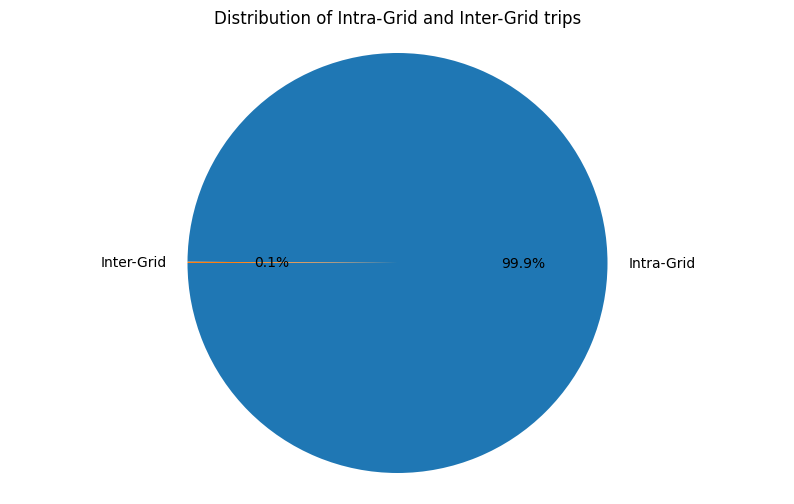

In [44]:
#Create a column in the dataframe to identify if the journey is intra grid or inter grid.
end_join['travelType'] = np.where(end_join['grid_index_start']!=end_join['grid_index_end'], 'Inter-Grid', 'Intra-Grid')

uber_trip_counts = end_join['travelType'].value_counts()
# Plot pie chart
plt.figure(figsize=(10, 6))
plt.pie(uber_trip_counts, labels=uber_trip_counts.index, autopct='%1.1f%%', startangle=180)
plt.title('Distribution of Intra-Grid and Inter-Grid trips')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [45]:
#add the rest of the map in the background
#ax = end_join.plot(column='geometry',figsize=(40,40), alpha=0.5, edgecolor='k', legend=True)

#ctx.add_basemap(ax, zoom=14)
#ax.set_xlim(west, east)
#ax.set_ylim(south, north)
#plt.show()

# 6. Implementing the custom SEIR Model

In [46]:
# Flow is a 2D Matrix of dimensions n x n (i.e. 242 x 242)

In [47]:
n = od_matrix_normalized_weekly.shape[1]
N = gdf_polygons_3857_populated['population_contribution'].sum()

#initialInd = [2, 116, 131, 72]
initialInd = [10]
initial = np.zeros(n)
initial[initialInd] = 1

In [48]:
od_matrix_normalized_weekly.shape

(7, 20, 20)

In [49]:
population_vec = gdf_polygons_3857_populated['population_contribution'].to_numpy(dtype=np.float64).copy()

In [50]:
x = len(gdf_polygons_3857_populated)

In [51]:
def fn_get_OD_matrix_for_day(timestep):
    """
    This function retrieves the current timestamp and returns the Origin Destination matrix for that day

    Inputs:
    timestep: The current timestep being evaluated by odeint function

    Output:
    Numpy 2D array: The OD-Matrix for the current timestep
    """
    #Convert the time to a day of the week (0 - 7 (Mon-Sun))
    day = int(timestep) % 7
    return od_matrix_normalized_weekly[day]

In [52]:
def fn_seir_baseline(y, t, beta, sigma, gamma, alpha=1):
    """
    This function represents the ODE's for the baseline SEIRHD model. This model does not account for spatial mobility and hence will be used for
    model calibration and validation. 'curve_fitting' will be done on this model.

    Inputs:
    y: the initial or current status of each compartment in the model.
    t: The time interval 't' for which the SEIRHD model spread is to be calculated
    beta: Rate of COVID-19 transmission
    sigma: Rate of infection
    gamma: Rate of recovery
    alpha: Strength of intervention

    Outputs:
    Arr: Array containing the population of S, E, I, R, H, D of the 'n' city grids

    """
    OD_M = fn_get_OD_matrix_for_day(t)
    x = OD_M.shape[0]
    S, E, I, R = y[:x], y[x:2*x], y[2*x:3*x], y[3*x:]

    total_population = round(np.sum(y))
    assert total_population == N

    dS, dE, dI, dR = np.zeros(x), np.zeros(x), np.zeros(x), np.zeros(x)

    for i in range(x):
        od_sum = OD_M[i,:].sum()

        dS[i] = -alpha * beta * S[i] * I[i]/(S[i]+E[i]+I[i]+R[i])
        dE[i] = alpha * beta * S[i] * I[i]/(S[i]+E[i]+I[i]+R[i]) - sigma * E[i]
        dI[i] = sigma * E[i] - gamma * I[i]
        dR[i] = gamma * I[i]

    return np.concatenate([dS, dE, dI, dR])

In [53]:
def fn_beta_t(t, beta_initial, beta_lockdown, beta_end, k1, t1, k2, t2):
    """
    This function calculates the time-varying value for beta depending upon the interventions during the period.
    Inputs:
    t: Current time
    beta_initial: Transmission rate during initial spread
    beta_lockdown: Transmission rate during lockdown
    beta_end: Maximum transmission rate after easing restrictions
    k1, t1: Parameters for the first logistic function (lockdown imposition)
    k2, t2: Parameters for the second logistic function (easing of restrictions)

    Outputs:
    beta_t: The value of the transmission parameter at time 't'.
    """
    # Logistic function for lockdown imposition
    lockdown_effect = beta_initial - (beta_initial - beta_lockdown) / (1 + np.exp(-k1 * (t - t1)))

    # Logistic function for easing of restrictions
    easing_effect = beta_lockdown + (beta_end - beta_lockdown) / (1 + np.exp(-k2 * (t - t2)))

    # Combine the effects
    beta_t = lockdown_effect + easing_effect - beta_lockdown  # Subtract beta_lockdown to avoid double counting

    return beta_t


#This model will be used for curve_fitting as part of the model calibration and validation processes.
#The custom SEIRHD spatial mobility model cannot be used for this purpose as the migration terms in the ODE's for each compartment
#make the model very complex and leads to increased run times.
def fn_seirhd_baseline(y, t, beta_initial, beta_lockdown, beta_end, k1, t1, k2, t2, sigma, gamma, delta, mu, gamma_H, r_I_to_H, alpha=1):
    """
    This function represents the ODE's for the baseline SEIRHD model. This model does not account for spatial mobility and hence will be used for
    model calibration and validation. 'curve_fitting' will be done on this model.

    Inputs:
    y: the initial or current status of each compartment in the model.
    t: The time interval 't' for which the SEIRHD model spread is to be calculated
    beta_initial: Initial value of the transmission parameter - beta before the start of the lockdown
    beta_lockdown: Transmission Rate during the lockdown stages.
    beta_end: The transmission rate parameter after the lifting of the intervention.
    k1: decides the gradient of the curve/ tranision from
    t2: timestep when intervention is introduced
    sigma: Rate of infection
    gamma: Rate of recovery
    delta: Rate of hospitalisation
    mu: Fatality rate of COVID-19
    gamma_H: Rate of recovery for hospitalised individuals
    r_I_to_H: Probability of Infected individuals moving to Hospitalised compartment
    alpha: Strength of intervention

    Outputs:
    Arr: Array containing the population of S, E, I, R, H, D of the 'n' city grids

    """
    OD_M = fn_get_OD_matrix_for_day(t)
    x_size = OD_M.shape[0]
    S, E, I, R, H, D = y[:x_size], y[x_size:2*x_size], y[2*x_size:3*x_size], y[3*x_size:4*x_size], y[4*x_size:5*x_size], y[5*x_size:]

    total_population = round(np.sum(y))
    assert total_population == N

    beta = fn_beta_t(t, beta_initial, beta_lockdown, beta_end, k1, t1, k2, t2)

    dS, dE, dI, dR, dH, dD = np.zeros(x_size), np.zeros(x_size), np.zeros(x_size), np.zeros(x_size), np.zeros(x_size), np.zeros(x_size)

    for i in range(x_size):
        N_i = (S[i]+E[i]+I[i]+R[i]+H[i]+D[i])

        dS[i] = -alpha * beta * S[i] * I[i]/N_i
        dE[i] = alpha * beta * S[i] * I[i]/N_i - sigma * E[i]
        dI[i] = sigma * E[i] - (gamma*(1-r_I_to_H) + delta*r_I_to_H) * I[i]
        dH[i] = delta * r_I_to_H * I[i] - (gamma_H + mu) * H[i]
        dR[i] = gamma*(1-r_I_to_H) * I[i] + gamma_H * H[i]
        dD[i] = mu * H[i]

    return np.concatenate([dS, dE, dI, dR, dH, dD])

In [54]:
#Actual SEIRHD spatial mobility model
def fn_seirhd_mobility_model(y, t,  beta_initial, beta_lockdown, beta_end, k1, t1, k2, t2, sigma, gamma, rho, delta, mu, gamma_H, r_I_to_H, alpha=1):
    """
    This function represents the ODE's for the baseline SEIRHD model. This model does not account for spatial mobility and hence will be used for
    model calibration and validation. 'curve_fitting' will be done on this model.

    Inputs:
    y: the initial or current status of each compartment in the model.
    t: The time interval 't' for which the SEIRHD model spread is to be calculated
    beta_initial: Initial value of the transmission parameter - beta before the start of the lockdown
    beta_lockdown: Transmission Rate during the lockdown stages.
    beta_end: The transmission rate parameter after the lifting of the intervention.
    k1: decides the gradient of the curve/ tranision from
    t2: timestep when intervention is introduced
    sigma: Rate of infection
    gamma: Rate of recovery
    rho: Rate of mobility
    delta: Rate of hospitalisation
    mu: Fatality rate of COVID-19
    gamma_H: Rate of recovery for hospitalised individuals
    r_I_to_H: Probability of Infected individuals moving to Hospitalised compartment
    alpha: Strength of intervention

    Outputs:
    Arr: Array containing the population of S, E, I, R, H, D of the 'n' city grids

    """

    OD_M = fn_get_OD_matrix_for_day(t) * rho
    x_size = OD_M.shape[0]
    S, E, I, R, H, D = y[:x_size], y[x_size:2*x_size], y[2*x_size:3*x_size], y[3*x_size:4*x_size], y[4*x_size:5*x_size], y[5*x_size:]

    total_population = round(np.sum(y))
    assert total_population == N

    dS, dE, dI, dR, dH, dD = np.zeros(x_size), np.zeros(x_size), np.zeros(x_size), np.zeros(x_size), np.zeros(x_size), np.zeros(x_size)

    beta = fn_beta_t(t, beta_initial, beta_lockdown, beta_end, k1, t1, k2, t2)

    for i in range(x_size):
        od_sum = OD_M[i,:].sum()
        migration_s = sum([OD_M[j][i] * S[j] for j in range(x_size)]) - S[i] * od_sum
        migration_e = sum([OD_M[j][i] * E[j] for j in range(x_size)]) - E[i] * od_sum
        migration_i = sum([OD_M[j][i] * I[j] for j in range(x_size)]) - I[i] * od_sum
        migration_r = sum([OD_M[j][i] * R[j] for j in range(x_size)]) - R[i] * od_sum

        N_i = (S[i]+E[i]+I[i]+R[i]+H[i]+D[i])

        dS[i] = -alpha * beta * S[i] * I[i]/N_i + migration_s
        dE[i] = alpha * beta * S[i] * I[i]/N_i - sigma * E[i] + migration_e
        dI[i] = sigma * E[i] - (gamma*(1-r_I_to_H) + delta*r_I_to_H) * I[i] + migration_i
        dH[i] = delta * r_I_to_H * I[i] - (gamma_H + mu) * H[i]
        dR[i] = gamma*(1-r_I_to_H) * I[i] + gamma_H * H[i] + migration_r
        dD[i] = mu * H[i]

    return np.concatenate([dS, dE, dI, dR, dH, dD])

In [55]:
def fn_setInitialConditions_baseline(df_pop, initial_inf, initial_inf_index, initial_exp=0):
    """
    This function sets the creates the initial conditions required for the baseline SEIR model.
    Input Parameters:
    df_pop: Geopandas dataframe containing the polygons and the population information of the city grids
    initial_inf: The number of initial infections to be seeded in the dataset
    initial_inf_index: The index of the grids where the initial infections should be seeded
    initial_exp: The number of exposed individuals in the initial stage.

    Outputs:
    S0, E0, I0, R0 : The initial values of each compartment for every grid in the dataset.

    """
    vec_size = len(df_pop)
    I0 = [0 if i not in initial_inf_index else initial_inf for i in range(vec_size)]
    E0 = [0 if i not in initial_inf_index else initial_exp for i in range(vec_size)]
    S0 = [x-(y+z) for x, y, z in zip(df_pop['population_contribution'].tolist(), I0, E0)]
    R0 = [0 for _ in range(vec_size)]


    return S0, E0, I0, R0

S0, E0, I0 , R0= fn_setInitialConditions_baseline(gdf_polygons_3857_populated, initial_inf=1, initial_inf_index=initialInd, initial_exp=100 )
y0 = np.concatenate([S0, E0, I0, R0])
t = np.linspace(0, 60-1, 60)



In [56]:
def fn_setInitialConditions(df_pop, initial_inf, initial_inf_index, initial_exp=0):
    """
    This function sets the creates the initial conditions required for the SEIRHD model.
    Input Parameters:
    df_pop: Geopandas dataframe containing the polygons and the population information of the city grids
    initial_inf: The number of initial infections to be seeded in the dataset
    initial_inf_index: The index of the grids where the initial infections should be seeded
    initial_exp: The number of exposed individuals in the initial stage.

    Outputs:
    S0, E0, I0, R0 : The initial values of each compartment for every grid in the dataset.

    """
    vec_size = len(df_pop)
    I0 = [0 if i not in initial_inf_index else initial_inf for i in range(vec_size)]
    E0 = [0 if i not in initial_inf_index else initial_exp for i in range(vec_size)]
    S0 = [x-(y+z) for x, y, z in zip(df_pop['population_contribution'].tolist(), I0, E0)]
    R0 = [0 for _ in range(vec_size)]
    H0 = [0 for _ in range(vec_size)]
    D0 = [0 for _ in range(vec_size)]

    return S0, E0, I0, R0, H0, D0

S0, E0, I0 , R0, H0, D0 = fn_setInitialConditions(gdf_polygons_3857_populated, initial_inf=1, initial_inf_index=initialInd, initial_exp=100 )
y0 = np.concatenate([S0, E0, I0, R0, H0, D0])


t = np.linspace(0, 100-1, 100)

In [57]:
#beta = 5.0 #Transmission Rate
beta_initial = 1.0 #Transmission Rate before Lockdown - initial outbreak
beta_lockdown = 0.5 #Transmission Rate during lockdown - after imposing of restrictions
beta_end = 1.0 #Transmission Rate during gradual lifting of movement restrictions
k1 = 0.1 #Steepness of lockdown beta decrease
t1 = 20 #Timestamp at which restrictions are imposed
k2 = 0.3 #Steepness of beta increase during ease of restrictions
t2 = 60 #Timestamp of ease of restrictions
sigma = 0.129 #Rate of Exposed individuals becoming infectious
gamma = 0.055 #Recovery Rate
alpha = 1 #Strength of Lockdown
rho = 1 #Mobility Rate
delta = 0.2 #Hospitalisation Rate
mu = 0.02 #Mortality Rate
gamma_H = 0.99 #Hospitalised Recovery Rate
r_I_to_H = 0.50 #Probability of people moving from Infected to Hospitalised

res_test = odeint(fn_seirhd_mobility_model, y0, t, args=(beta_initial, beta_lockdown, beta_end, k1, t1, k2, t2, sigma, gamma, rho, delta, mu, gamma_H, r_I_to_H))
res_test

array([[2.90813000e+05, 5.29794000e+05, 6.54320000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.04604744e+05, 6.90629851e+05, 3.68699651e+05, ...,
        1.80032501e-04, 0.00000000e+00, 0.00000000e+00],
       [7.08738770e+05, 7.38616783e+05, 4.82825234e+05, ...,
        1.51226776e-03, 0.00000000e+00, 0.00000000e+00],
       ...,
       [8.80774714e+02, 8.76641956e+02, 6.91714640e+02, ...,
        1.08151485e+04, 0.00000000e+00, 0.00000000e+00],
       [8.16120601e+02, 8.08487345e+02, 6.40338527e+02, ...,
        1.09578315e+04, 0.00000000e+00, 0.00000000e+00],
       [7.89068970e+02, 7.84638559e+02, 5.86015121e+02, ...,
        1.10884545e+04, 0.00000000e+00, 0.00000000e+00]])

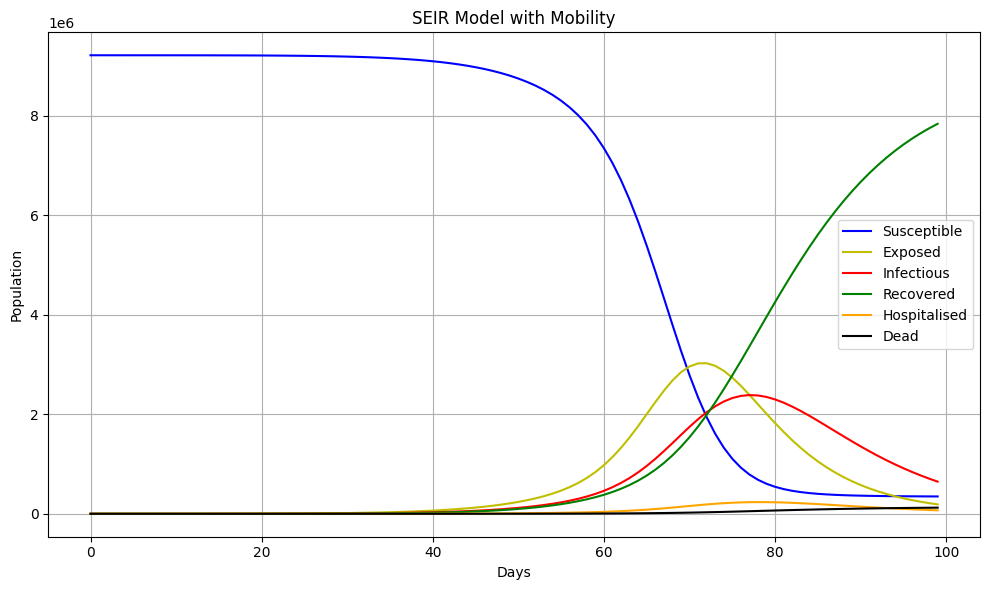

In [58]:
def fn_plot_SEIRHD(t, result):
    """
    This function plots the outputs of the SEIRHD model

    Inputs:
    t: The array containing the array of timestamps over which the model is evaluated
    result: The array containing the populations of all grids for all compartments of the model

    Output:
    None
    """

    # Extract S, E, I, R values from the results
    S = result[:, 0:x].sum(axis=1)
    E = result[:, x:2*x].sum(axis=1)
    I = result[:, 2*x:3*x].sum(axis=1)
    R = result[:, 3*x:4*x].sum(axis=1)
    H = result[:, 4*x:5*x].sum(axis=1)
    D = result[:, 5*x:].sum(axis=1)

    # Plotting the results
    plt.figure(figsize=(10, 6))

    # Summing over all regions to get the total values
    plt.plot(t, S, 'b', label='Susceptible')
    plt.plot(t, E, 'y', label='Exposed')
    plt.plot(t, I, 'r', label='Infectious')
    plt.plot(t, R, 'g', label='Recovered')
    plt.plot(t, H, 'orange', label='Hospitalised')
    plt.plot(t, D, 'black', label='Dead')

    plt.title('SEIR Model with Mobility')
    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

fn_plot_SEIRHD(t, res_test)

In [59]:
S = res_test[:, 0:x]
E = res_test[:, x:2*x]
I = res_test[:, 2*x:3*x]
R = res_test[:, 3*x:4*x]
H = res_test[:, 4*x:5*x]
D = res_test[:, 5*x:]

r_idx = 49
N - round(sum([S[r_idx].sum() , E[r_idx].sum() , I[r_idx].sum() , R[r_idx].sum() , H[r_idx].sum() , D[r_idx].sum() ]))

0

# 7. Real World COVID-19 data for London in 2020

#### Let's restrict the simulation to about 1 year (365 days) starting from 2020-02-03 (first infected case reported - sample taken).

i.e. From 2020-02-03 till 2021-02-03

In [60]:
# Base URL for the API
BASE_URL = "https://api.coronavirus.data.gov.uk/v1/data"
var_start_date = '2020-01-01'
var_areaName = 'london'
var_areaType = 'region'

endpoint = (
        f'{BASE_URL}?'
        f'filters=areaType={var_areaType};areaName={var_areaName}&;date={var_start_date}"'
        'structure={"date":"date","newCases": "newFirstEpisodesBySpecimenDate", "cumulativeCases": "cumCasesBySpecimenDate", "cumulativeDeaths": "cumDeaths28DaysByDeathDate", "newDeaths": "newWeeklyNsoDeathsByRegDate", "dailyHospitalised":"covidOccupiedMVBeds"}'
)
#newCasesBySpecimenDate
#newCasesByPublishDate
#newFirstEpisodesBySpecimenDate

In [61]:
print(N)
# Average incubation period for COVID-19 (assumed to be 5 days)
p = 5
# Duration after which we assume an individual has recovered (e.g., 14 days)
recovery_duration = 14

api_data = fn_get_COVID19_London_data(endpoint)
dates, S_vec, E_vec, I_vec, I_daily , R_vec, H_vec, D_vec, D_daily_vec = fn_generateSEIRHD_data(api_data, N, p , recovery_duration)

9212791


In [62]:
df_all_cases_data = pd.DataFrame({'date':dates, 'S': S_vec, 'E':E_vec, 'I_cumulative': I_vec,
                                     'I_daily': I_daily, 'R': R_vec, 'H' : H_vec, 'D_cumulative': D_vec,
                                     'D_daily': D_daily_vec})
df_all_cases_data['date'] = pd.to_datetime(df_all_cases_data['date'])
df_all_cases_data.index = df_all_cases_data['date']
df_all_cases_data

date        S    E  I_cumulative  I_daily   R  H  \
date                                                                
2020-02-03 2020-02-03  9212785    5             1        1   0  0   
2020-02-04 2020-02-04  9212791    0             1        0   0  0   
2020-02-05 2020-02-05  9212791    0             1        0   0  0   
2020-02-06 2020-02-06  9212791    0             1        0   0  0   
2020-02-07 2020-02-07  9212791    0             1        0   0  0   
...               ...      ...  ...           ...      ...  .. ..   
2023-08-24 2023-08-24  9212261  400       3165195       80  50  0   
2023-08-25 2023-08-25  9212276  390       3165315       78  47  0   
2023-08-26 2023-08-26  9212396  285       3165419       57  53  0   
2023-08-27 2023-08-27  9212410  265       3165511       53  63  0   
2023-08-28 2023-08-28  9212509  170       3165575       34  78  0   

            D_cumulative  D_daily  
date                               
2020-02-03             0        0  
2020-02-04             0        0  
2020-02-05             0        0  
2020-02-06             0        0  
2020-02-07             0        0  
...                  ...      ...  
2023-08-24             0        0  
2023-08-25             0        0  
2023-08-26             0        0  
2023-08-27             0        0  
2023-08-28             0        0  

[1303 rows x 9 columns]

### Display important metrics on the COVID-19 Metrics Dataset

In [63]:
df_all_cases_data.describe()

S              E  I_cumulative       I_daily             R  \
count  1.303000e+03    1303.000000  1.303000e+03   1303.000000   1303.000000   
mean   9.197264e+06   11276.331543  1.661818e+06   2255.266309   1975.362241   
std    2.870805e+04   21107.154154  1.292035e+06   4221.430831   4145.278011   
min    8.981896e+06       0.000000  1.000000e+00      0.000000  -2722.000000   
25%    9.193744e+06     885.000000  3.338395e+05    177.000000     46.000000   
50%    9.209557e+06    2515.000000  1.264857e+06    503.000000    315.000000   
75%    9.211857e+06   13630.000000  3.074396e+06   2726.000000   2483.500000   
max    9.213653e+06  168935.000000  3.165575e+06  33787.000000  33505.000000   

            H  D_cumulative      D_daily  
count  1303.0   1303.000000  1303.000000  
mean      0.0  14692.051420    19.943208  
std       0.0   7379.253316   120.311564  
min       0.0      0.000000     0.000000  
25%       0.0   6515.000000     0.000000  
50%       0.0  16465.000000     0.000000  
75%       0.0  20986.500000     0.000000  
max       0.0  23448.000000  1818.000000

### Total Deaths so far due to COVID-19

In [64]:
df_all_cases_data['D_cumulative'].max()

23448

### Maximum number of daily infections till date

In [65]:
df_all_cases_data[df_all_cases_data['I_daily']==df_all_cases_data['I_daily'].max()]

date        S       E  I_cumulative  I_daily      R  H  \
date                                                                      
2021-12-29 2021-12-29  8981896  168935       1904233    33787  28173  0   

            D_cumulative  D_daily  
date                               
2021-12-29         17690        0

### Maximum number of daily deaths till date

In [66]:
df_all_cases_data[df_all_cases_data['D_daily']==df_all_cases_data['D_daily'].max()]

date        S     E  I_cumulative  I_daily     R  H  \
date                                                                   
2020-04-17 2020-04-17  9209202  2885         22648      577 -1691  0   

            D_cumulative  D_daily  
date                               
2020-04-17          4437     1818

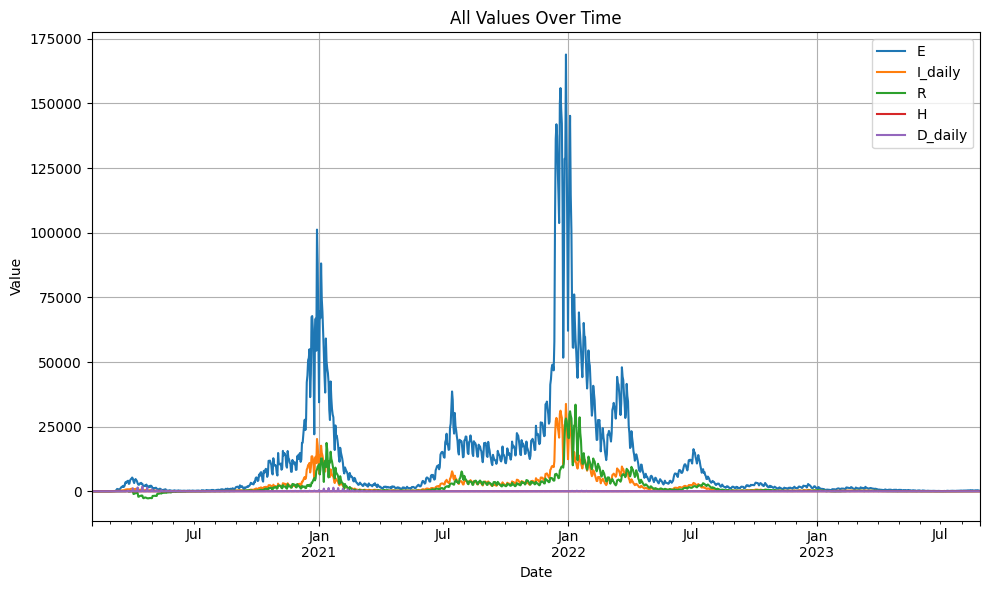

In [67]:
plt.figure(figsize=(10, 6))
for column in df_all_cases_data.columns:
    if column not in ['date', 'S', 'I_cumulative', 'D_cumulative']:
        df_all_cases_data[column].plot(label=column)

plt.title('All Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [68]:
dates_n = [i for i, _ in enumerate(dates)]
date2idx = {date:i for i, date in enumerate(dates)}
idx2date = {i:date for i, date in enumerate(dates)}
print(dates_n[:5])

[0, 1, 2, 3, 4]


In [69]:
#Lockdown 1
lockdown1_s_date = "2020-03-23"
lockdown1_e_date = "2020-07-04"
#Lockdown 2
lockdown2_s_date = "2020-11-05"
lockdown2_e_date = "2020-12-02"
#Lockdown 3
lockdown3_s_date = "2021-01-06"
lockdown3_e_date = "2021-03-08"

#Timelines of the COVID-19 Infection waves
#The day is not accurate
#The dates below merely reflect the approx month of COVID-19 infection
wave1_s_date = "2020-03-01"
wave1_peak_date = "2020-04-01"

wave2_s_date = "2020-09-01"
wave2_peak_date = "2021-01-01"

wave3_s_date = "2021-05-01"
wave3_peak_date = "2021-07-01"

wave4_s_date = "2021-12-01"
wave4_peak_date = "2021-12-28"


s1_s_date = "2020-02-03"
s1_e_date = "2020-08-15"

s2_s_date = "2020-08-15"
s2_e_date = "2021-05-01"

s3_s_date = "2021-05-01"
s3_e_date = "2022-04-01"

s4_s_date = "2022-04-01"
s4_e_date = "2022-12-01"

s5_s_date = "2022-12-01"
s6_e_date = "2022-07-01"

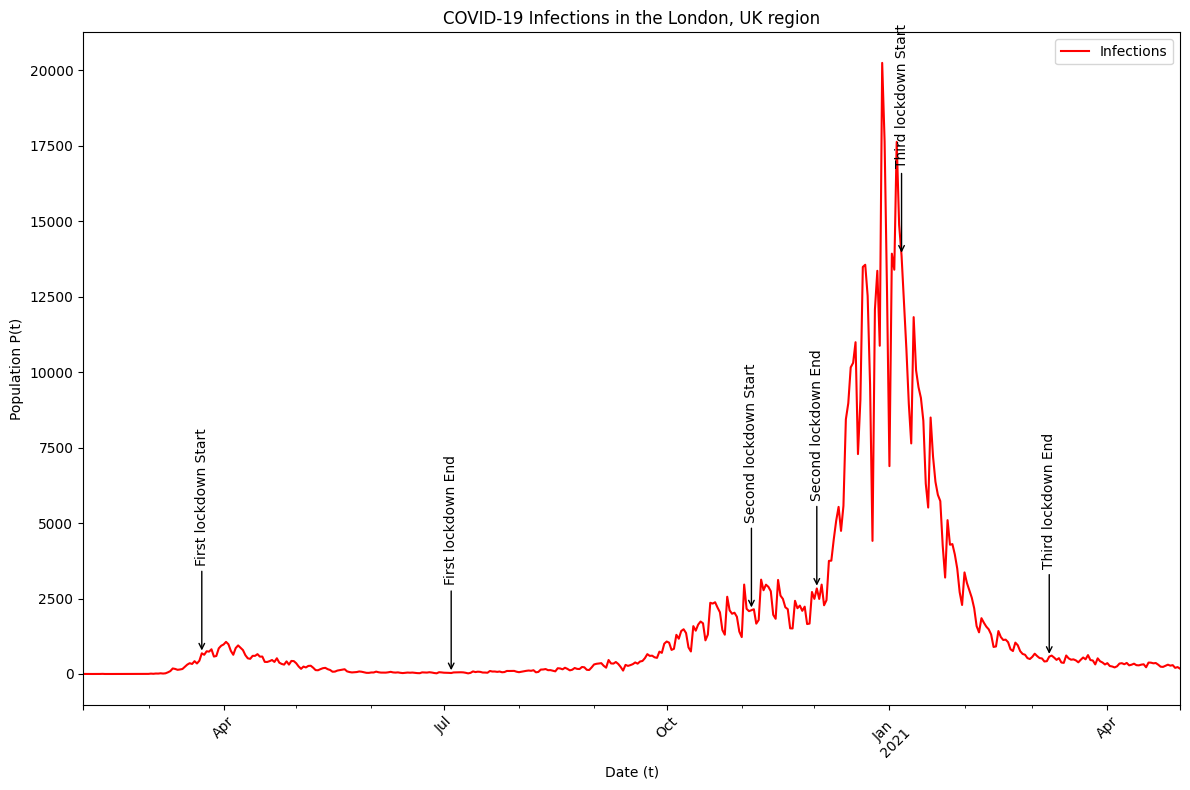

In [70]:
#train on daily data
I_cases = I_daily.copy()
D_cases = D_daily_vec.copy()

df_cases = pd.DataFrame({'date':dates,'infections':I_cases})

#Filter out data after the third stage
df_cases = df_cases[df_cases['date']<=s3_s_date]

df_cases['date'] = pd.to_datetime(df_cases['date'])
fig = df_cases.plot( x='date' , y='infections', c='r', label='Infections', figsize=(12,8))
ax = plt.gca()
plt.xlabel('Date (t)')
plt.ylabel("Population P(t)")

#First Lockdown
y1_value_start = df_cases[df_cases['date']==lockdown1_s_date]['infections'].values[0]
y1_value_end = df_cases[df_cases['date']==lockdown1_e_date]['infections'].values[0]
ax.annotate('First lockdown Start', (lockdown1_s_date , y1_value_start), xytext=(lockdown1_s_date, y1_value_start + 3000),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            ha='center', rotation=90 )
ax.annotate('First lockdown End', (lockdown1_e_date , y1_value_end), xytext=(lockdown1_e_date, y1_value_end + 3000),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            ha='center', rotation=90 )


#Second Lockdown
y2_value_start = df_cases[df_cases['date']==lockdown2_s_date]['infections'].values[0]
y2_value_end = df_cases[df_cases['date']==lockdown2_e_date]['infections'].values[0]
ax.annotate('Second lockdown Start', (lockdown2_s_date , y2_value_start), xytext=(lockdown2_s_date, y2_value_start + 3000),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            ha='center', rotation=90 )
ax.annotate('Second lockdown End', (lockdown2_e_date , y2_value_end), xytext=(lockdown2_e_date, y2_value_end + 3000),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            ha='center', rotation=90 )

#Third Lockdown
y3_value_start = df_cases[df_cases['date']==lockdown3_s_date]['infections'].values[0]
y3_value_end = df_cases[df_cases['date']==lockdown3_e_date]['infections'].values[0]
ax.annotate('Third lockdown Start', (lockdown3_s_date , y3_value_start), xytext=(lockdown3_s_date, y3_value_start + 3000),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            ha='center', rotation=90 )
ax.annotate('Third lockdown End', (lockdown3_e_date , y3_value_end), xytext=(lockdown3_e_date, y3_value_end + 3000),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            ha='center', rotation=90 )


plt.title('COVID-19 Infections in the London, UK region')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

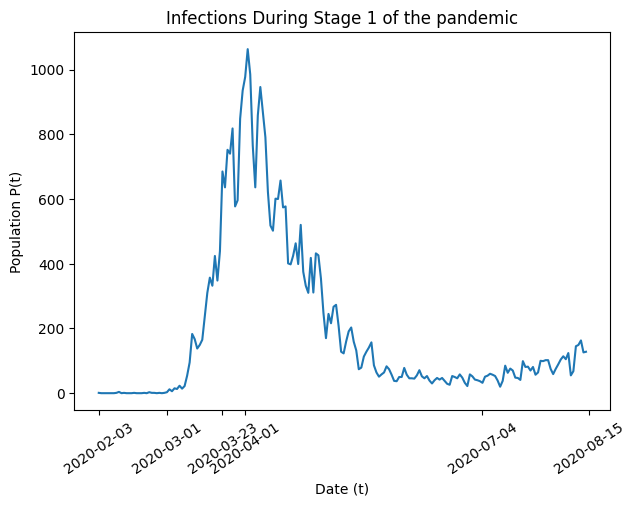

In [71]:
s1_start = date2idx[s1_s_date]
s1_end = date2idx[s1_e_date]

wave1_start = date2idx[wave1_s_date]
lockdown1_start = date2idx[lockdown1_s_date]
wave1_peak = date2idx[wave1_peak_date]
lockdown1_end = date2idx[lockdown1_e_date]

plt.xticks(rotation=34)
plt.xticks([s1_start, wave1_start, lockdown1_start, wave1_peak, lockdown1_end, s1_end], [s1_s_date, wave1_s_date, lockdown1_s_date, wave1_peak_date, lockdown1_e_date, s1_e_date])
plt.tight_layout()
plt.plot(dates[s1_start:s1_end], I_cases[s1_start:s1_end], '-')
plt.xlabel('Date (t)')
plt.ylabel("Population P(t)")
plt.title('Infections During Stage 1 of the pandemic')
plt.show()

#Train on daily data
yinf_stage1 = I_cases[s1_start:s1_end]
ydead_stage1 = D_cases[s1_start:s1_end]
xdata_stage1 = dates_n[s1_start:s1_end]
yinf_stage1 = np.array(yinf_stage1, dtype='float')
ydead_stage1 = np.array(ydead_stage1, dtype='float')
xdata_stage1 = np.array(xdata_stage1, dtype='float')

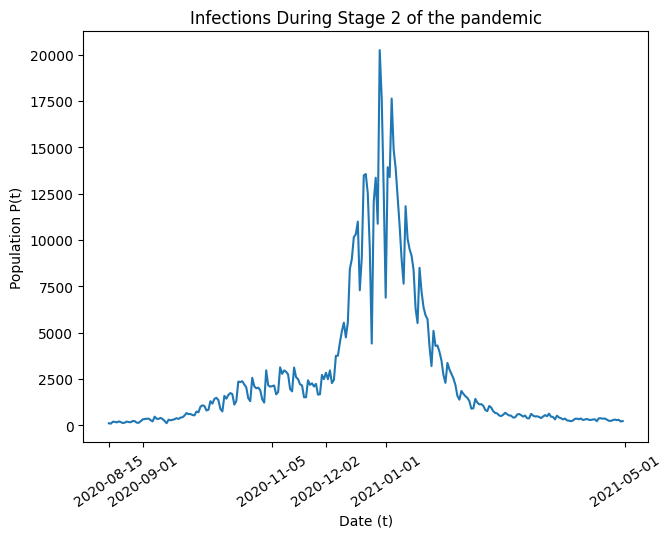

In [72]:
s2_start = date2idx[s2_s_date]
s2_end = date2idx[s2_e_date]

wave2_start = date2idx[wave2_s_date]
lockdown2_start = date2idx[lockdown2_s_date]
wave2_peak = date2idx[wave2_peak_date]
lockdown2_end = date2idx[lockdown2_e_date]

wave3_start = date2idx[wave3_s_date]
wave3_peak = date2idx[wave3_peak_date]
lockdown3_start = date2idx[lockdown3_s_date]

lockdown3_end = date2idx[lockdown3_e_date]

plt.xticks(rotation=34)
plt.tight_layout()
#plt.plot(dates[s2_start:s2_end], I_cases[s2_start:s2_end], '-')

x_values = list(range(s2_start, s2_end))
plt.plot(x_values, I_cases[s2_start:s2_end], '-')
plt.xticks([s2_start, wave2_start, lockdown2_start, wave2_peak, lockdown2_end, s2_end], [s2_s_date, wave2_s_date, lockdown2_s_date, wave2_peak_date, lockdown2_e_date, s2_e_date])
plt.xlabel('Date (t)')
plt.ylabel("Population P(t)")
plt.title('Infections During Stage 2 of the pandemic')
plt.show()


#Train on daily data
yinf_stage2 = I_cases[s2_start:s2_end]
ydead_stage2 = D_cases[s2_start:s2_end]
xdata_stage2 = dates_n[s2_start:s2_end]
yinf_stage2 = np.array(yinf_stage2, dtype='float')
ydead_stage2 = np.array(ydead_stage2, dtype='float')
xdata_stage2 = np.array(xdata_stage2, dtype='float')

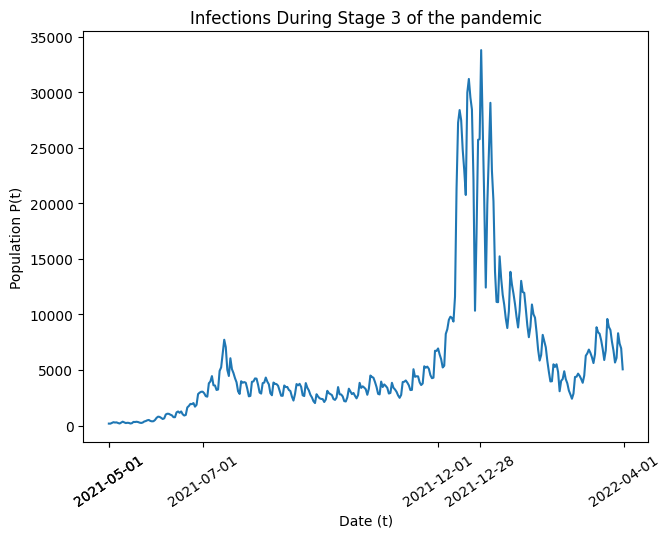

In [73]:
s3_start = date2idx[s3_s_date]
s3_end = date2idx[s3_e_date]

wave3_start = date2idx[wave3_s_date]
lockdown3_start = date2idx[lockdown3_s_date]
wave3_peak = date2idx[wave3_peak_date]
lockdown3_end = date2idx[lockdown3_e_date]

wave4_start = date2idx[wave4_s_date]
wave4_peak = date2idx[wave4_peak_date]

#Train on daily data
yinf_stage3 = I_cases[s3_start:s3_end]
ydead_stage3 = D_cases[s3_start:s3_end]
xdata_stage3 = dates_n[s3_start:s3_end]
yinf_stage3 = np.array(yinf_stage3, dtype='float')
ydead_stage3 = np.array(ydead_stage3, dtype='float')
xdata_stage3 = np.array(xdata_stage3, dtype='float')

plt.xticks(rotation=34)
plt.tight_layout()
#plt.plot(dates[s3_start:lockdown3_end], I_cases[s3_start:lockdown3_end], '-')
x_values = list(range(s3_start, s3_end))
plt.plot(x_values, yinf_stage3, '-')
plt.xticks([s3_start, wave3_start, wave3_peak,  wave4_start, wave4_peak, s3_end], [s3_s_date,wave3_s_date, wave3_peak_date, wave4_s_date, wave4_peak_date , s3_e_date])
plt.xlabel('Date (t)')
plt.ylabel("Population P(t)")
plt.title('Infections During Stage 3 of the pandemic')
plt.show()

In [74]:
times = np.linspace(0, len(xdata_stage1), len(xdata_stage1))
S0, E0, I0, R0, H0, D0 = fn_setInitialConditions(gdf_polygons_3857_populated, initial_inf=1, initial_inf_index=initialInd, initial_exp=100 )

In [75]:
def fn_fitSEIRHD_mobility_combined(xdata,  beta_initial, beta_lockdown, beta_end, k1, t1, k2, t2,  sigma, gamma, rho, delta, mu, gamma_H, r_I_to_H ):
    """
    xdata: The array containing the set of timesteps over which the model is to be fit.
    beta_initial: Initial value of the transmission parameter - beta before the start of the lockdown
    beta_lockdown: Transmission Rate during the lockdown stages.
    beta_end: The transmission rate parameter after the lifting of the intervention.
    k1: decides the gradient of the curve/ tranision from
    t2: timestep when intervention is introduced
    sigma: Rate of infection
    gamma: Rate of recovery
    rho: Rate of mobility
    delta: Rate of hospitalisation
    mu: Fatality rate of COVID-19
    gamma_H: Rate of recovery for hospitalised individuals
    r_I_to_H: Probability of Infected individuals moving to Hospitalised compartment

    Outputs:
    result: The array containing the population of the Infected and Dead compartments

    """
    results_SEIRHD_mobility = odeint(fn_seirhd_mobility_model, y0, xdata, args=( beta_initial, beta_lockdown, beta_end, k1, t1, k2, t2,  sigma, gamma, rho, delta, mu, gamma_H, r_I_to_H))
    I = results_SEIRHD_mobility[:, 2*x:3*x]
    D = results_SEIRHD_mobility[:, 5*x:]
    I = I.sum(axis=1)
    D = D.sum(axis=1)
    return np.concatenate([I, D])


def fn_fitSEIRHD_baseline_combined(xdata,  beta_initial, beta_lockdown, beta_end, k1, t1, k2, t2,  sigma, gamma, delta, mu, gamma_H, r_I_to_H ):
    """
    xdata: The array containing the set of timesteps over which the model is to be fit.
    beta_initial: Initial value of the transmission parameter - beta before the start of the lockdown
    beta_lockdown: Transmission Rate during the lockdown stages.
    beta_end: The transmission rate parameter after the lifting of the intervention.
    k1: decides the gradient of the curve/ tranision from
    t2: timestep when intervention is introduced
    sigma: Rate of infection
    gamma: Rate of recovery
    delta: Rate of hospitalisation
    mu: Fatality rate of COVID-19
    gamma_H: Rate of recovery for hospitalised individuals
    r_I_to_H: Probability of Infected individuals moving to Hospitalised compartment

    Outputs:
    result: The array containing the population of the Infected and Dead compartments

    """
    results_SEIRHD_mobility = odeint(fn_seirhd_baseline, y0, xdata, args=( beta_initial, beta_lockdown, beta_end, k1, t1, k2, t2, sigma, gamma, delta, mu, gamma_H, r_I_to_H))
    I = results_SEIRHD_mobility[:, 2*x:3*x]
    D = results_SEIRHD_mobility[:, 5*x:]
    I = I.sum(axis=1)
    D = D.sum(axis=1)
    return np.concatenate([I, D])


def fn_fitSEIRHD_Infected(xdata,  beta_initial, beta_lockdown, beta_end, k1, t1, k2, t2,  sigma, gamma, rho, delta, mu, gamma_H, r_I_to_H ):
    """
    xdata: The array containing the set of timesteps over which the model is to be fit.
    beta_initial: Initial value of the transmission parameter - beta before the start of the lockdown
    beta_lockdown: Transmission Rate during the lockdown stages.
    beta_end: The transmission rate parameter after the lifting of the intervention.
    k1: decides the gradient of the curve/ tranision from
    t2: timestep when intervention is introduced
    sigma: Rate of infection
    gamma: Rate of recovery
    rho: Rate of mobility
    delta: Rate of hospitalisation
    mu: Fatality rate of COVID-19
    gamma_H: Rate of recovery for hospitalised individuals
    r_I_to_H: Probability of Infected individuals moving to Hospitalised compartment

    Outputs:
    result: The array containing the population of the Infected and Dead compartments

    """
    I = odeint(fn_seirhd_mobility_model, y0, xdata, args=( beta_initial, beta_lockdown, beta_end, k1, t1, k2, t2,  sigma, gamma, rho, delta, mu, gamma_H, r_I_to_H))[:, 2*x:3*x]
    return I.sum(axis=1)

def fn_fitSEIRHD_Dead(xdata,  beta_initial, beta_lockdown, beta_end, k1, t1, k2, t2,  sigma, gamma, rho, delta, mu, gamma_H , r_I_to_H):
    """
    xdata: The array containing the set of timesteps over which the model is to be fit.
    beta_initial: Initial value of the transmission parameter - beta before the start of the lockdown
    beta_lockdown: Transmission Rate during the lockdown stages.
    beta_end: The transmission rate parameter after the lifting of the intervention.
    k1: decides the gradient of the curve/ tranision from
    t2: timestep when intervention is introduced
    sigma: Rate of infection
    gamma: Rate of recovery
    rho: Rate of mobility
    delta: Rate of hospitalisation
    mu: Fatality rate of COVID-19
    gamma_H: Rate of recovery for hospitalised individuals
    r_I_to_H: Probability of Infected individuals moving to Hospitalised compartment

    Outputs:
    result: The array containing the population of the Infected and Dead compartments

    """
    D = odeint(fn_seirhd_mobility_model, y0, xdata, args=( beta_initial, beta_lockdown, beta_end, k1, t1, k2, t2,  sigma, gamma, rho, delta, mu, gamma_H, r_I_to_H))[:, 5*x:]
    return D.sum(axis=1)

def fn_fitSEIRHD_Infected_cv(xdata, beta_initial, beta_lockdown, beta_end, k1, t1, k2, t2,  sigma, gamma, delta, mu, gamma_H, r_I_to_H ):
    """
    xdata: The array containing the set of timesteps over which the model is to be fit.
    beta_initial: Initial value of the transmission parameter - beta before the start of the lockdown
    beta_lockdown: Transmission Rate during the lockdown stages.
    beta_end: The transmission rate parameter after the lifting of the intervention.
    k1: decides the gradient of the curve/ tranision from
    t2: timestep when intervention is introduced
    sigma: Rate of infection
    gamma: Rate of recovery
    delta: Rate of hospitalisation
    mu: Fatality rate of COVID-19
    gamma_H: Rate of recovery for hospitalised individuals
    r_I_to_H: Probability of Infected individuals moving to Hospitalised compartment

    Outputs:
    result: The array containing the population of the Infected and Dead compartments

    """
    I = odeint(fn_seirhd_baseline, y0, xdata, args=(beta_initial, beta_lockdown, beta_end, k1, t1, k2, t2,  sigma, gamma, delta, mu, gamma_H, r_I_to_H))[:, 2*x:3*x]
    return I.sum(axis=1)

def fn_fitSEIRHD_Dead_cv(xdata,  beta_initial, beta_lockdown, beta_end, k1, t1, k2, t2,  sigma, gamma, delta, mu, gamma_H, r_I_to_H ):
    """
    xdata: The array containing the set of timesteps over which the model is to be fit.
    beta_initial: Initial value of the transmission parameter - beta before the start of the lockdown
    beta_lockdown: Transmission Rate during the lockdown stages.
    beta_end: The transmission rate parameter after the lifting of the intervention.
    k1: decides the gradient of the curve/ tranision from
    t2: timestep when intervention is introduced
    sigma: Rate of infection
    gamma: Rate of recovery
    delta: Rate of hospitalisation
    mu: Fatality rate of COVID-19
    gamma_H: Rate of recovery for hospitalised individuals
    r_I_to_H: Probability of Infected individuals moving to Hospitalised compartment

    Outputs:
    result: The array containing the population of the Infected and Dead compartments

    """
    D = odeint(fn_seirhd_baseline, y0, xdata, args=( beta_initial, beta_lockdown, beta_end, k1, t1, k2, t2,  sigma, gamma, delta, mu, gamma_H, r_I_to_H))[:, 5*x:]
    return D.sum(axis=1)



## 7.2. Curve Fitting of SEIRHD model without mobility

### 7.2.1. First Stage

In [76]:
alpha_const, rho_const = 1, 1

In [135]:
def fn_moving_average(data, window_size):
    """
    This function calculates the moving average for each element in the array over the specified window_size

    Inputs:
    data: This is the input array for which the moving average is to be calculated
    window_size: the size of the window over which the average is supposed to be calculated

    Output:
    array: the output array is of same size and contains the moving average for each element with the same size.
    """
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')


# Function to annotate the intervention points (t1 and t2)
def fn_annotate_point(ax, x, y, label):
    """
    This function annotates the given point with the specified label

    Inputs:
    ax: The axis object of the matplotlib plot to which the annotatation has to be added
    x: The x coordinate of the point
    y: The y coordinate of the point
    label: The text which has to be marked for the given point
    """
    ax.annotate(label, xy=(x, y), xytext=(x, y + 50),  # position of the text (with a slight offset in the y direction)
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                horizontalalignment='center')

def fn_format_xlabel(value, tick_number):
    """
    This function takes the x-axis value and replaces it with appropriate date value

    Inputs:
    value: This contains the value of the timestep on the axis
    tick_number: index of the tick on the axis-axis
    """
    # Convert index to int (in case it's float)
    idx = int(value)

    # Return the corresponding date or an empty string if the index is out of range
    return idx2date.get(idx, '')


def fn_fitModelToStage(xdata, yinfected, lowerbounds, upperbounds, init_estimate, stage, windowSize=5, drawPlots = True):
  """
  This function takes the model and fits it to the supplied infected data

  Inputs:
  xdata: The array containing the timesteps of over which the model is to be fitted
  yinfected: The actual observed data to which the model is to be fitted
  lowerbounds: The lowerbounds of all the parameters associated with the model
  upperbounds: The array containing the upper bounds of all the parameters associated with the model
  init_estimate: The array containing all the initial estimates of the parameters in the model
  stage: The stage of the pandemic under investigation
  windowSize: The window size for calculating the smoothed average of the infected data
  drawPlots: Either true or false to indicate if the plot needs to be drawn or not

  Outputs:
  None
  """
  #Smoothening the observed data for easier fitting
  if drawPlots:
    yinfected_smoothed = fn_moving_average(yinfected, windowSize)
    plt.plot(xdata, yinfected_smoothed, '-', c='r', label='Smoothened Infected')
    plt.plot(xdata, yinfected, 'o', c='b', label='Original Infected')
    plt.xlabel('Time (days)')
    plt.ylabel('Number of cases')
    plt.title(f'Actual Infected Curve vs Smoothened for Stage {stage}')
    plt.legend()
    plt.show()

  params, covariance = curve_fit(fn_fitSEIRHD_Infected_cv, xdata, yinfected_smoothed, bounds=(lowerbounds, upperbounds),  p0=tuple(init_estimate ))  # Adjust bounds as needed
  beta_initial_fit, beta_lockdown_fit, beta_end_fit, k1_fit, t1_fit, k2_fit, t2_fit, sigma_fit,  gamma_fit , delta_fit, mu_fit, gamma_H_fit, r_I_to_H_fit = params

  if drawPlots:
    #Infected data from SEIRHD model with no mobility
    infected_no_mobility_model = fn_fitSEIRHD_Infected_cv(xdata, beta_initial_fit, beta_lockdown_fit, beta_end_fit, k1_fit, t1_fit, k2_fit, t2_fit, sigma_fit , gamma_fit, delta_fit, mu_fit, gamma_H_fit, r_I_to_H_fit)
    #Infected data from spatial SEIRHD model with mobility
    infected_with_mobility_spatial_model = fn_fitSEIRHD_Infected( xdata, beta_initial_fit, beta_lockdown_fit, beta_end_fit, k1_fit, t1_fit, k2_fit, t2_fit, sigma_fit,  gamma_fit, rho_const , delta_fit, mu_fit, gamma_H_fit, r_I_to_H_fit)

    len_train_data = len(xdata)

    plt.figure(figsize=(15, 12))
    ax1 = plt.subplot(2, 2, 1)
    plt.plot(xdata, yinfected, 'o', c='g', label='Observed Infected')
    plt.plot(xdata, yinfected_smoothed, '-', c='r', label='Smoothed Infected')
    plt.plot(xdata, infected_no_mobility_model , c='b', label='Fitted Infected')
    fn_annotate_point(ax1, t1_fit, yinfected_smoothed[int(t1_fit)], f'Interventions Start = {idx2date[int(t1_fit)]}')
    if int(t2_fit) < len_train_data + int(xdata[0]):
      fn_annotate_point(ax1, t2_fit, yinfected_smoothed[int(t2_fit)], f'Intervention End = {idx2date[int(t2_fit)]}')
    # Set the custom formatter for the x-axis
    ax1.xaxis.set_major_formatter(FuncFormatter(fn_format_xlabel))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")
    plt.title(f'Curve Fitting using curve_fit - SEIRHD Baseline for Stage {stage}')
    plt.axvline(len(xdata))
    plt.xlabel('Time (days)')
    plt.ylabel('Number of cases')
    plt.legend()
    #plt.show()

    ax2 = plt.subplot(2, 2, 2)
    plt.plot(xdata, infected_no_mobility_model, '--', c='r', label='Fitted Infected (no mobility)')
    plt.plot(xdata, infected_with_mobility_spatial_model, '-', c='b', label='Fitted Infected (mobility)')
    ax2.xaxis.set_major_formatter(FuncFormatter(fn_format_xlabel))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")
    fn_annotate_point(ax2, t1_fit, yinfected_smoothed[int(t1_fit)], f'Interventions Start = {idx2date[int(t1_fit)]}')
    if int(t2_fit) < len_train_data + int(xdata[0]):
      fn_annotate_point(ax2, t2_fit, yinfected_smoothed[int(t2_fit)], f'Intervention End = {idx2date[int(t2_fit)]}')
    plt.plot(xdata, yinfected_smoothed, 'o' , c='y', label='Smoothed Data')
    plt.xlabel('Time (days)')
    plt.ylabel('Number of cases')
    plt.legend()
    plt.title(f'Infection Curve Fitted to SEIRHD Models (Baseline and Mobility) for Stage {stage}')
    #plt.show()


    beta_t_list = []
    time_iter_list = np.linspace(0, len(xdata)-1, len(xdata)*2)
    for i in time_iter_list:
      beta_t_list.append(fn_beta_t(i, beta_initial_fit, beta_lockdown_fit, beta_end_fit, k1_fit, t1_fit, k2_fit, t2_fit))
    ax3 = plt.subplot(2, 2, 3)
    plt.plot(time_iter_list, beta_t_list)
    ax3.xaxis.set_major_formatter(FuncFormatter(fn_format_xlabel))
    plt.setp(ax3.get_xticklabels(), rotation=45, ha="right")
    plt.title('Varying Beta over time')
    plt.xlabel('Time (days)')
    plt.ylabel('Beta')
    plt.tight_layout()
    plt.show()

  return params, covariance



def fn_SEIRHD_predictions(xtrain_data, ytrain_data , xvalidation_data, yvalidation_data, params):
  """
  The function takes the takes the training data and the estimated parameters and outputs the predictions of the SEIRHD model without and with mobility for the validation data

  Inputs:
  xtrain_data: The array containing the time intervals to which the model is to be trained
  ytrain_data: The array containing the actual observed data
  xvalidation_data: The time interval for the validation dataset
  yvalidaiton_data: The actual observed values in the prediction data
  params: The array containing the actual estimated parameters for the model

  Output:
  no_mobility_predictions_only: The array containing the predictions of the baseline SEIRHD model (with no mobility)
  mobility_predictions_only: The array containing the predictions of the spatial mobility SEIRHD model
  """
  beta_initial_pred, beta_lockdown_pred, beta_end_pred, k1_pred, t1_pred, k2_pred, t2_pred,  gamma_pred, sigma_pred , delta_pred, mu_pred, gamma_H_pred, r_I_to_H_pred = params
  train_len, validation_len = len(xtrain_data) , len(ytrain_data)
  xdata_input = np.concatenate([xtrain_data, xvalidation_data])
  rho_pred = 1
  no_mobility_model_predictions = fn_fitSEIRHD_Infected_cv(xdata_input, beta_initial_pred, beta_lockdown_pred, beta_end_pred, k1_pred, t1_pred, k2_pred, t2_pred,  gamma_pred, sigma_pred , delta_pred, mu_pred, gamma_H_pred, r_I_to_H_pred )
  mobility_model_predictions = fn_fitSEIRHD_Infected( xdata_input, beta_initial_pred, beta_lockdown_pred, beta_end_pred, k1_pred, t1_pred, k2_pred, t2_pred,  gamma_pred, sigma_pred, rho_pred , delta_pred, mu_pred, gamma_H_pred, r_I_to_H_pred)

  no_mobility_predictions_only = no_mobility_model_predictions[train_len:train_len+validation_len]
  mobility_predictions_only = mobility_model_predictions[train_len:train_len+validation_len]

  return no_mobility_predictions_only, mobility_predictions_only



def fn_getInitialConditionsToNextStage(stage_params, xdata, y0, rho_init=1):
  """
  This function produces the initial conditions for the next stage of a model given the params that fit to the last stage of a model.
  This replicates the first stage using the given parameters and uses the compartment populations at the last time as the initial conditions of the next stage

  Inputs:
  stage_params: The array containing the best fit parameter values of the model
  xdata: The array containing the time intervals that weere used to estimate the previous model
  y0: The intial conditions during the start of the model
  rho_init: The initial mobility parameter. (default is 1)

  Outputs:
  new_y0: The array containing the new initial conditions for the model.
  """
  beta_initial_fit, beta_lockdown_fit, beta_end_fit, k1_fit, t1_fit, k2_fit, t2_fit,  gamma_fit, sigma_fit , delta_fit, mu_fit, gamma_H_fit, r_I_to_H_fit = stage_params
  #seirhd_model_fitted = odeint(fn_seirhd_baseline, y0, xdata, args=(beta_initial_fit, beta_lockdown_fit, beta_end_fit, k1_fit, t1_fit, k2_fit, t2_fit,  gamma_fit, sigma_fit , delta_fit, mu_fit, gamma_H_fit, r_I_to_H_fit))
  seirhd_model_fitted = odeint(fn_seirhd_baseline, y0, xdata, args=(beta_initial_fit, beta_lockdown_fit, beta_end_fit, k1_fit, t1_fit, k2_fit, t2_fit,  gamma_fit, sigma_fit , delta_fit, mu_fit, gamma_H_fit, r_I_to_H_fit))
  last_index = -1
  S_end = seirhd_model_fitted[last_index, 0:x]
  E_end = seirhd_model_fitted[last_index, x:2*x]
  I_end = seirhd_model_fitted[last_index, 2*x:3*x]
  R_end = seirhd_model_fitted[last_index, 3*x:4*x]
  H_end = seirhd_model_fitted[last_index, 4*x:5*x]
  D_end = seirhd_model_fitted[last_index, 5*x:]

  print(E_end)

  new_y0 = np.concatenate([S_end, E_end, I_end, R_end, H_end, D_end])
  return new_y0

In [136]:
def fn_time_series_cross_validation(xdata , ydata , initial_train_size, validation_size, fit_function, predict_function, lowerbounds, upperbounds, initial_params, stage, windowSize = 5, drawPlots = False):
    """
    This function implements time series cross validation on the dataset.

    xdata: The array containing the time steps for the entire dataset
    ydata: The entire infected dataset for the stage
    initial_train_size: initial size of the training dataset
    validation_size: Size of the validation dataset (this is also the duration of each validation stage)
    fit_function: The function that will be used for fitting the data.
    predict_function: The function that will be used for gathering predictions
    lowerbounds: The lowerbounds of all the parameters associated with the model
    upperbounds: The array containing the upper bounds of all the parameters associated with the model
    init_estimate: The array containing all the initial estimates of the parameters in the model
    stage: The stage of the pandemic under investigation
    windowSize: The window size for calculating the smoothed average of the infected data
    drawPlots: Either true or false to indicate if the plot needs to be drawn or not

    Outputs:
    errors_no_mobility: The validation error produced by the baseline SEIRHD model with no mobility
    errors_with_mobility: The validation error produced by the SEIRHD model with mobility.

    """
    errors_no_mobility = []
    errors_with_mobility = []
    train_end = initial_train_size

    iter = 0

    while train_end + validation_size <= len(ydata):
        # Split data into training and validation sets
        xtrain_data = xdata[:train_end]
        ytrain_data = ydata[:train_end]

        print(iter)
        iter = iter + 1

        xvalidation_data = xdata[train_end:train_end+validation_size]
        yvalidation_data = ydata[train_end:train_end+validation_size]

        # Fit the model on the training data
        params, _ = fit_function(xtrain_data, ytrain_data , lowerbounds, upperbounds, initial_params, stage, windowSize, drawPlots)

        # Predict on the validation data
        predictions_no_mobility, predictions_with_mobility = predict_function(xtrain_data, ytrain_data , xvalidation_data, yvalidation_data, params)

        # Calculate the error (e.g., MAE)
        #error_no_mobility = np.mean(np.abs(predictions_no_mobility - yvalidation_data))
        #errors_no_mobility.append(error_no_mobility)

        #error_with_mobility = np.mean(np.abs(predictions_with_mobility - yvalidation_data))
        #errors_with_mobility.append(error_with_mobility)

        #Calculate Root Mean Square Error
        error_no_mobility = np.sqrt(np.mean((predictions_no_mobility - yvalidation_data)**2))
        errors_no_mobility.append(error_no_mobility)

        error_with_mobility = np.sqrt(np.mean((predictions_with_mobility - yvalidation_data)**2))
        errors_with_mobility.append(error_with_mobility)


        # Roll the window forward
        train_end += validation_size

    return errors_no_mobility, errors_with_mobility

In [137]:
#lowerbounds_stage1 = [1, 0.5, 2, 0.01, lockdown1_start-5, 0.01, lockdown1_end-5,  0.01, 0.001, 0.01, 0.01, 0.01, 0.01]
#upperbounds_stage1 = [10, 15, 11, 1, lockdown1_start+5, 1, lockdown1_end+5 , 0.5, 1, 0.4, 0.4, 1, 1]

#lowerbounds_stage1 = [0.01, 0.0, 0.01, 0.01, lockdown1_start-5, 0.01, lockdown1_end-5,  0.01, 0.001, 0.01, 0.01, 0.01, 0.01]
#upperbounds_stage1 = [1, 1, 1, 1, lockdown1_start+5, 1, lockdown1_end+5 , 0.5, 1, 0.4, 0.4, 1, 1]
#init_estimate_stage1 = [1, 0.01, 1, 0.4,  lockdown1_start, 0.5, lockdown1_end,  0.5, 0.49, 0.39, 0.39, 0.9, 0.01 ]
#params_stage1, covariance_stage1 = fn_fitModelToStage(xdata_stage1, yinf_stage1, lowerbounds_stage1, upperbounds_stage1, init_estimate_stage1, 1)

### Set the values of the model parameters

In [138]:
#Duration of Infection - D
min_D = 6.5
max_D = 13.4

#Incubation period - T_incub
min_T_incub_period = 2
max_T_incub_period = 14

#Mortality Rate
min_mort = 0.01
max_mort = 0.2

#hospitalisation Rate
min_hosp_rate = 0.05
max_hosp_rate = 0.30

#R0 - Reproductive Number
min_R0 = 0.5
max_R0 = 10

In [139]:
#beta
min_beta = 0.01
max_beta = 1.0


#gamma
min_sigma = 1 / max_D #gamma = 1/D or 1/T_inf
max_sigma = 1 / min_D

#sigma
min_gamma = 1/max_T_incub_period #sigma = 1/T_incub
max_gamma = 1/min_T_incub_period

#delta
min_delta = min_hosp_rate
max_delta = max_hosp_rate

#mu
min_mu = 0.0
max_mu = 0.2

#gamma_H
min_gamma_H = 1 / max_D
max_gamma_H = 1 / min_D
max_gamma_H = 0.99

#r_I_to_H
min_r_I_to_H = 0.01
max_r_I_to_H = 0.5

In [140]:
print(f"min beta: {min_beta}\tmax beta: {max_beta}")
print(f"min gamma: {min_gamma}\tmax gamma: {max_gamma}")
print(f"min sigma: {min_sigma}\tmax sigma: {max_sigma}")
print(f"min delta: {min_delta}\tmax delta: {max_delta}")
print(f"min mu: {min_mu}\tmax mu: {max_mu}")
print(f"min gamma_H: {min_gamma_H}\tmax gamma_H: {max_gamma_H}")
print(f"min r_I_to_H: {min_r_I_to_H}\tmax r_I_to_H: {max_r_I_to_H}")

min beta: 0.01	max beta: 1.0
min gamma: 0.07142857142857142	max gamma: 0.5
min sigma: 0.07462686567164178	max sigma: 0.15384615384615385
min delta: 0.05	max delta: 0.3
min mu: 0.0	max mu: 0.2
min gamma_H: 0.07462686567164178	max gamma_H: 0.99
min r_I_to_H: 0.01	max r_I_to_H: 0.5


In [141]:
len(xdata_stage1)

194

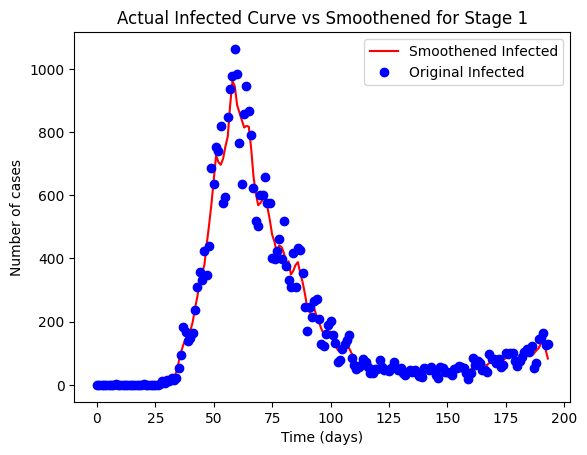

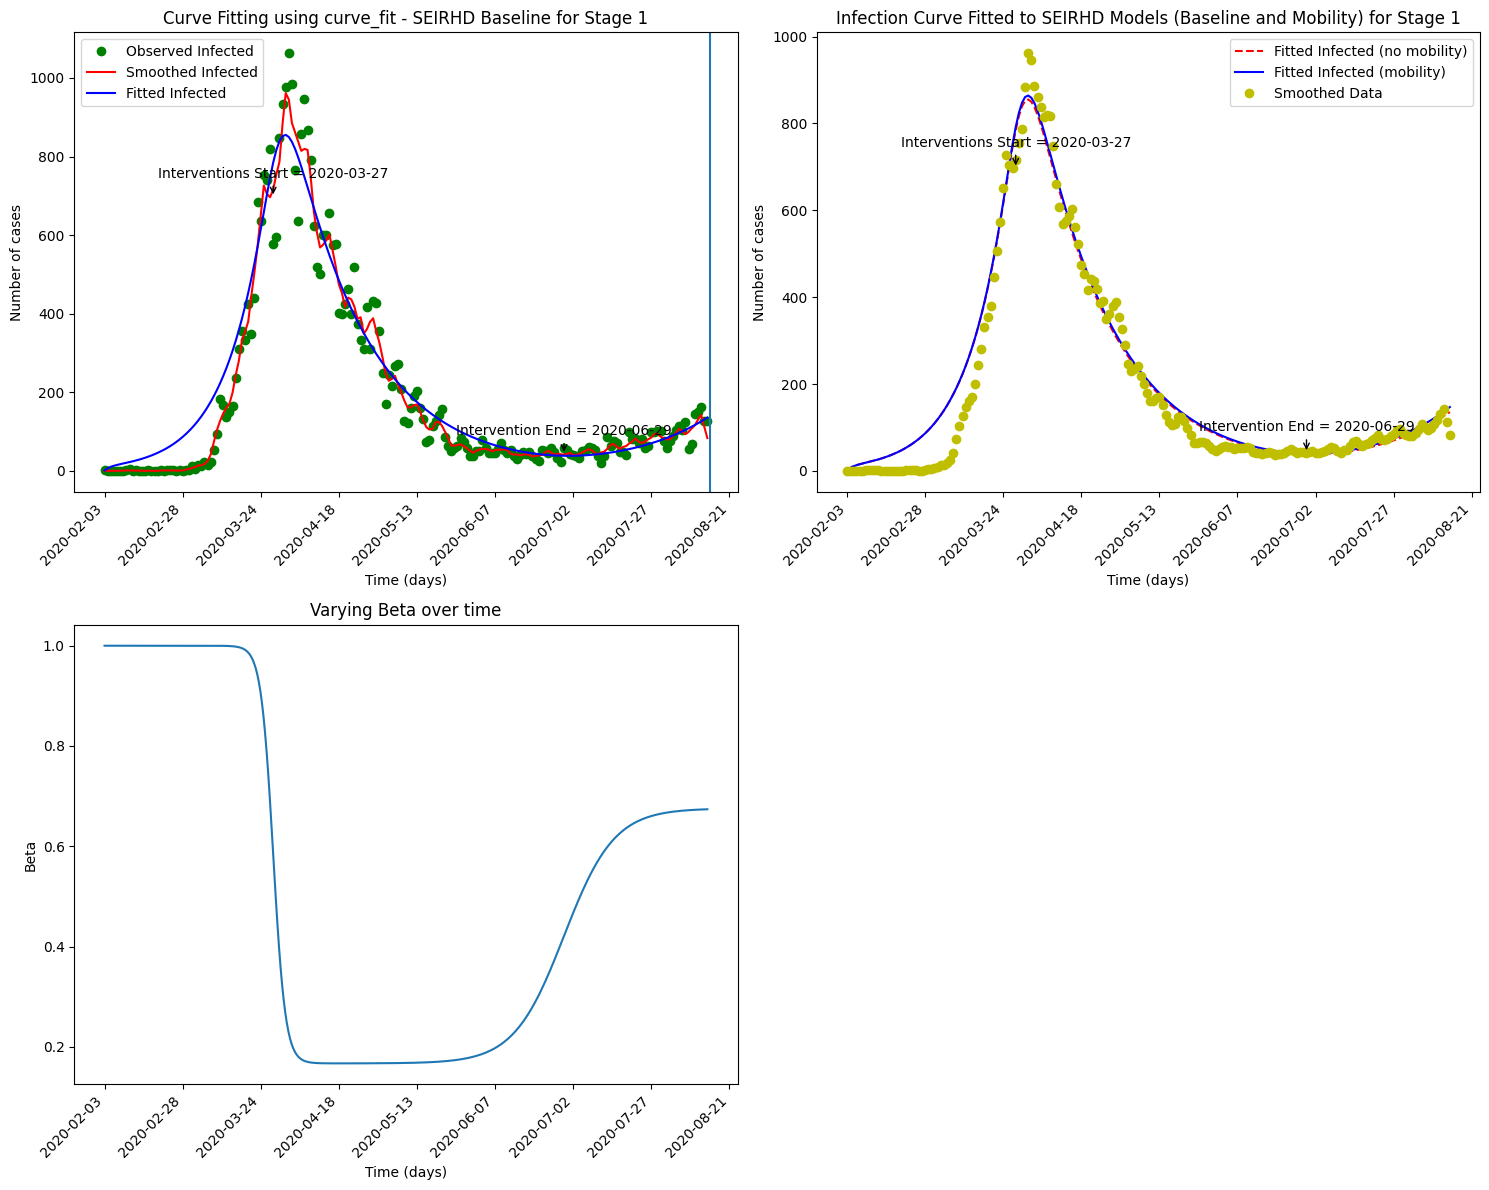

In [142]:
#lowerbounds_stage1 = [1, 0.5, 2, 0.01, lockdown1_start-5, 0.01, lockdown1_end-5,  min_sigma, min_gamma, min_delta, min_mu, min_gamma_H, min_r_I_to_H]
#upperbounds_stage1 = [10, 15, 11, 1, lockdown1_start+5, 1, lockdown1_end+5 , max_sigma. max_gamma, max_delta, max_mu, max_gamma_H, max_r_I_to_H]

lowerbounds_stage1 = [min_beta, min_beta, min_beta, 0.01, lockdown1_start-5, 0.01, lockdown1_end-5, min_sigma, min_gamma, min_delta, min_mu, min_gamma_H, min_r_I_to_H]
upperbounds_stage1 = [max_beta, max_beta, max_beta, 1, lockdown1_start+5, 1, lockdown1_end+5 ,max_sigma, max_gamma, max_delta, max_mu, max_gamma_H, max_r_I_to_H]
init_estimate_stage1 = [1, 0.1, 1, 0.7,  lockdown1_start, 0.5, lockdown1_end,  0.1, 0.2, 0.07, 0.2, 0.4, 0.01 ]
params_stage1, covariance_stage1 = fn_fitModelToStage(xdata_stage1, yinf_stage1, lowerbounds_stage1, upperbounds_stage1, init_estimate_stage1, 1)

In [143]:
no_mobility_err , mobility_err = fn_time_series_cross_validation(xdata_stage1, yinf_stage1, 125, 7 , fn_fitModelToStage, fn_SEIRHD_predictions, lowerbounds_stage1, upperbounds_stage1, init_estimate_stage1, 1, 5, True)

Output hidden; open in https://colab.research.google.com to view.

In [144]:
print(sum(no_mobility_err) , sum(mobility_err))

161.64096559214033 173.43147478672367


In [145]:
[float(x) for x in params_stage1]

[0.9999489073393688,
 0.16695358786647915,
 0.6754561038200575,
 0.5119243274262052,
 53.998087680537665,
 0.12452135519320953,
 147.1040307773962,
 0.07462686599278526,
 0.4094775703113082,
 0.22810103914465937,
 0.07234677819906525,
 0.9158122002600158,
 0.020549756202352408]

In [146]:
y0_start_of_pandemic = y0.copy()
y0_start_of_pandemic

array([ 290813,  529794,   65432,  310866, 1141004,  754291,  184762,
            69,  655551, 1570414, 1275004,  340780,  152586,  987584,
        560070,  106803,   72892,  166530,   47105,     340,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,     100,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       1,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,     

In [147]:
#y0_stage2 = fn_getInitialConditionsToNextStage(params_stage1, xdata_stage1, y0)

In [148]:
#y0 = y0_stage2.copy()

### 7.2.2. Second Stage

In [149]:
#len(xdata_stage2), len(yinf_stage2)

In [150]:
#rho_const = 1xdata_stage2
#lowerbounds_stage2 = [min_beta, min_beta, min_beta, 0.01, lockdown2_end-10, 0.01, lockdown3_end-10,  min_sigma, min_gamma, min_delta, min_mu, min_gamma_H, min_r_I_to_H]
#upperbounds_stage2 = [max_beta, max_beta, max_beta, 1, lockdown2_end+10, 1, lockdown3_end+10 ,max_sigma, max_gamma, max_delta, max_mu, max_gamma_H, max_r_I_to_H]
#init_estimate_stage2 = [1, 0.4, 1, 0.8,  lockdown2_end, 0.1, lockdown3_end,   0.5, 0.1, 0.39, 0.39, 0.4, 0.01 ]
#params_stage2, covariance_stage2 = fn_fitModelToStage(, yinf_stage2, lowerbounds_stage2, upperbounds_stage2, init_estimate_stage2, 2, 2)

### 7.2.3. Curve Fitting for the third stage

In [151]:
#y0_stage3 = fn_getInitialConditionsToNextStage(params_stage2, xdata_stage2, y0)

In [152]:
#y0 = y0_stage3.copy()

In [153]:
#en(xdata_stage2), len(yinf_stage2)

In [154]:
#rho_const = 1
#lowerbounds_stage3 = [min_beta, min_beta, min_beta, lockdown3_start-20, 0.01, lockdown3_end-20,  min_sigma, min_gamma, min_delta, min_mu, min_gamma_H, min_r_I_to_H]
#upperbounds_stage3 = [max_beta, max_beta, max_beta, 1, lockdown3_start+30, 1, lockdown3_end+40, max_sigma, max_gamma, max_delta, max_mu, max_gamma_H, max_r_I_to_H]
#init_estimate_stage3 = [1, 1, 1, 0.8,  lockdown3_start, 0.1, lockdown3_end,  0.2, 0.19, 0.19, 0.19, 0.9, 0.01 ]
#params_stage3, covariance_stage3 = fn_fitModelToStage(xdata_stage3, yinf_stage3, lowerbounds_stage3, upperbounds_stage3, init_estimate_stage3, 2)

## 7.3. Curve Fitting of SEIR model with mobility

In [155]:
#params, covariance = curve_fit(fn_fitSEIRHD_Infected, xdata_stage1, yinf_stage1, bounds=([min_beta, min_beta, min_beta, 0.01, lockdown1_start-5, 0.01, lockdown1_end-5, min_sigma.  min_gamma, rho_const-0.001, min_delta, min_mu, min_gamma_H, min_r_I_to_H], [max_beta, max_beta, max_beta, 1, lockdown1_start+5, 1, lockdown1_end+5 ,max_gamma, max_sigma, rho_const, max_delta, max_mu, max_gamma_H, max_r_I_to_H]), p0=(1, 0.1, 1, 0.7,  lockdown1_start, 0.5, lockdown1_end,  0.1, 0.39, 1, 0.39, 0.39, 0.4, 0.01  ))  # Adjust bounds as needed
#[float(x) for x in params]

In [156]:
#plt.plot(xdata_stage1, yinf_stage1, 'o', label='Observed Infected')
#plt.plot(xdata_stage1, fn_fitSEIRHD_Infected( xdata_stage1, beta_start_est, x0_est, k_est, beta_end_est, sigma_est, gamma_est, rho_const, delta_est, mu_est, gamma_H_est, r_I_to_H_est), label='Fitted Infected')
#plt.plot(xdata_stage1, ydead_stage1, '-', label='Observed Dead')
#plt.plot(xdata_stage1, fn_fitSEIRHD_Dead( xdata_stage1, beta_start_est, x0_est, k_est, beta_end_est, sigma_est, gamma_est, rho_const, delta_est, mu_est, gamma_H_est, r_I_to_H_est), label='Fitted Dead')
#plt.title('Curve Fitting for SEIRHD Model with mobility using curve_fit')
#plt.axvline(len(xdata_stage1))
#plt.legend()
#plt.show()

# 8. Sensitvity Analysis

## 8.1. Stage 1 of the pandemic

In [157]:
beta_initial_baseline, beta_lockdown_baseline, beta_end_baseline, k1_baseline, t1_baseline, k2_baseline, t2_baseline,  sigma_baseline, gamma_baseline , delta_baseline, mu_baseline, gamma_H_baseline, r_I_to_H_baseline = params_stage1
rho_baseline, alpha_baseline = 1, 1

In [158]:
# Baseline parameters
params_baseline = {
    'beta_initial': beta_initial_baseline,
    'beta_lockdown': beta_lockdown_baseline,
    'beta_end': beta_end_baseline,
    'k1': k1_baseline,
    't1': t1_baseline,
    'k2': k2_baseline,
    't2': t2_baseline,
    'sigma': sigma_baseline,
    'gamma': gamma_baseline,
    'rho': 1.0,
    'delta': delta_baseline,
    'mu': mu_baseline,
    'gamma_H': gamma_H_baseline,
    'r_I_to_H': r_I_to_H_baseline,
    'alpha': alpha_baseline
}
params_baseline

{'beta_initial': 0.9999489073393688,
 'beta_lockdown': 0.16695358786647915,
 'beta_end': 0.6754561038200575,
 'k1': 0.5119243274262052,
 't1': 53.998087680537665,
 'k2': 0.12452135519320953,
 't2': 147.1040307773962,
 'sigma': 0.07462686599278526,
 'gamma': 0.4094775703113082,
 'rho': 1.0,
 'delta': 0.22810103914465937,
 'mu': 0.07234677819906525,
 'gamma_H': 0.9158122002600158,
 'r_I_to_H': 0.020549756202352408,
 'alpha': 1}

In [159]:
params_min_bounds = {
    'beta_initial': min_beta,
    'beta_lockdown': min_beta,
    'beta_end': min_beta,
    'k1': 0.0,
    't1': 0,
    'k2': 0.0,
    't2': 1,
    'sigma': 0.0,
    'gamma': 0.0,
    'rho': 0.0,
    'delta': 0.0,
    'mu': 0.0,
    'gamma_H': 0.0,
    'r_I_to_H': 0.0,
    'alpha': 0.01
}

In [160]:
params_max_bounds = {
    'beta_initial': max_beta,
    'beta_lockdown': max_beta,
    'beta_end': max_beta,
    'k1': 1.0,
    't1': len(yinf_stage1)-1,
    'k2': 1.0,
    't2': len(yinf_stage1),
    'sigma': 1.0,
    'gamma': 1.0,
    'rho': 1.0,
    'delta': 1.0,
    'mu': 1.0,
    'gamma_H': 1.0,
    'r_I_to_H': 1.0,
    'alpha': 1.0
}

In [161]:
#Set the initial condition
y0 = y0_start_of_pandemic.copy()
y0

array([ 290813,  529794,   65432,  310866, 1141004,  754291,  184762,
            69,  655551, 1570414, 1275004,  340780,  152586,  987584,
        560070,  106803,   72892,  166530,   47105,     340,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,     100,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       1,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,     

In [162]:
params_baseline

{'beta_initial': 0.9999489073393688,
 'beta_lockdown': 0.16695358786647915,
 'beta_end': 0.6754561038200575,
 'k1': 0.5119243274262052,
 't1': 53.998087680537665,
 'k2': 0.12452135519320953,
 't2': 147.1040307773962,
 'sigma': 0.07462686599278526,
 'gamma': 0.4094775703113082,
 'rho': 1.0,
 'delta': 0.22810103914465937,
 'mu': 0.07234677819906525,
 'gamma_H': 0.9158122002600158,
 'r_I_to_H': 0.020549756202352408,
 'alpha': 1}

beta_initial
1
2
3
4
5
6
7
8
9
10


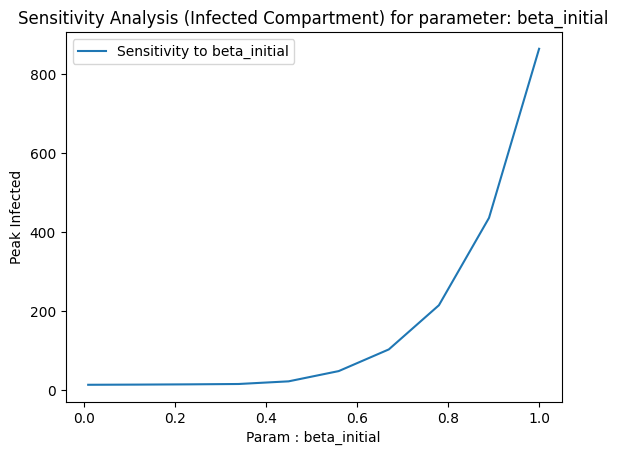

beta_lockdown
1
2
3
4
5
6
7
8
9
10


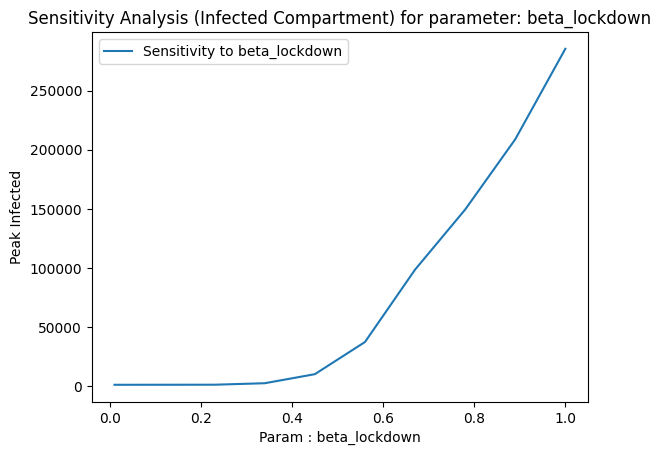

beta_end
1
2
3
4
5
6
7
8
9
10


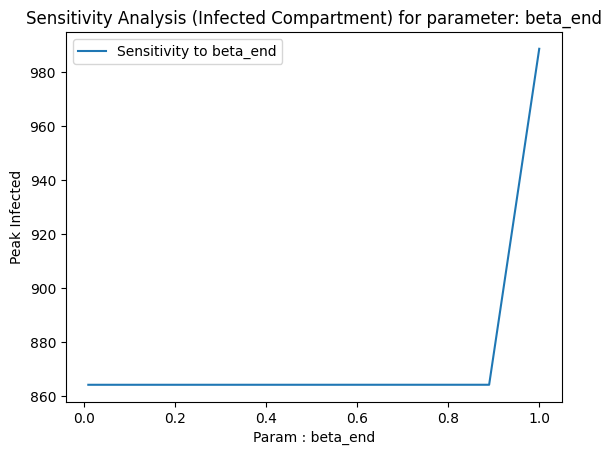

k1
1
2
3
4
5
6
7
8
9
10


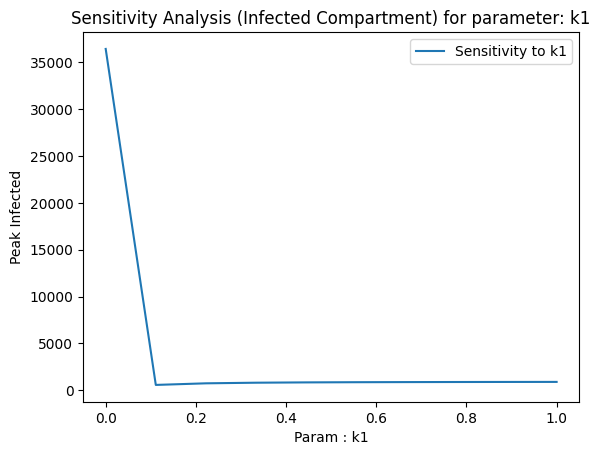

t1
1
2
3
4
5
6
7
8
9
10


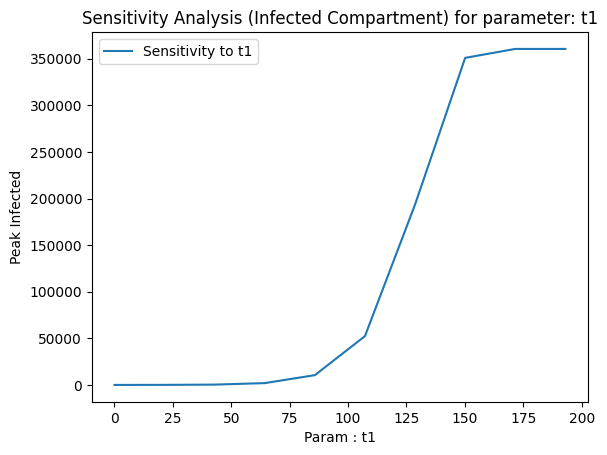

k2
1
2
3
4
5
6
7
8
9
10


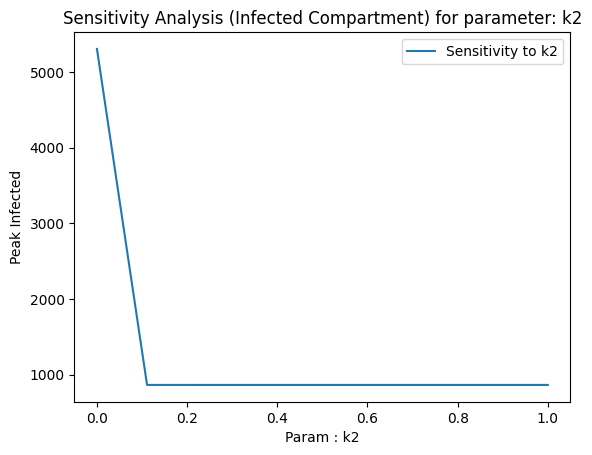

t2
1
2
3
4
5
6
7
8
9
10


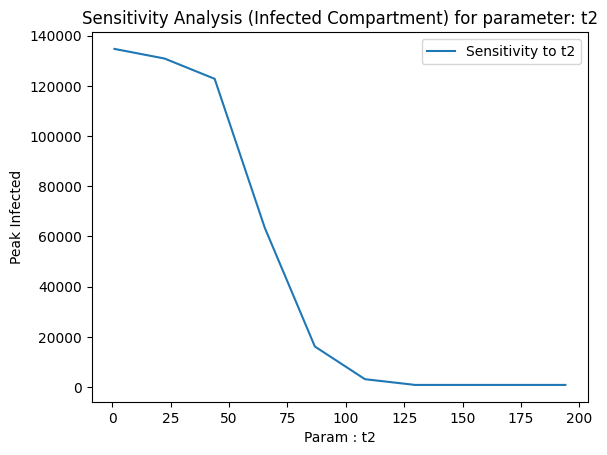

sigma
1
2
3
4
5
6
7
8
9
10


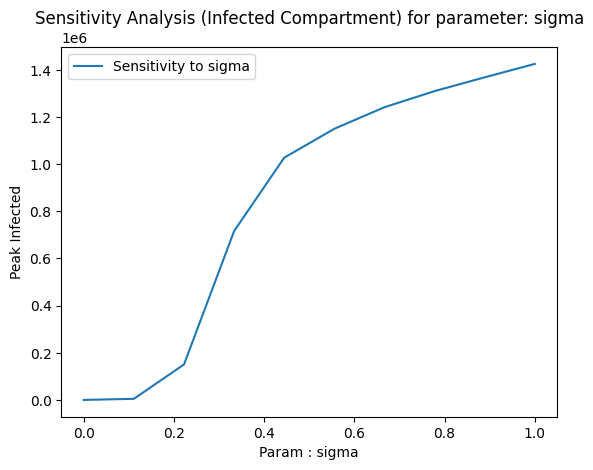

gamma
1
2
3
4
5
6
7
8
9
10


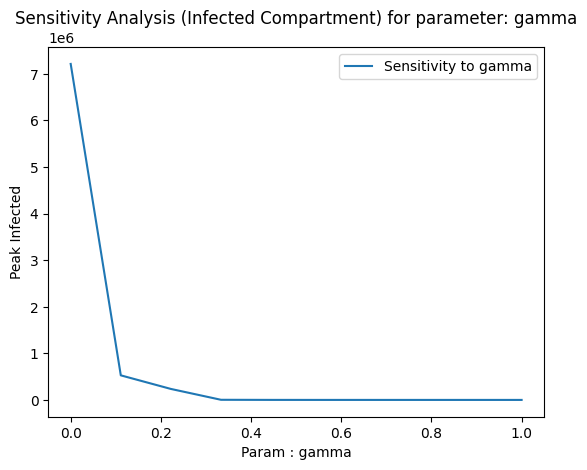

rho
1
2
3
4
5
6
7
8
9
10


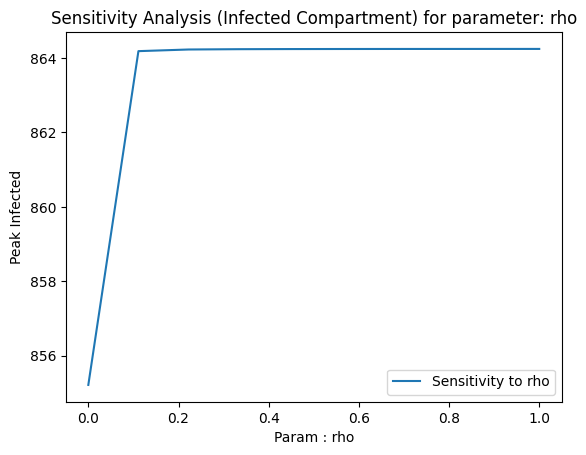

delta
1
2
3
4
5
6
7
8
9
10


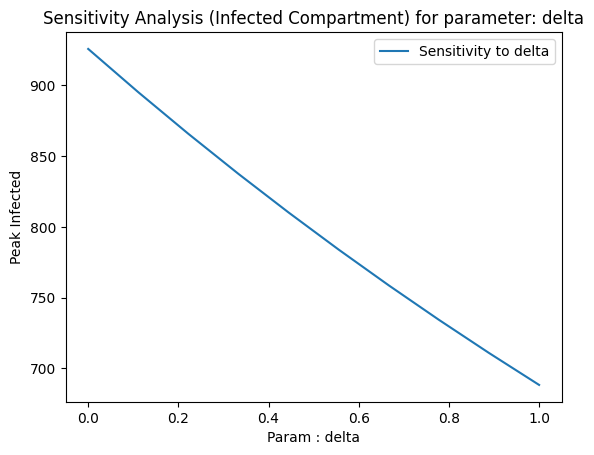

mu
1
2
3
4
5
6
7
8
9
10


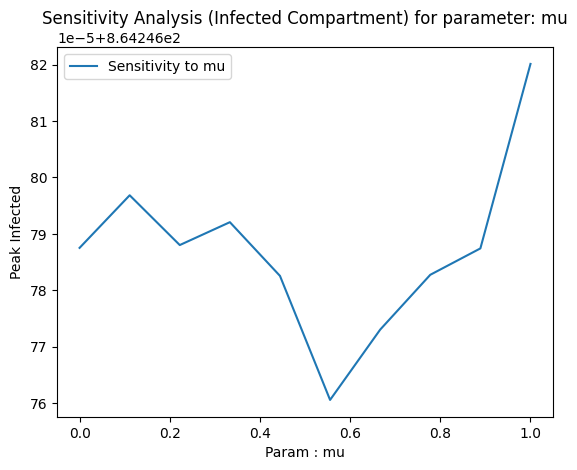

gamma_H
1
2
3
4
5
6
7
8
9
10


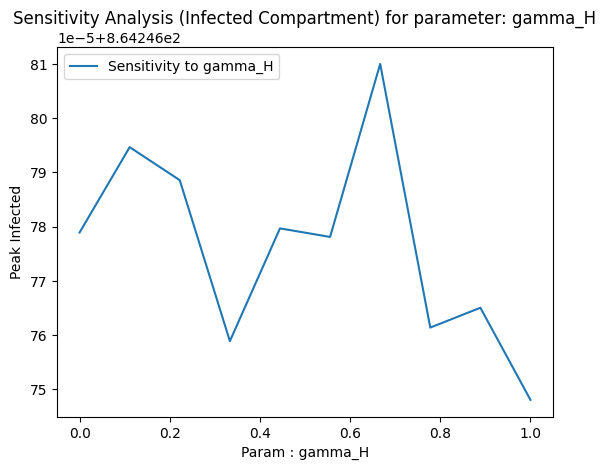

r_I_to_H
1
2
3
4
5
6
7
8
9
10


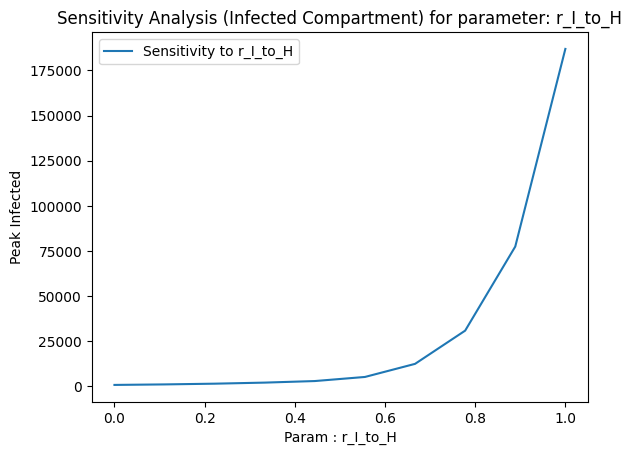

alpha
1
2
3
4
5
6
7
8
9
10


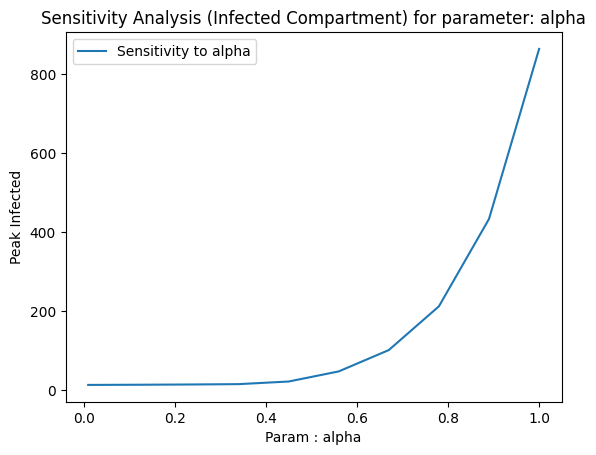

In [163]:
# Sensitivity analysis
for param, baseline_value in params_baseline.items():
    # Vary the parameter from its minimum to maximum value with 20 intervals
    values = np.linspace(params_min_bounds[param], params_max_bounds[param], 10)
    print(param)
    peak_infected = []
    iter = 0
    for value in values:
        iter = iter + 1
        print(iter)
        params_iter = params_baseline.copy()
        params_iter[param] = value

        #retrieve infected data from the SEIRHD mobility model results
        I = odeint(fn_seirhd_mobility_model, y0, xdata_stage1, args=(tuple(list(params_iter.values()))))[:, 2*x:3*x]
        I = I.sum(axis=1)


        peak_infected.append(max(I))

    # Plot the results
    plt.figure()
    plt.title(f'Sensitivity Analysis (Infected Compartment) for parameter: {param}')
    plt.plot(values, peak_infected, label=f'Sensitivity to {param}')
    plt.xlabel(f"Param : {param}")
    plt.ylabel('Peak Infected')
    plt.legend()
    plt.show()

# 9. Run simulations of different COVID-19 Non-pharmaceutical Intervention scenarios

In [164]:
params_baseline

{'beta_initial': 0.9999489073393688,
 'beta_lockdown': 0.16695358786647915,
 'beta_end': 0.6754561038200575,
 'k1': 0.5119243274262052,
 't1': 53.998087680537665,
 'k2': 0.12452135519320953,
 't2': 147.1040307773962,
 'sigma': 0.07462686599278526,
 'gamma': 0.4094775703113082,
 'rho': 1.0,
 'delta': 0.22810103914465937,
 'mu': 0.07234677819906525,
 'gamma_H': 0.9158122002600158,
 'r_I_to_H': 0.020549756202352408,
 'alpha': 1}

## 9.1. Actual Interventions (This will serve as the baseline to which all other models will be compared to)

In [165]:
#Result dictionary
res = {}

### The below chart contains very small numbers for all compartments except the Susceptible compartment. Hence we do not see any curves. However the model is working as expected.

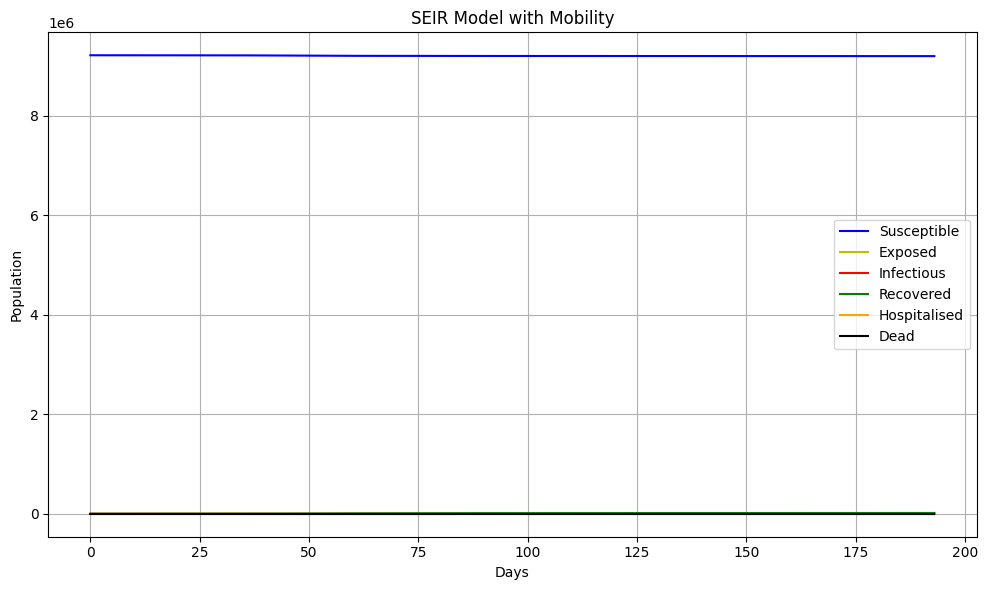

In [166]:
params_actual_intervention = params_baseline.copy()
res["actual_interventions"] = odeint(fn_seirhd_mobility_model, y0, xdata_stage1, args=(tuple(list(params_actual_intervention.values()))))
fn_plot_SEIRHD(xdata_stage1, res["actual_interventions"])

### Necessary function definitions for running the scenario simulations

In [200]:
def fn_calculate_doubling_time(data):
    """
    Function to calculate the doubling time for a given dataset.

    Inputs:
    data: The array containing the dataset for which doubling time is to be calculated.

    Outputs:
    Doubling time for the dataset.
    """
    doubling_times = []
    for i in range(1, len(data)):
        if data[i-1] > 0 and data[i] > data[i-1]:
            T_d = np.log(2) / (np.log(data[i] / data[i-1]))
            doubling_times.append(T_d)
        else:
            doubling_times.append(np.nan)
    return round(np.nanmean(doubling_times),2)



def fn_calculate_statistics(data, xdata):
    """
    This function is used to calculate the important metrics for the given dataset.

    Inputs:
    data: The array containing the dataset produced for each scenario
    xdata: The array containing the time intervals of the stage being tested

    Outputs:
    A dictionary containing the metrics for the input dataset.
    """
    return {
        'Peak Value': round(np.max(data), 2),
        'Time to Peak': xdata[np.argmax(data)],
        'Total Value at End': round(data[-1], 2),
        'Doubling Time': fn_calculate_doubling_time(data)
    }


# Function to annotate the intervention points (t1 and t2)
def fn_annotate_point(ax, x, y, label):
    """
    This function annotates the given point with the specified label

    Inputs:
    ax: The axis object of the matplotlib plot to which the annotatation has to be added
    x: The x coordinate of the point
    y: The y coordinate of the point
    label: The text which has to be marked for the given point
    """
    ax.annotate(label, xy=(x, y), xytext=(x, y+4),  # position of the text (with a slight offset in the y direction)
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                horizontalalignment='center')


def fn_annotate_interventions(ax, arr_scenario, t1, t2, xdata, len_xdata, intervention_lines=True):
  """
  Function to annotate the interventions on the Baseline vs 'Simulated Scenario' plots

  Inputs:
  ax: Axis of the plot to which the annotations need to be added
  arr_scenario: The relavant array of the compartment being plotted
  t1: Timestamp of the start of the intervention
  t2: Timestamp of the end of the intervention
  xdata: Array containing the timestamps for which the results are generated
  len_xdata: The length of the timestamp array (xdata)
  intervention_lines: Boolean value identifying if the plot requires the annotations to be plotted or not

  Outputs:
  None
  """
  if intervention_lines:
    ax.axvline(t1, linestyle='--', c='r', label='Intervention start')
    fn_annotate_point(ax, t1, arr_scenario[t1], f"Interventions Start = {idx2date[t1]}")
    if t2 < len_xdata + int(xdata[0]):
      if intervention_lines:
        ax.axvline(t2, linestyle='--', c='g', label='Intervention end')
        fn_annotate_point(ax, t2, arr_scenario[t2], f"Intervention End = {idx2date[t2]}")




def fn_plot_Baseline_VS_Scenarios(baseline_model_outputs, xdata, y_initial, params_dict, scenario, y_scale='linear', intervention_lines=True, baseline_scenario='Baseline'):
  """
  This function plots the outputs of the current scenario being modelled against the chosen baseline model
  baseline_model_outputs: The array containing the outputs of the baseline model (already calculated using odeint)
  xdata: The array containing the time intervals of the stage being tested
  y_initial: The initial conditions of the stage under consideration
  params_dict: The dictionary contains the estimated values for each parameter of the model
  scenario: The name of the scenario being tested
  y_scale: The scale of the y-axis for the graphs being plotted
  intervention_lines: A boolean value indicating if the time of intervention should be annotated on the plots
  baseline_scenario: The name of the baseline scenario.

  Outputs:
  None

  """
  S_baseline = baseline_model_outputs[:, 0:x].sum(axis=1)
  E_baseline = baseline_model_outputs[:, x:2*x].sum(axis=1)
  I_baseline = baseline_model_outputs[:, 2*x:3*x].sum(axis=1)
  R_baseline = baseline_model_outputs[:, 3*x:4*x].sum(axis=1)
  H_baseline = baseline_model_outputs[:, 4*x:5*x].sum(axis=1)
  D_baseline = baseline_model_outputs[:, 5*x:].sum(axis=1)


  scenario_model_outputs = odeint(fn_seirhd_mobility_model, y_initial, xdata, args=(tuple(list(params_dict.values()))))
  S_scenario = scenario_model_outputs[:, 0:x].sum(axis=1)
  E_scenario = scenario_model_outputs[:, x:2*x].sum(axis=1)
  I_scenario = scenario_model_outputs[:, 2*x:3*x].sum(axis=1)
  R_scenario = scenario_model_outputs[:, 3*x:4*x].sum(axis=1)
  H_scenario = scenario_model_outputs[:, 4*x:5*x].sum(axis=1)
  D_scenario = scenario_model_outputs[:, 5*x:].sum(axis=1)

  len_train_data = len(xdata)


  #Plotting S, E, I, R, D in different compartments

  #Susceptible Compartment
  plt.figure(figsize=(30, 30))
  ax1 = plt.subplot(3, 2, 1)
  plt.plot(xdata, S_baseline, 'o', linewidth=10, c='b' , label=f'{baseline_scenario} Susceptible')
  plt.plot(xdata, S_scenario , linewidth=10, c='r', label=f'{scenario} Susceptible')
  fn_annotate_interventions(ax1, S_scenario, int(params_dict['t1']), int(params_dict['t2']), xdata, len_train_data, intervention_lines=intervention_lines)
  ax1.xaxis.set_major_formatter(FuncFormatter(fn_format_xlabel))
  plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", weight='bold', fontsize=22)
  plt.setp(ax1.get_yticklabels(), weight='bold', fontsize=22)
  plt.title(f'Susceptible Curves - {baseline_scenario} vs. {scenario}', fontsize=22)
  plt.xlabel('Time (days)', fontsize=22)
  plt.ylabel('Number of cases', fontsize=22)
  plt.yscale(y_scale)
  plt.legend()


  #Exposed Compartment
  ax2 = plt.subplot(3, 2, 2)
  plt.plot(xdata, E_baseline, 'o',  linewidth=10, c='b' , label=f'{baseline_scenario} Exposed')
  plt.plot(xdata, E_scenario , linewidth=10, c='r' , label=f'{scenario} Exposed')
  fn_annotate_interventions(ax2, E_scenario, int(params_dict['t1']), int(params_dict['t2']), xdata, len_train_data, intervention_lines=intervention_lines)
  ax2.xaxis.set_major_formatter(FuncFormatter(fn_format_xlabel))
  plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", weight='bold', fontsize=22)
  plt.setp(ax2.get_yticklabels(), weight='bold', fontsize=22)
  plt.title(f'Exposed Curves - {baseline_scenario} vs. {scenario}', fontsize=22)
  plt.xlabel('Time (days)', fontsize=22)
  plt.ylabel('Number of cases', fontsize=22)
  plt.yscale(y_scale)
  plt.legend()


  #Infected Compartment
  ax3 = plt.subplot(3, 2, 3)
  plt.plot(xdata, I_baseline, 'o',  linewidth=10, c='b' , label=f'{baseline_scenario} Infected')
  plt.plot(xdata, I_scenario, linewidth=10, c='r' , label=f'{scenario} Infected')
  fn_annotate_interventions(ax3, I_scenario, int(params_dict['t1']), int(params_dict['t2']), xdata, len_train_data, intervention_lines=intervention_lines)
  ax3.xaxis.set_major_formatter(FuncFormatter(fn_format_xlabel))
  plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", weight='bold', fontsize=22)
  plt.setp(ax3.get_yticklabels(), weight='bold', fontsize=22)
  plt.title(f'Infected Curves - {baseline_scenario} vs. {scenario}', fontsize=22)
  plt.xlabel('Time (days)', fontsize=22)
  plt.ylabel('Number of cases', fontsize=22)
  plt.yscale(y_scale)
  plt.legend()


  #Recovered Compartment
  ax4 = plt.subplot(3, 2, 4)
  plt.plot(xdata, R_baseline, 'o',  linewidth=10, c='b' , label=f'{baseline_scenario} Recovered')
  plt.plot(xdata, R_scenario ,  linewidth=10, c='r' , label=f'{scenario} Recovered')
  fn_annotate_interventions(ax4, R_scenario, int(params_dict['t1']), int(params_dict['t2']), xdata, len_train_data, intervention_lines=intervention_lines)
  ax4.xaxis.set_major_formatter(FuncFormatter(fn_format_xlabel))
  plt.setp(ax4.get_xticklabels(), rotation=45, ha="right", weight='bold', fontsize=22)
  plt.setp(ax4.get_yticklabels(), weight='bold', fontsize=22)
  plt.title(f'Recovered Curves - {baseline_scenario} vs. {scenario}', fontsize=22)
  plt.xlabel('Time (days)', fontsize=22)
  plt.ylabel('Number of cases', fontsize=22)
  plt.yscale(y_scale)
  plt.legend()


  #Hospitalised Compartment
  ax5 = plt.subplot(3, 2, 5)
  plt.plot(xdata, H_baseline, 'o',  linewidth=10, c='b', label=f'{baseline_scenario} Hospitalised')
  plt.plot(xdata, H_scenario ,  linewidth=10, c='r', label=f'{scenario} Hospitalised')
  fn_annotate_interventions(ax5, H_scenario, int(params_dict['t1']), int(params_dict['t2']), xdata, len_train_data, intervention_lines=intervention_lines)
  ax5.xaxis.set_major_formatter(FuncFormatter(fn_format_xlabel))
  plt.setp(ax5.get_xticklabels(), rotation=45, ha="right", weight='bold', fontsize=22)
  plt.setp(ax5.get_yticklabels(), weight='bold', fontsize=22)
  plt.title(f'Hospitalised Curves - {baseline_scenario} vs. {scenario}', fontsize=22)
  plt.xlabel('Time (days)', fontsize=22)
  plt.ylabel('Number of cases', fontsize=22)
  plt.yscale(y_scale)
  plt.legend()



  #Dead Compartment
  ax6 = plt.subplot(3, 2, 6)
  plt.plot(xdata, D_baseline, 'o',  linewidth=10, c='b', label=f'{baseline_scenario} Dead')
  plt.plot(xdata, D_scenario ,  linewidth=10, c='r', label=f'{scenario} Dead')
  fn_annotate_interventions(ax6, D_scenario, int(params_dict['t1']), int(params_dict['t2']), xdata, len_train_data, intervention_lines=intervention_lines)
  ax6.xaxis.set_major_formatter(FuncFormatter(fn_format_xlabel))
  plt.setp(ax6.get_xticklabels(), rotation=45, ha="right", weight='bold', fontsize=22)
  plt.setp(ax6.get_yticklabels(), weight='bold', fontsize=22)
  plt.title(f'Dead Curves - {baseline_scenario} vs. {scenario}', fontsize=22)
  plt.xlabel('Time (days)', fontsize=22)
  plt.ylabel('Number of cases', fontsize=22)
  plt.yscale(y_scale)
  plt.legend()
  plt.tight_layout()
  plt.show()



  #Plot the tables showing key metrics to measure disease spraead
  titles = ['Exposed', 'Infected', 'Hospitalized', 'Dead']
  baseline_values = [E_baseline, I_baseline, H_baseline, D_baseline]
  scenario_values = [E_scenario, I_scenario, H_scenario, D_scenario]

  # Calculate statistics
  baseline_stats_data = []
  scenario_stats_data = []
  for title, baseline, scenario_z in zip(titles, baseline_values, scenario_values):
      baseline_stats = fn_calculate_statistics(baseline, xdata)
      scenario_stats = fn_calculate_statistics(scenario_z, xdata)

      baseline_stats_data.append([title] + list(baseline_stats.values()))
      scenario_stats_data.append([title] + list(scenario_stats.values()))

  # Convert stats data to DataFrame for easy display
  table_columns = ['Metric', f"Peak Value", f"Time to Peak (days)", f"Total Value at End", f"Doubling Time (days)"]

  baseline_df = pd.DataFrame(baseline_stats_data, columns=table_columns)
  scenario_df = pd.DataFrame(scenario_stats_data, columns=table_columns)

  # Display statistics tables using subplots
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

  # Baseline table
  ax1.axis('off')
  table1 = ax1.table(cellText=baseline_df.values, colLabels=baseline_df.columns, cellLoc='center', loc='center', colColours=['#f5f5f5']*len(table_columns))
  table1.auto_set_font_size(False)
  table1.set_fontsize(10)
  table1.scale(1.5, 1.5)
  ax1.set_title(f"Metrics for '{baseline_scenario}' scenario")

  # Scenario table
  ax2.axis('off')
  table2 = ax2.table(cellText=scenario_df.values, colLabels=scenario_df.columns, cellLoc='center', loc='center', colColours=['#f5f5f5']*len(table_columns))
  table2.auto_set_font_size(False)
  table2.set_fontsize(10)
  table2.scale(1.5, 1.5)
  ax2.set_title(f"Metrics for '{scenario}' scenario")

  plt.tight_layout()
  plt.show()

## 9.2. Scenario: No NPI's in effect. Zero interventions.

In [201]:
params_no_intervention = params_baseline.copy()
params_no_intervention['beta_lockdown'] = params_no_intervention['beta_initial']
params_no_intervention['beta_end'] = params_no_intervention['beta_initial']
params_no_intervention['k1'] = 1
params_no_intervention['k2'] = 1
params_no_intervention

{'beta_initial': 0.9999489073393688,
 'beta_lockdown': 0.9999489073393688,
 'beta_end': 0.9999489073393688,
 'k1': 1,
 't1': 53.998087680537665,
 'k2': 1,
 't2': 147.1040307773962,
 'sigma': 0.07462686599278526,
 'gamma': 0.4094775703113082,
 'rho': 1.0,
 'delta': 0.22810103914465937,
 'mu': 0.07234677819906525,
 'gamma_H': 0.9158122002600158,
 'r_I_to_H': 0.020549756202352408,
 'alpha': 1}

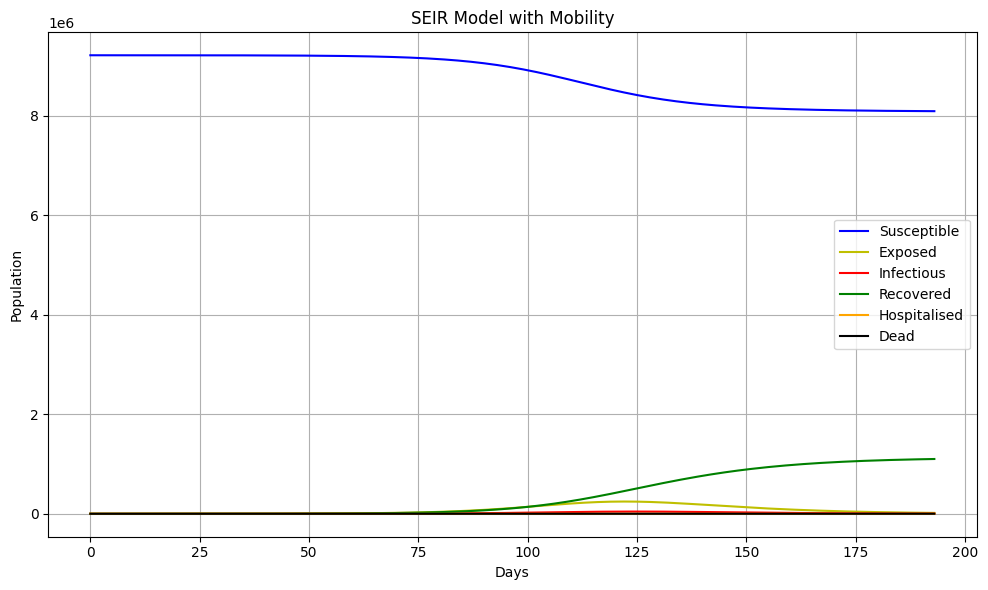

In [202]:
res["no_interventions"] = odeint(fn_seirhd_mobility_model, y0, xdata_stage1, args=(tuple(list(params_no_intervention.values()))))
fn_plot_SEIRHD(xdata_stage1, res["no_interventions"])

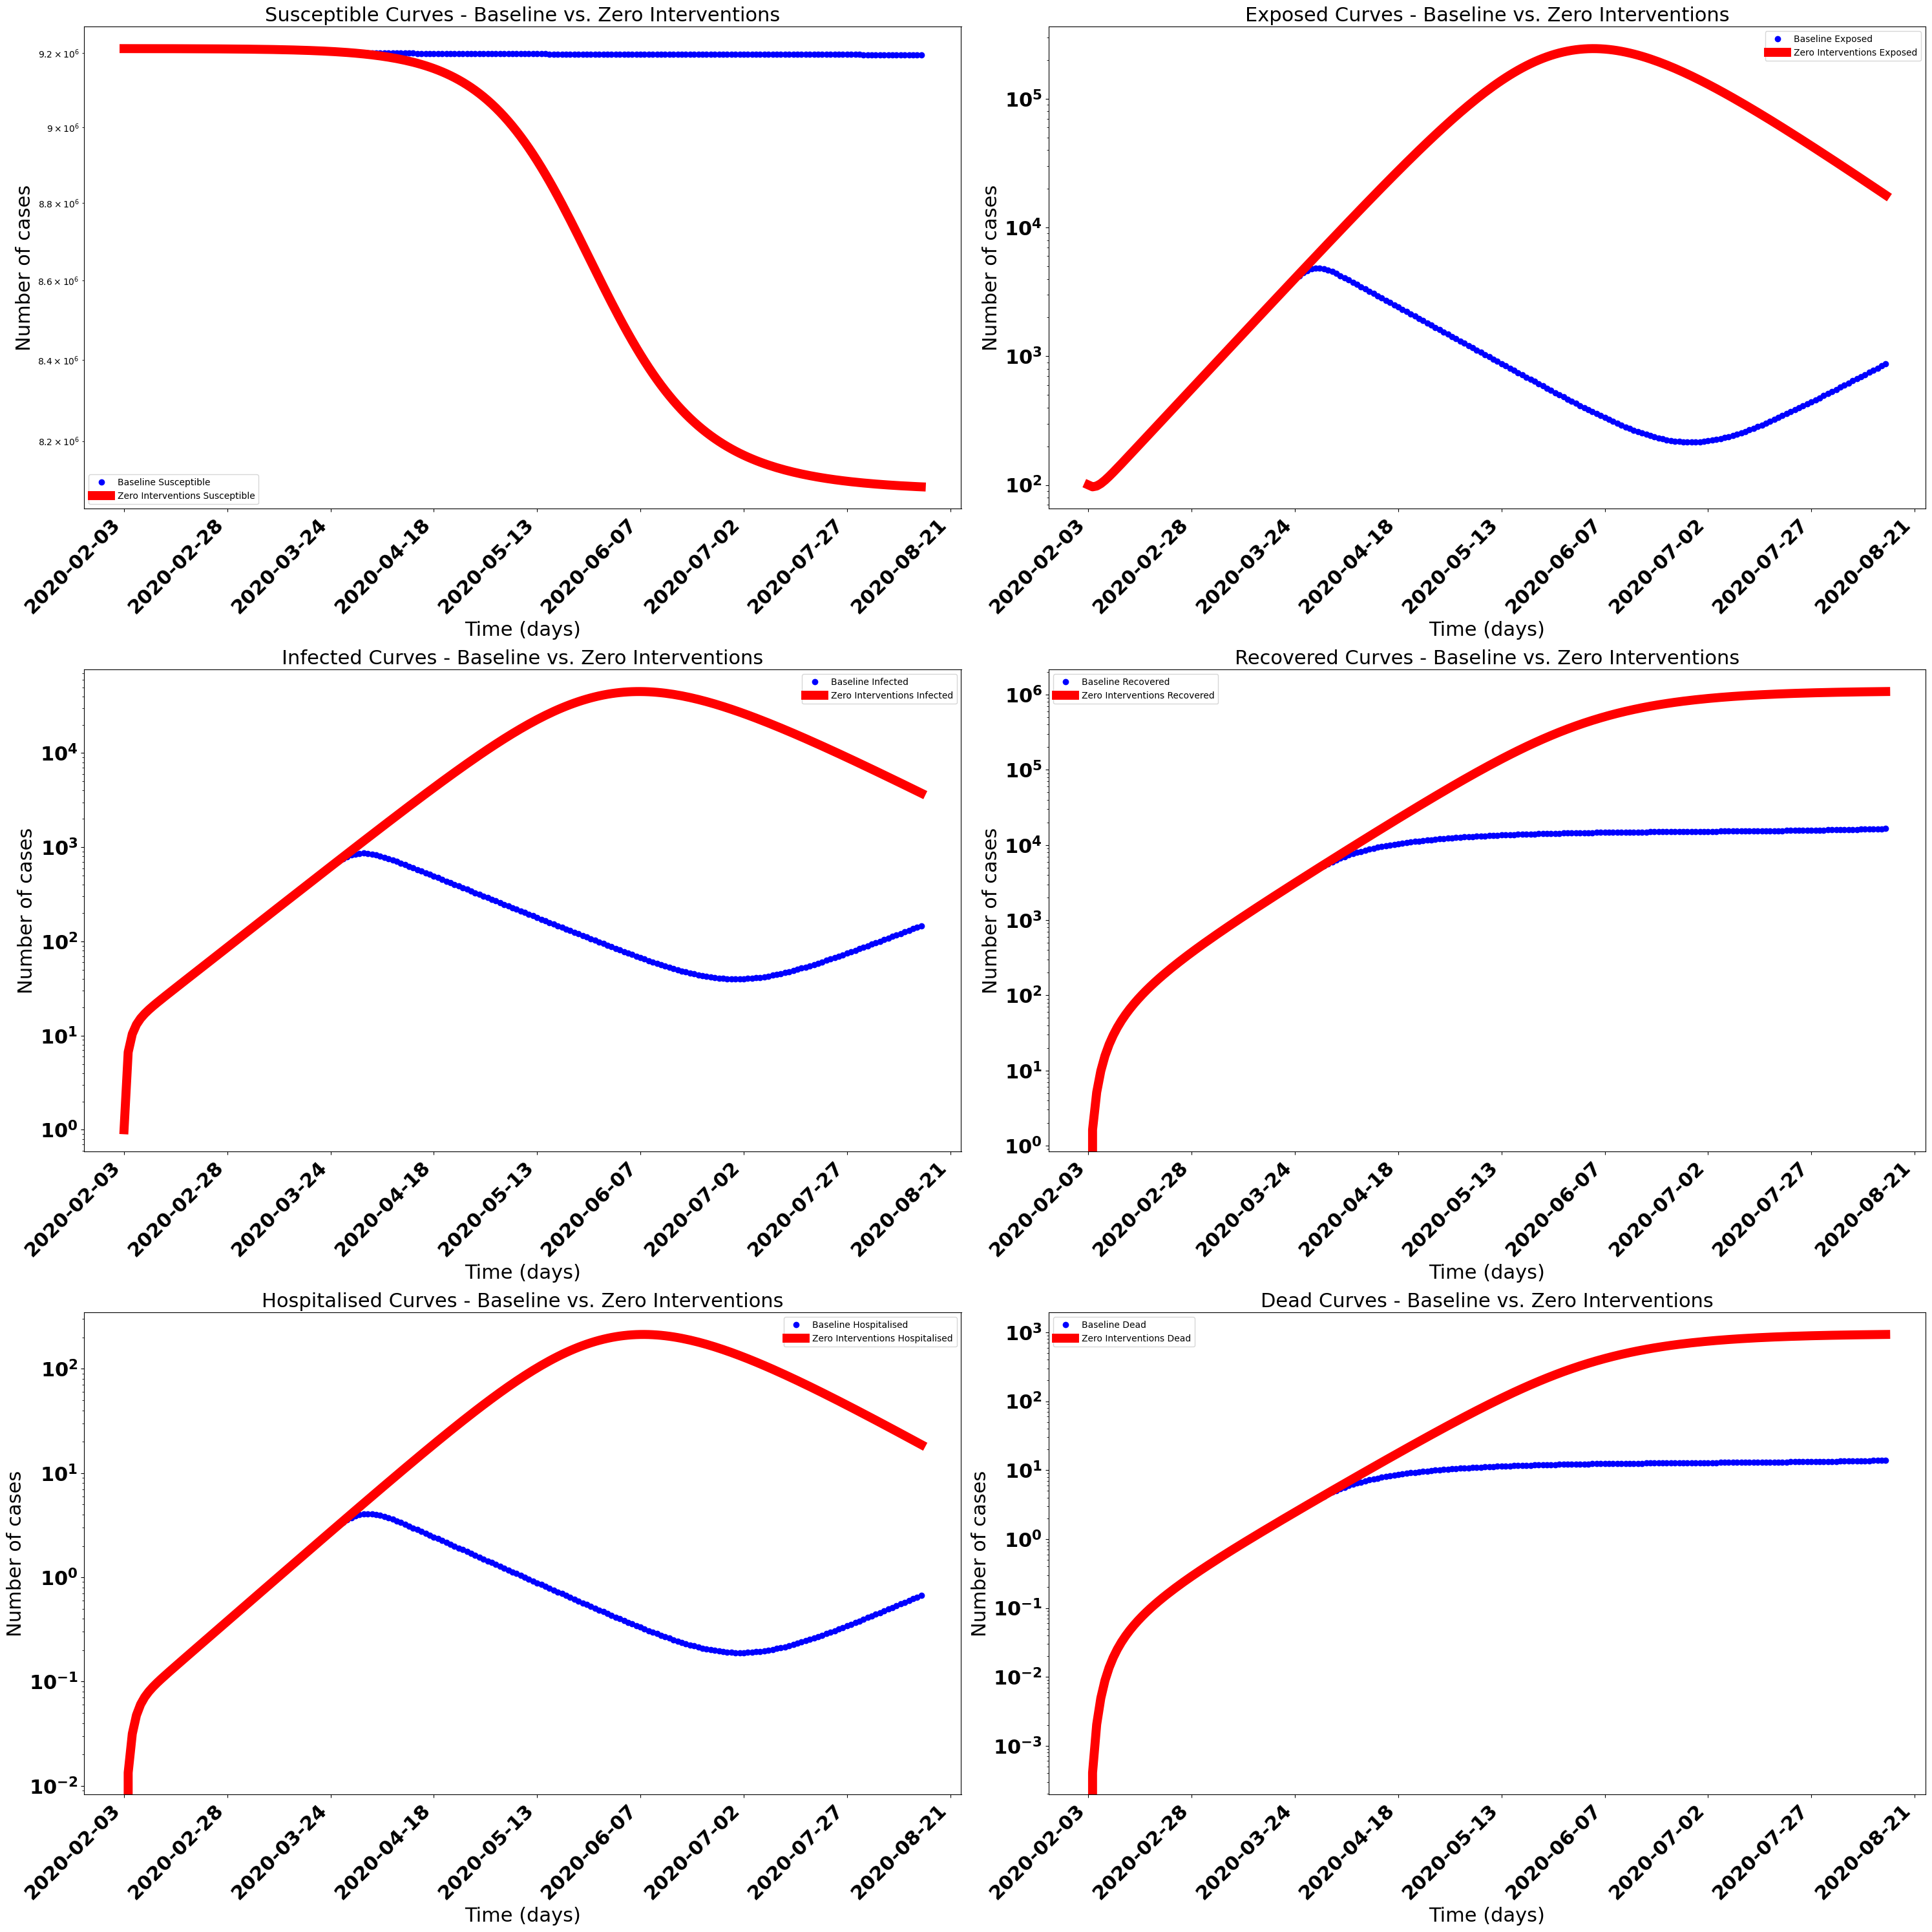

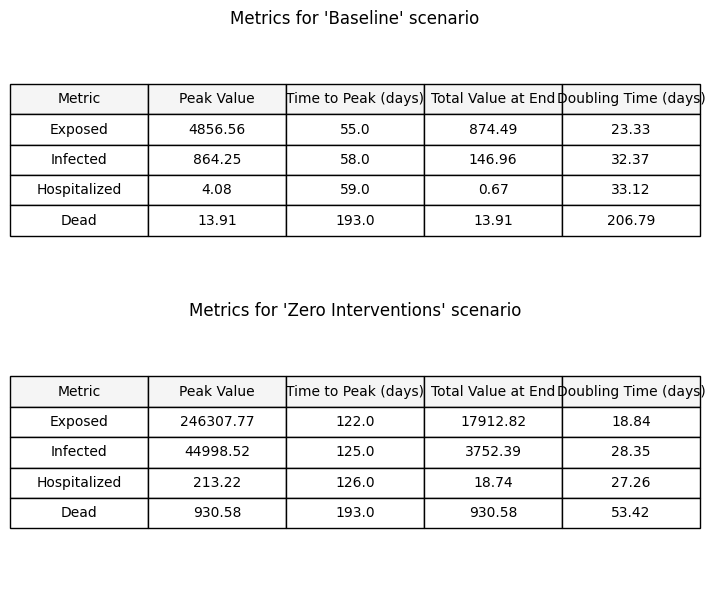

In [203]:
fn_plot_Baseline_VS_Scenarios(res["actual_interventions"], xdata_stage1, y0, params_no_intervention, 'Zero Interventions', 'log', False)

## 9.3 Lockdown mandates in place on the estimated day of lockdown start till estimated end date (80% population follows lockdown mandates)

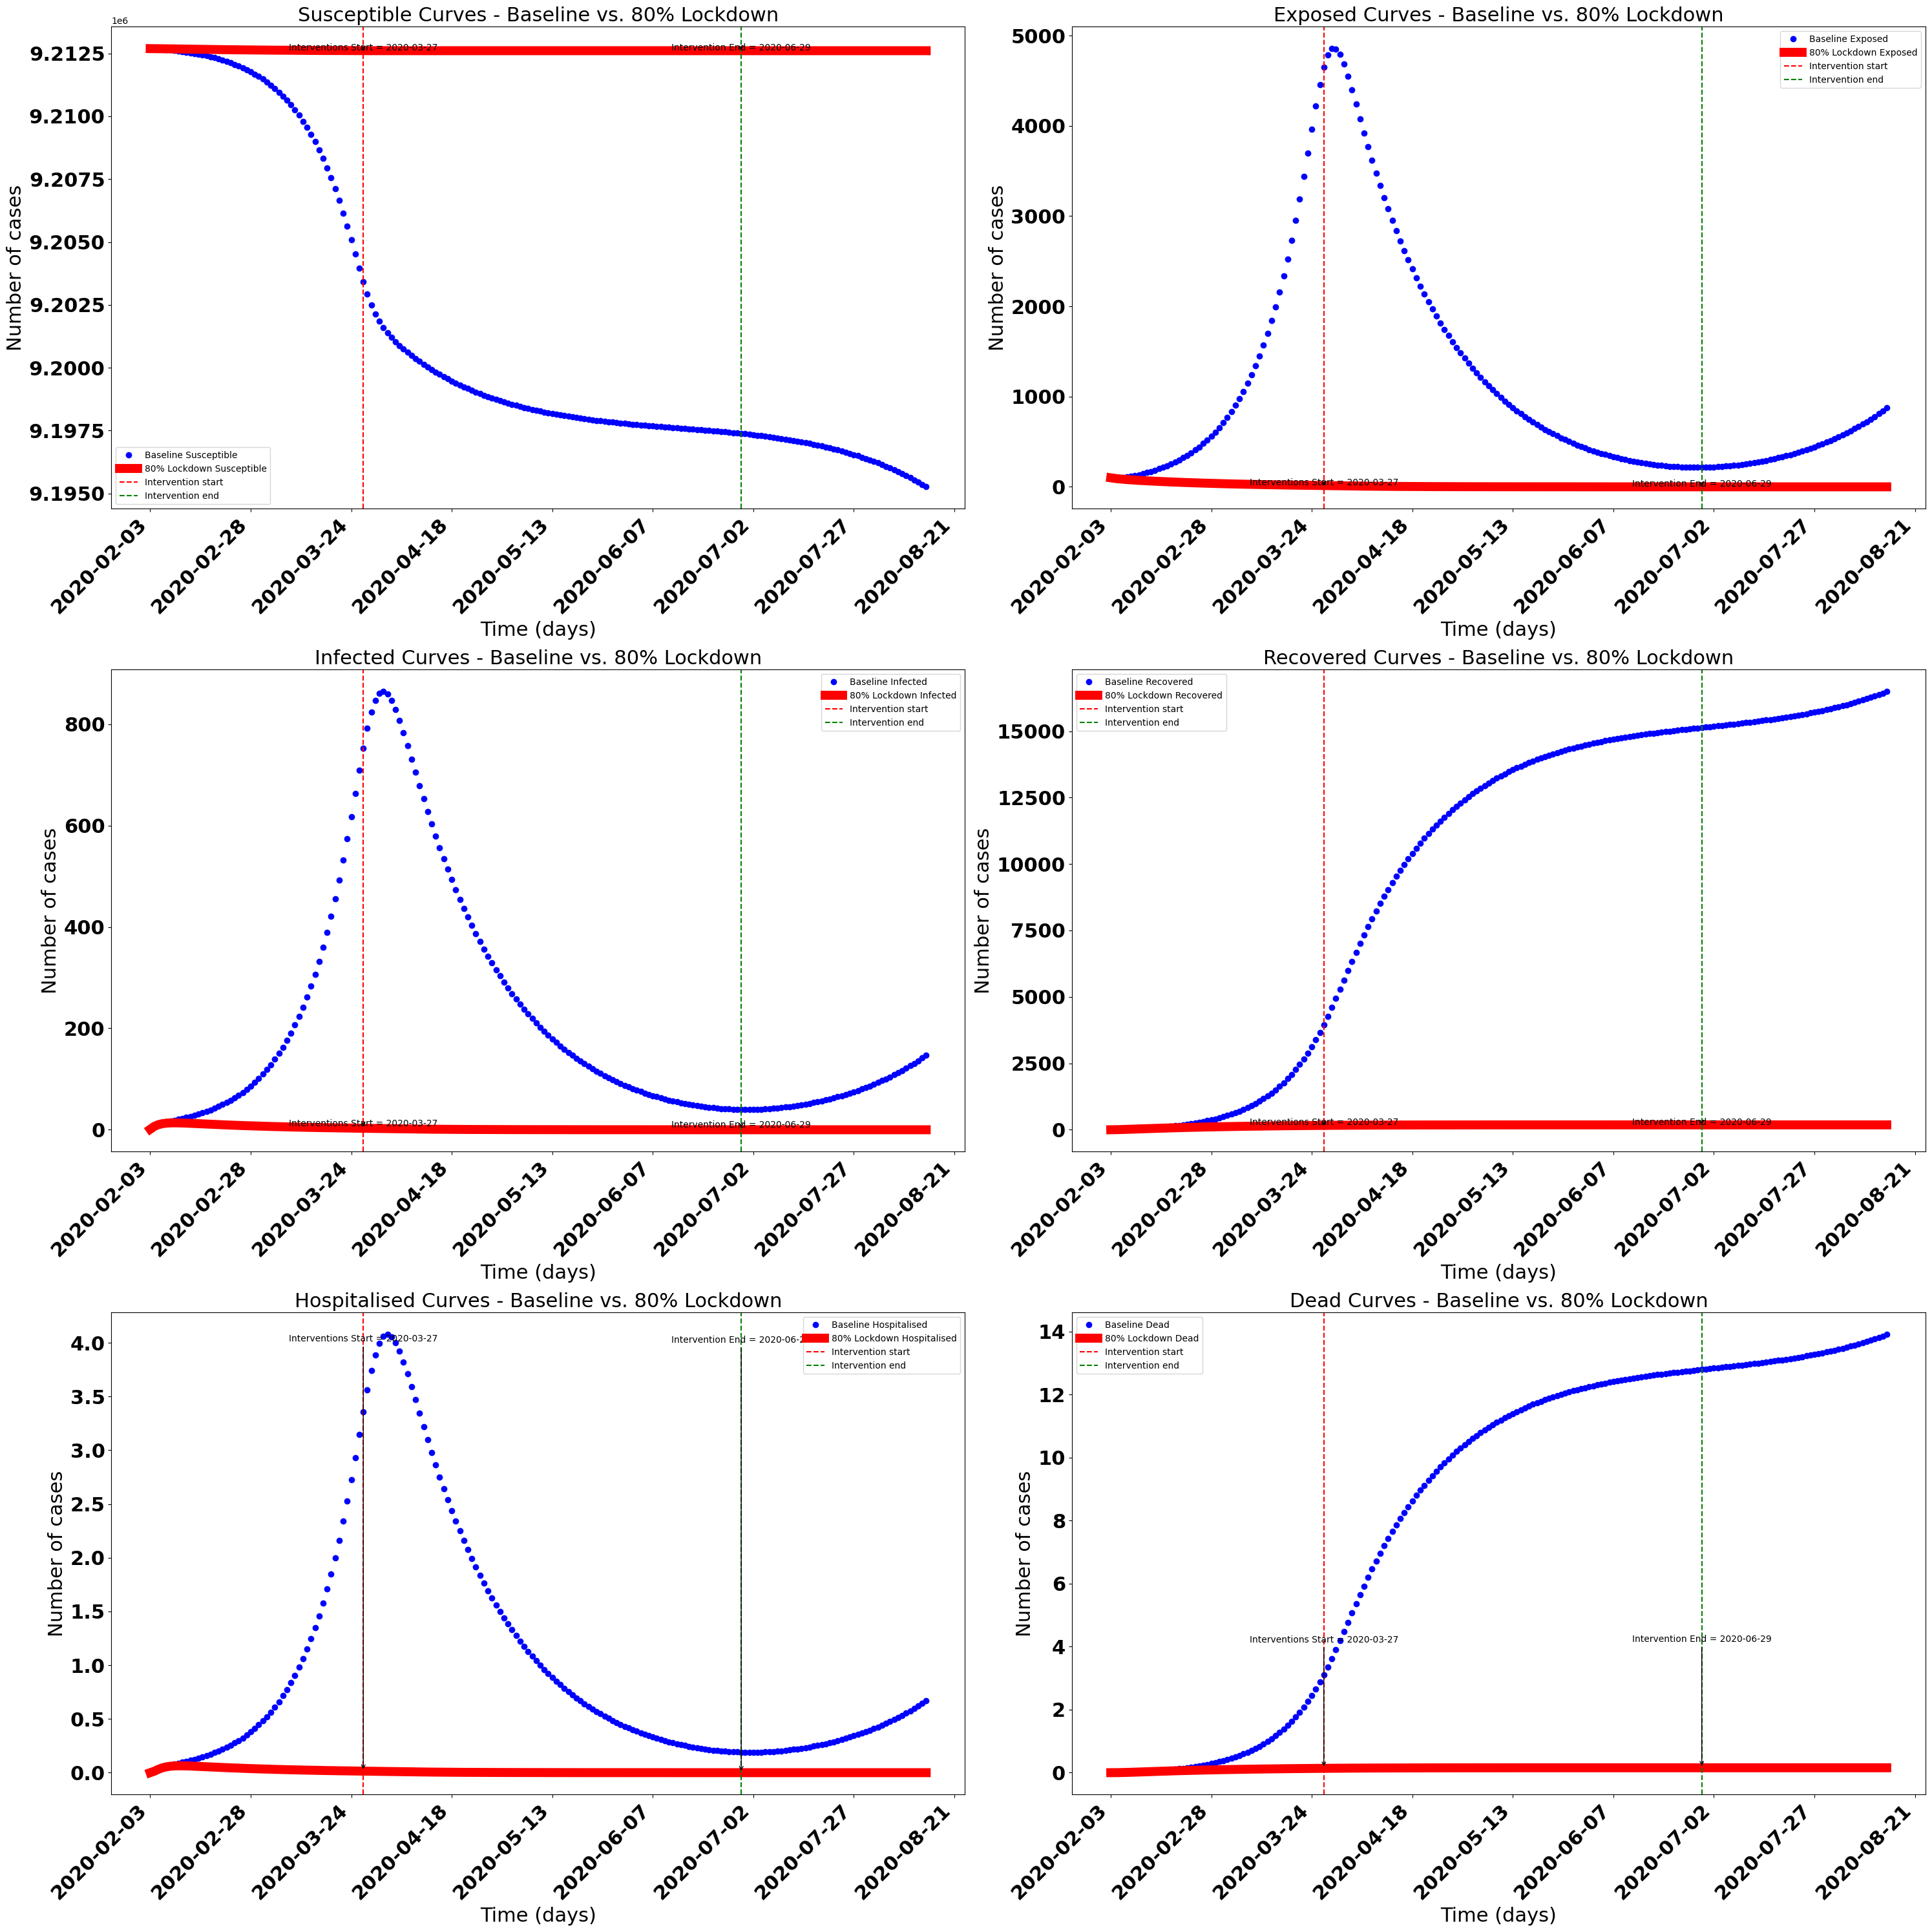

<ipython-input-200-760ec1560605>:18: RuntimeWarning: Mean of empty slice
  return round(np.nanmean(doubling_times),2)


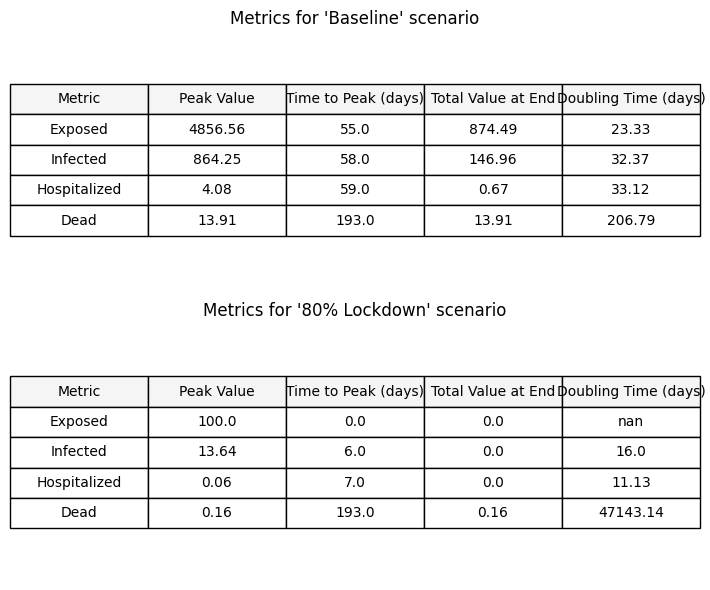

In [204]:
params_80pc_lockdown = params_baseline.copy()
params_80pc_lockdown['rho'] = 0.2
params_80pc_lockdown['alpha'] = 0.2

fn_plot_Baseline_VS_Scenarios(res["actual_interventions"], xdata_stage1, y0, params_80pc_lockdown, '80% Lockdown', 'linear')

## 9.4. Scenario - strict Lockdown is announced within 30 days of first reported case. and gradually reopened:

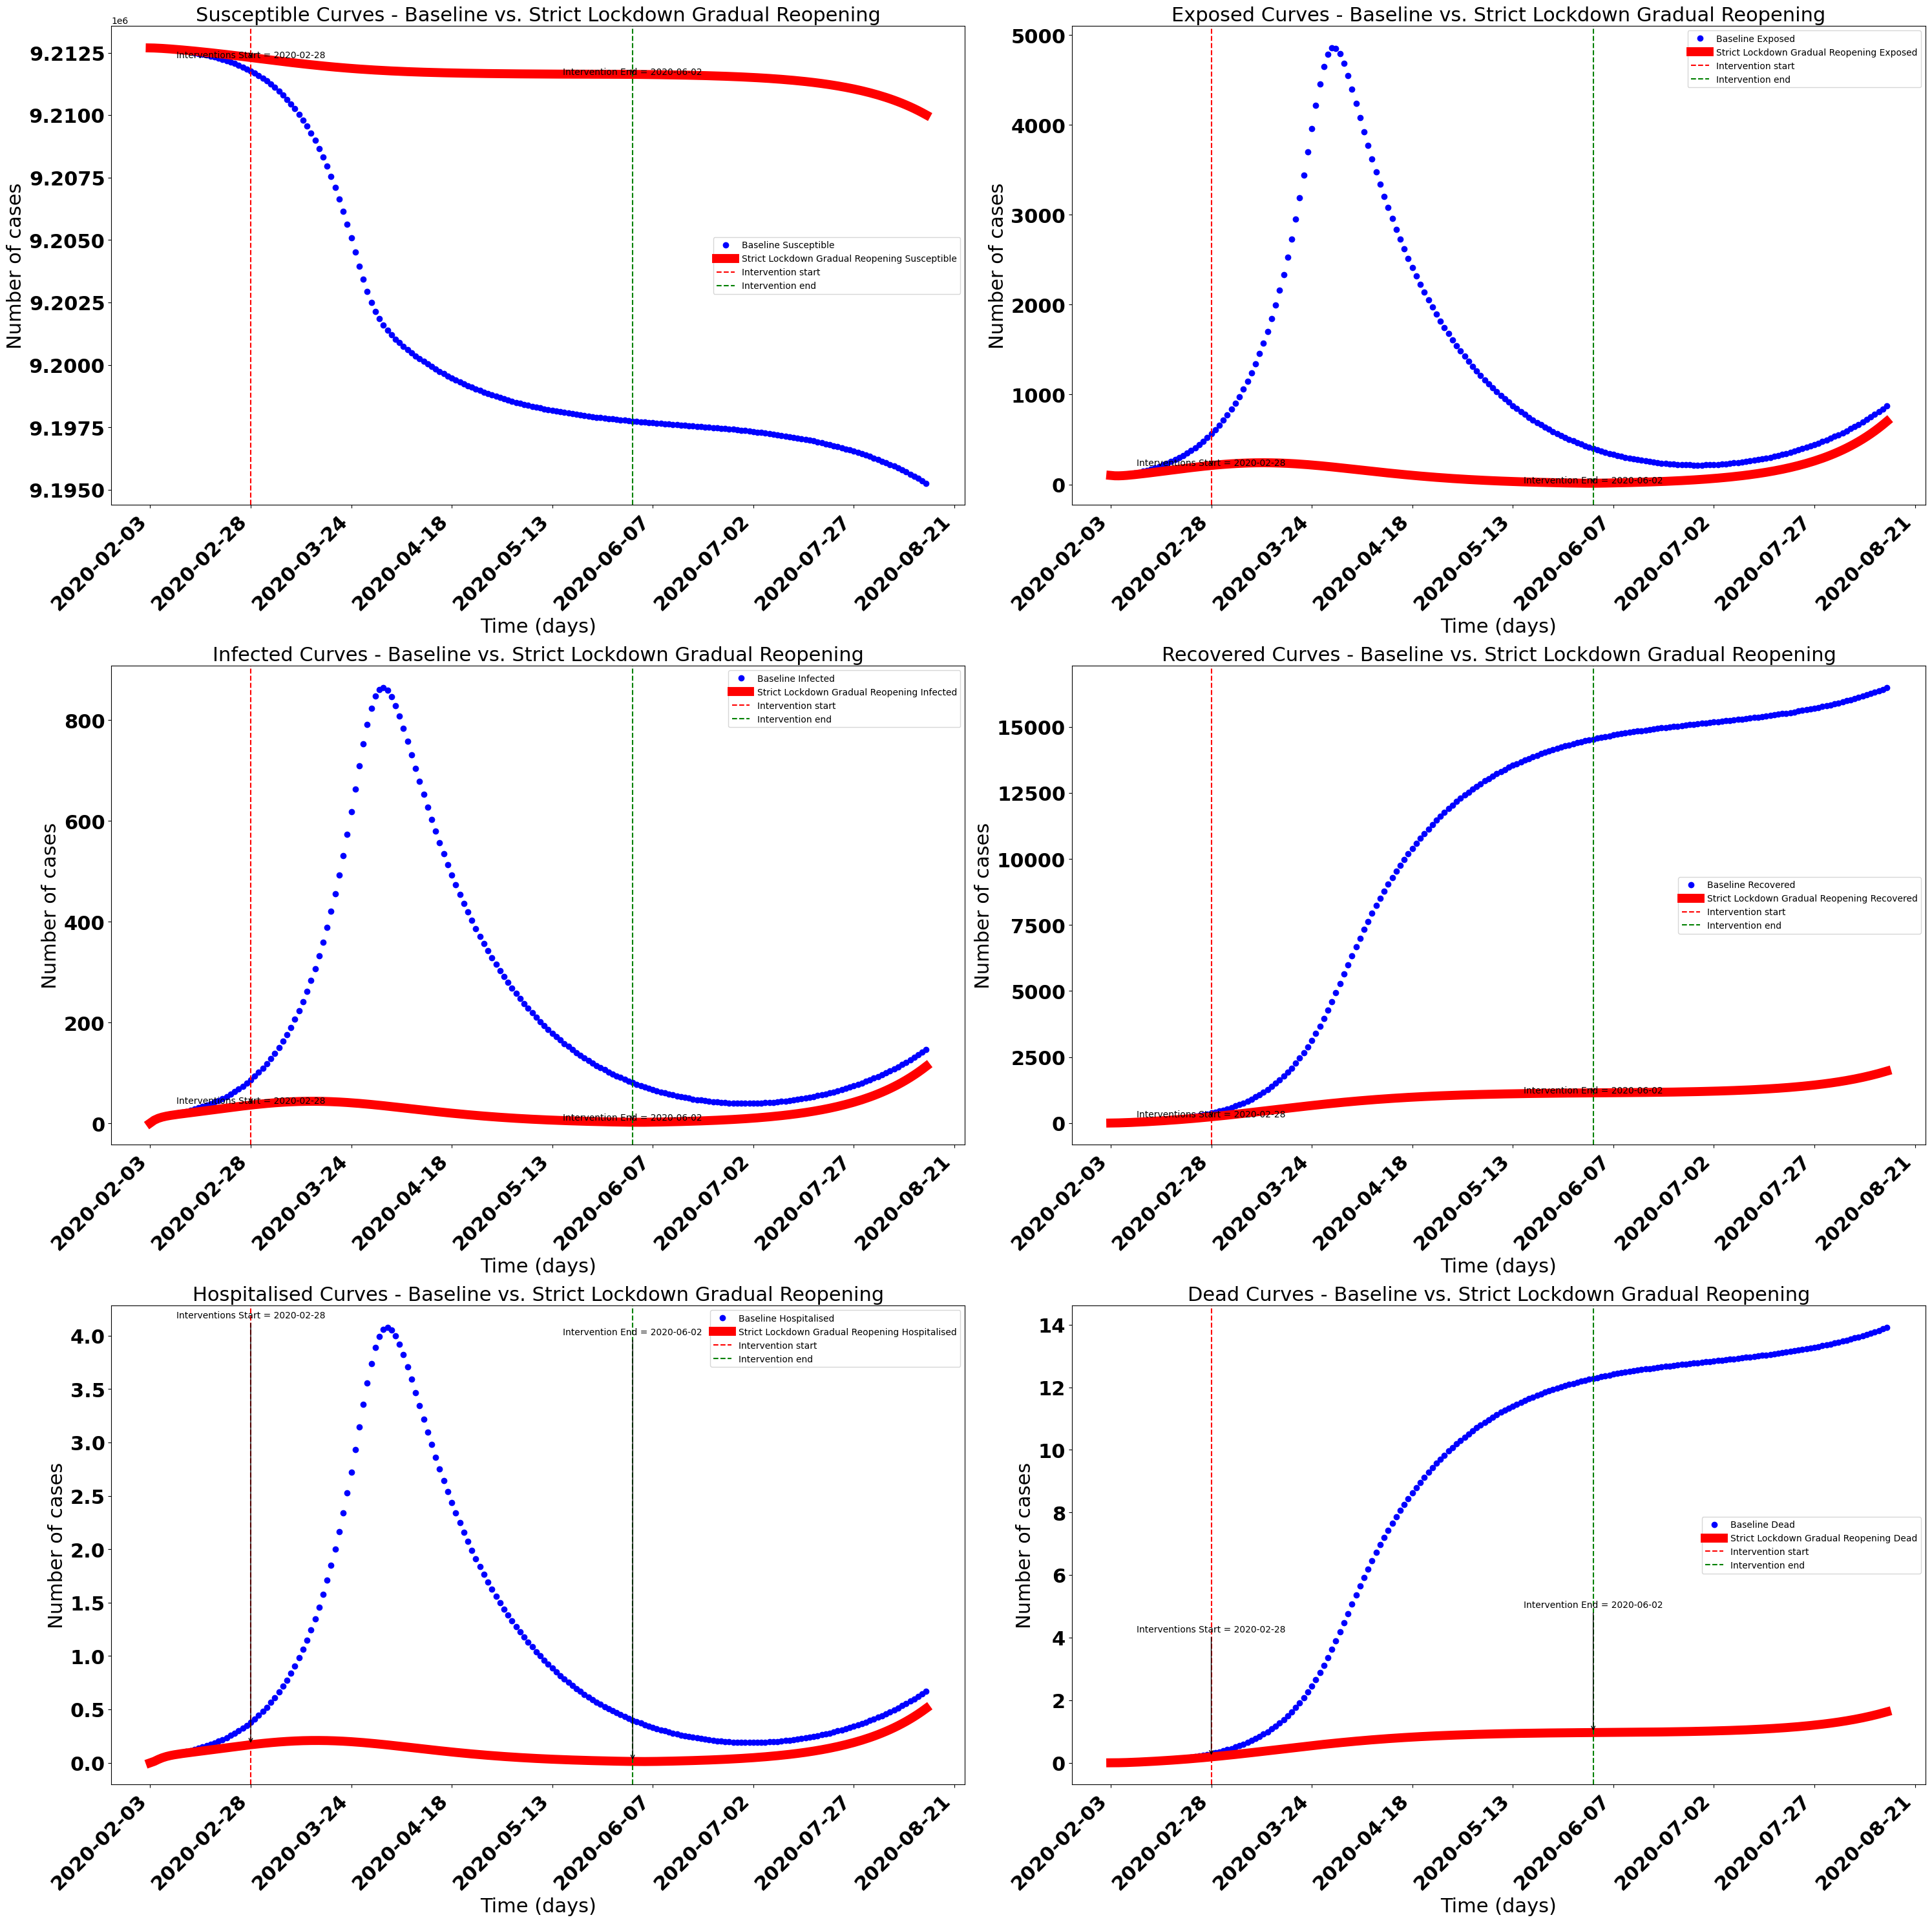

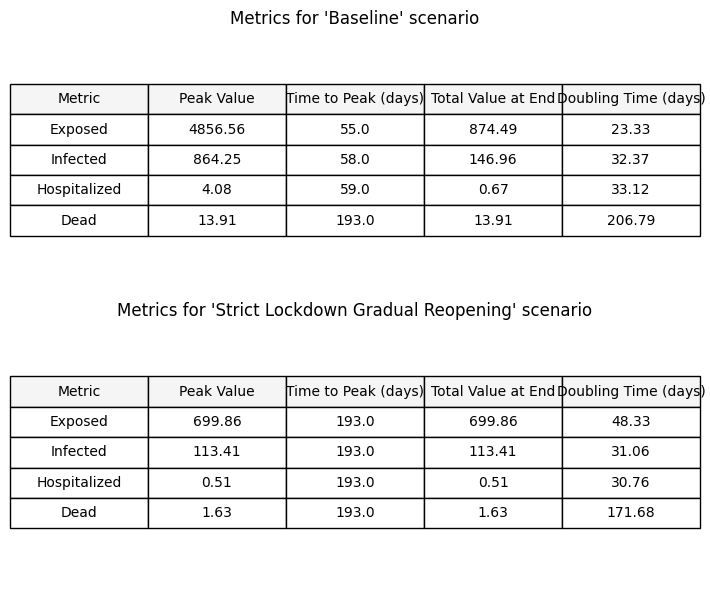

In [205]:
params_strict_lockdown_smooth_reopening = params_baseline.copy()
params_strict_lockdown_smooth_reopening['beta_lockdown'] = 0.10
params_strict_lockdown_smooth_reopening['beta_end'] = 0.8
params_strict_lockdown_smooth_reopening['k1'] = 0.05
params_strict_lockdown_smooth_reopening['t1'] = 25
params_strict_lockdown_smooth_reopening['k2'] = 0.99
params_strict_lockdown_smooth_reopening['t2'] = 120


fn_plot_Baseline_VS_Scenarios(res["actual_interventions"], xdata_stage1, y0, params_strict_lockdown_smooth_reopening, 'Strict Lockdown Gradual Reopening', 'linear')

## 9.5. Scenario - Lockdown is announced strict within 30 days of first reported case and restrictions are not lifted

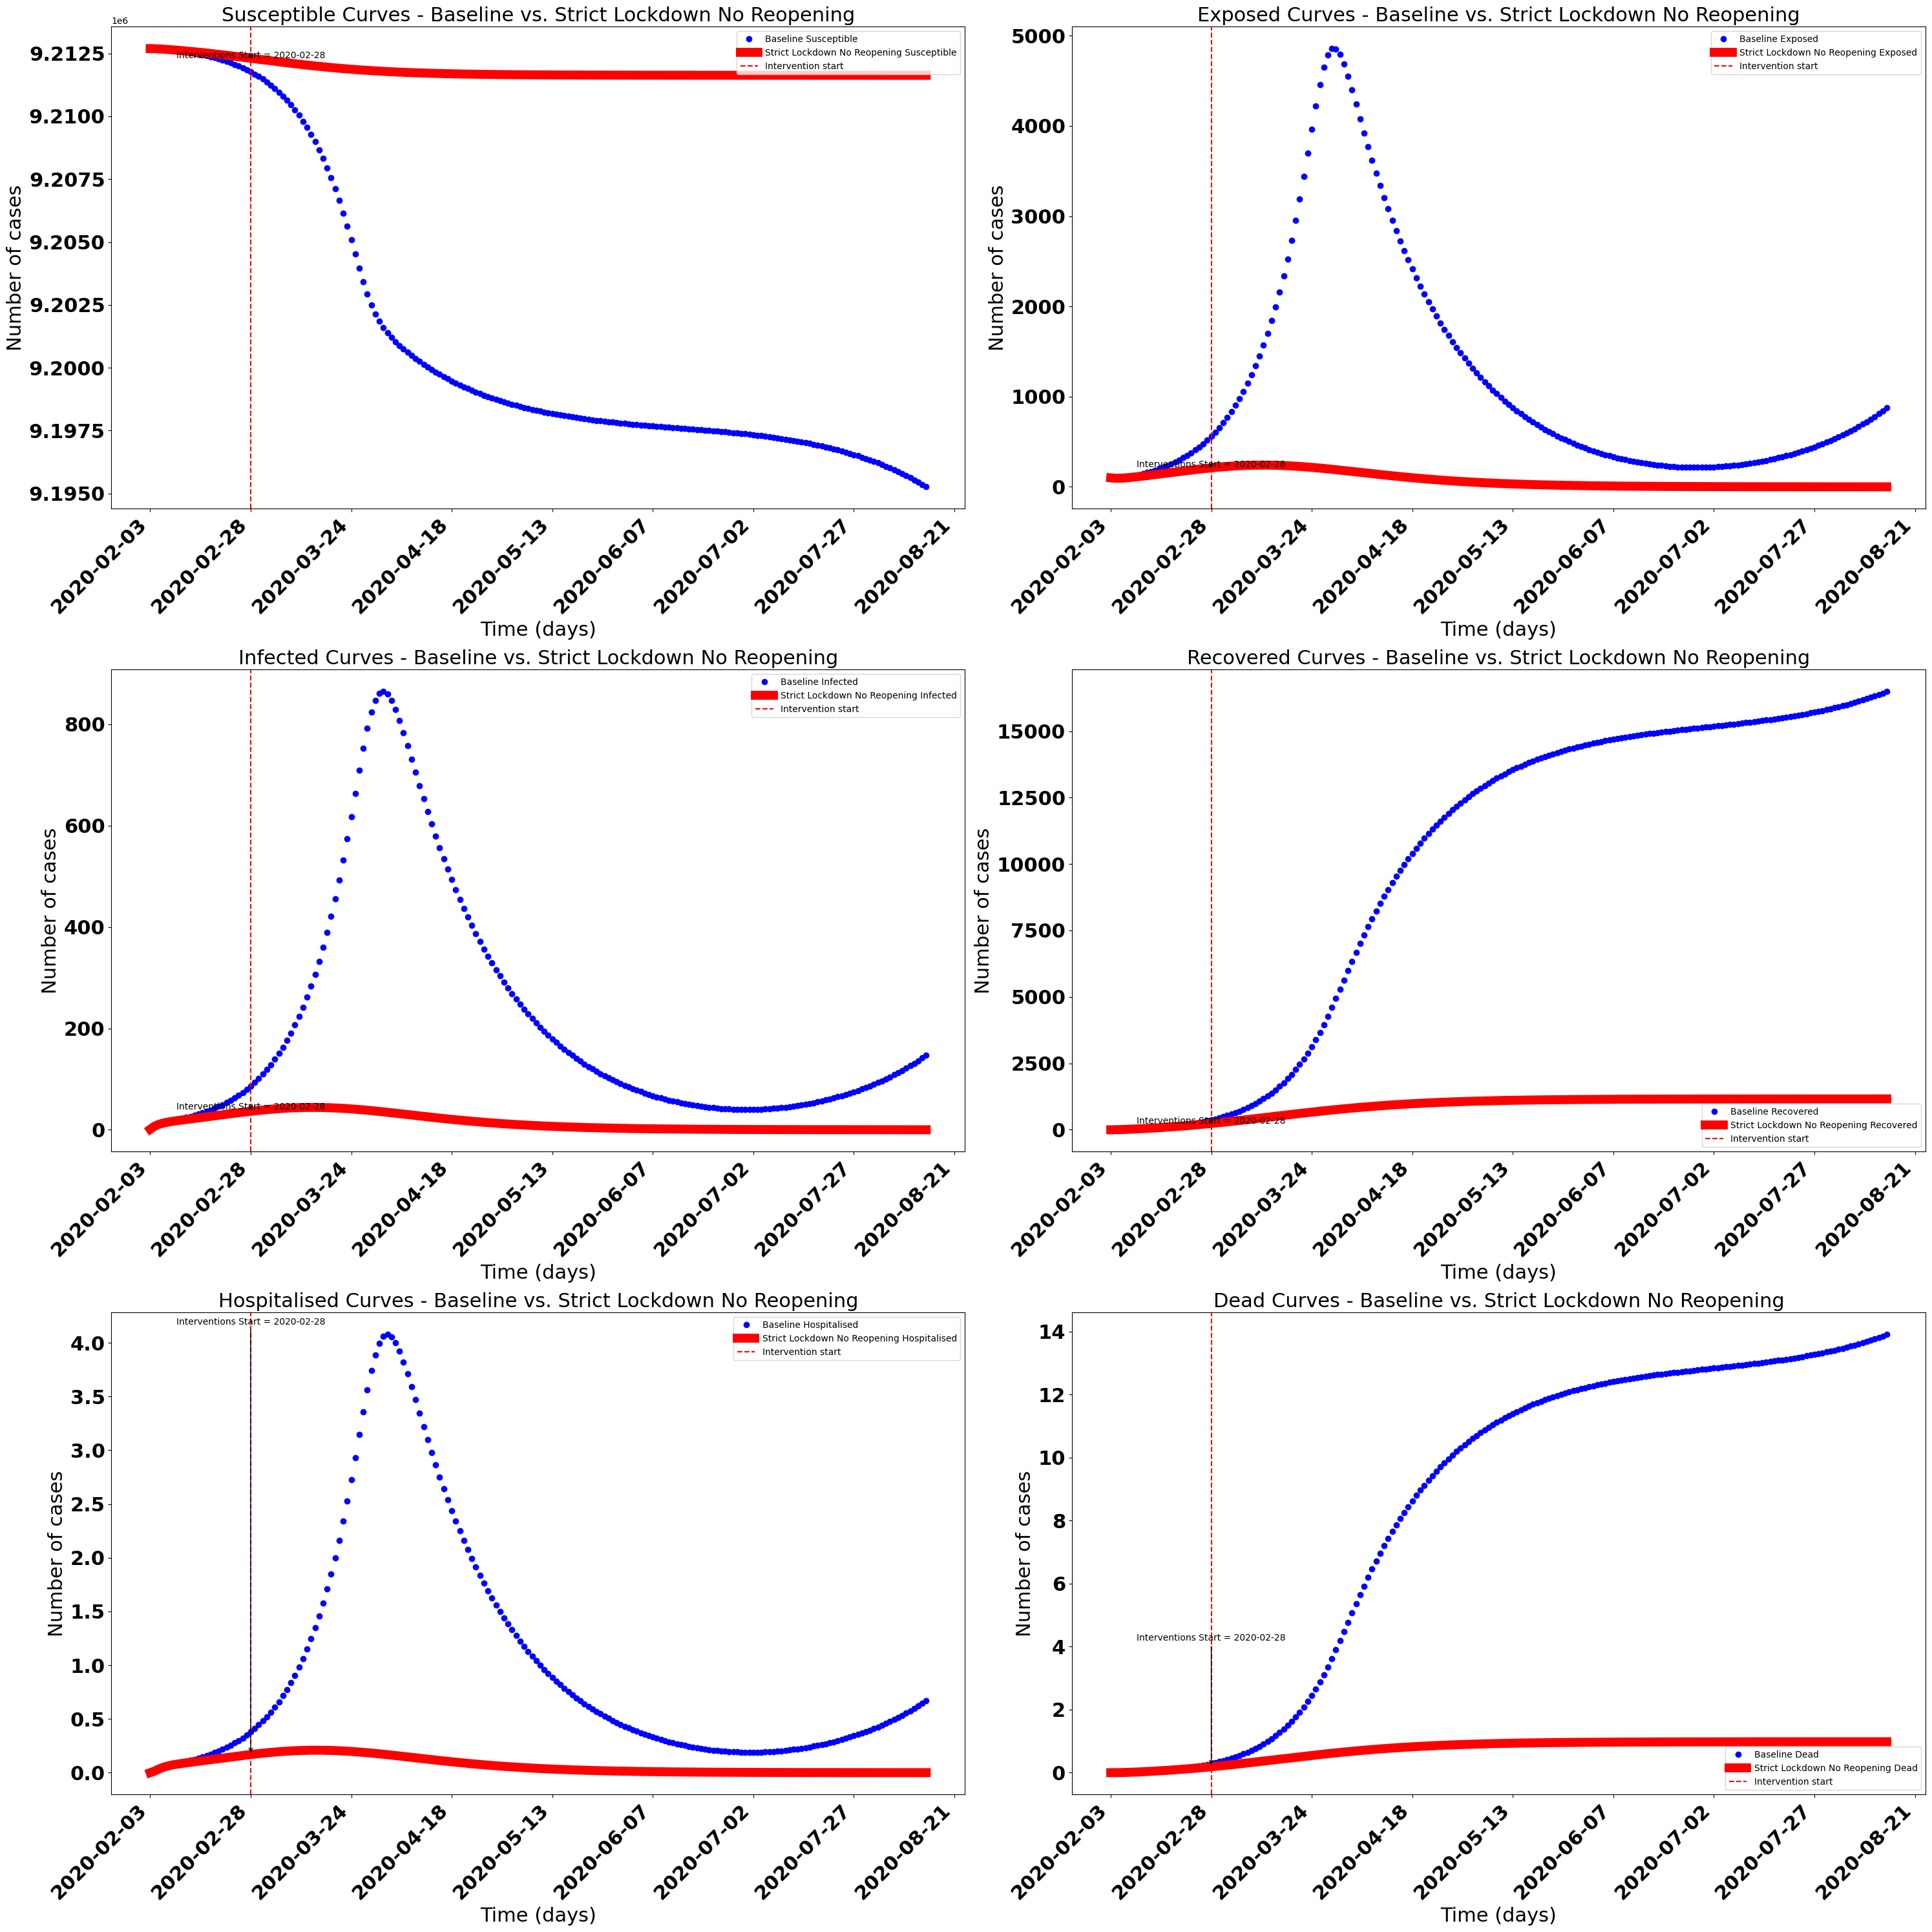

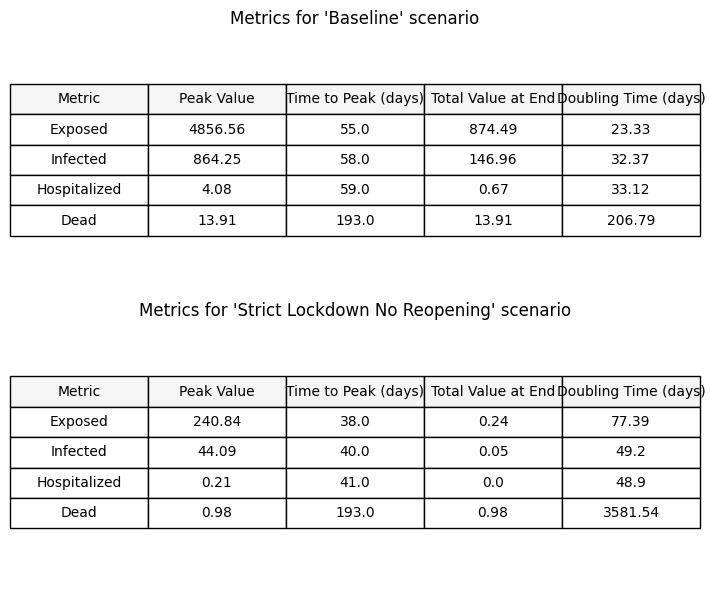

In [206]:
params_strict_lockdown_no_reopening = params_baseline.copy()
params_strict_lockdown_no_reopening['beta_lockdown'] = 0.10
params_strict_lockdown_no_reopening['beta_end'] = 0.10
params_strict_lockdown_no_reopening['k1'] = 0.05
params_strict_lockdown_no_reopening['t1'] = 25
params_strict_lockdown_no_reopening['k2'] = 0.99
params_strict_lockdown_no_reopening['t2'] = 520


fn_plot_Baseline_VS_Scenarios(res["actual_interventions"], xdata_stage1, y0, params_strict_lockdown_no_reopening, 'Strict Lockdown No Reopening', 'linear')

## 9.6. Late Interventions (Lockdowns are not imposed within the first 100 days of infection)

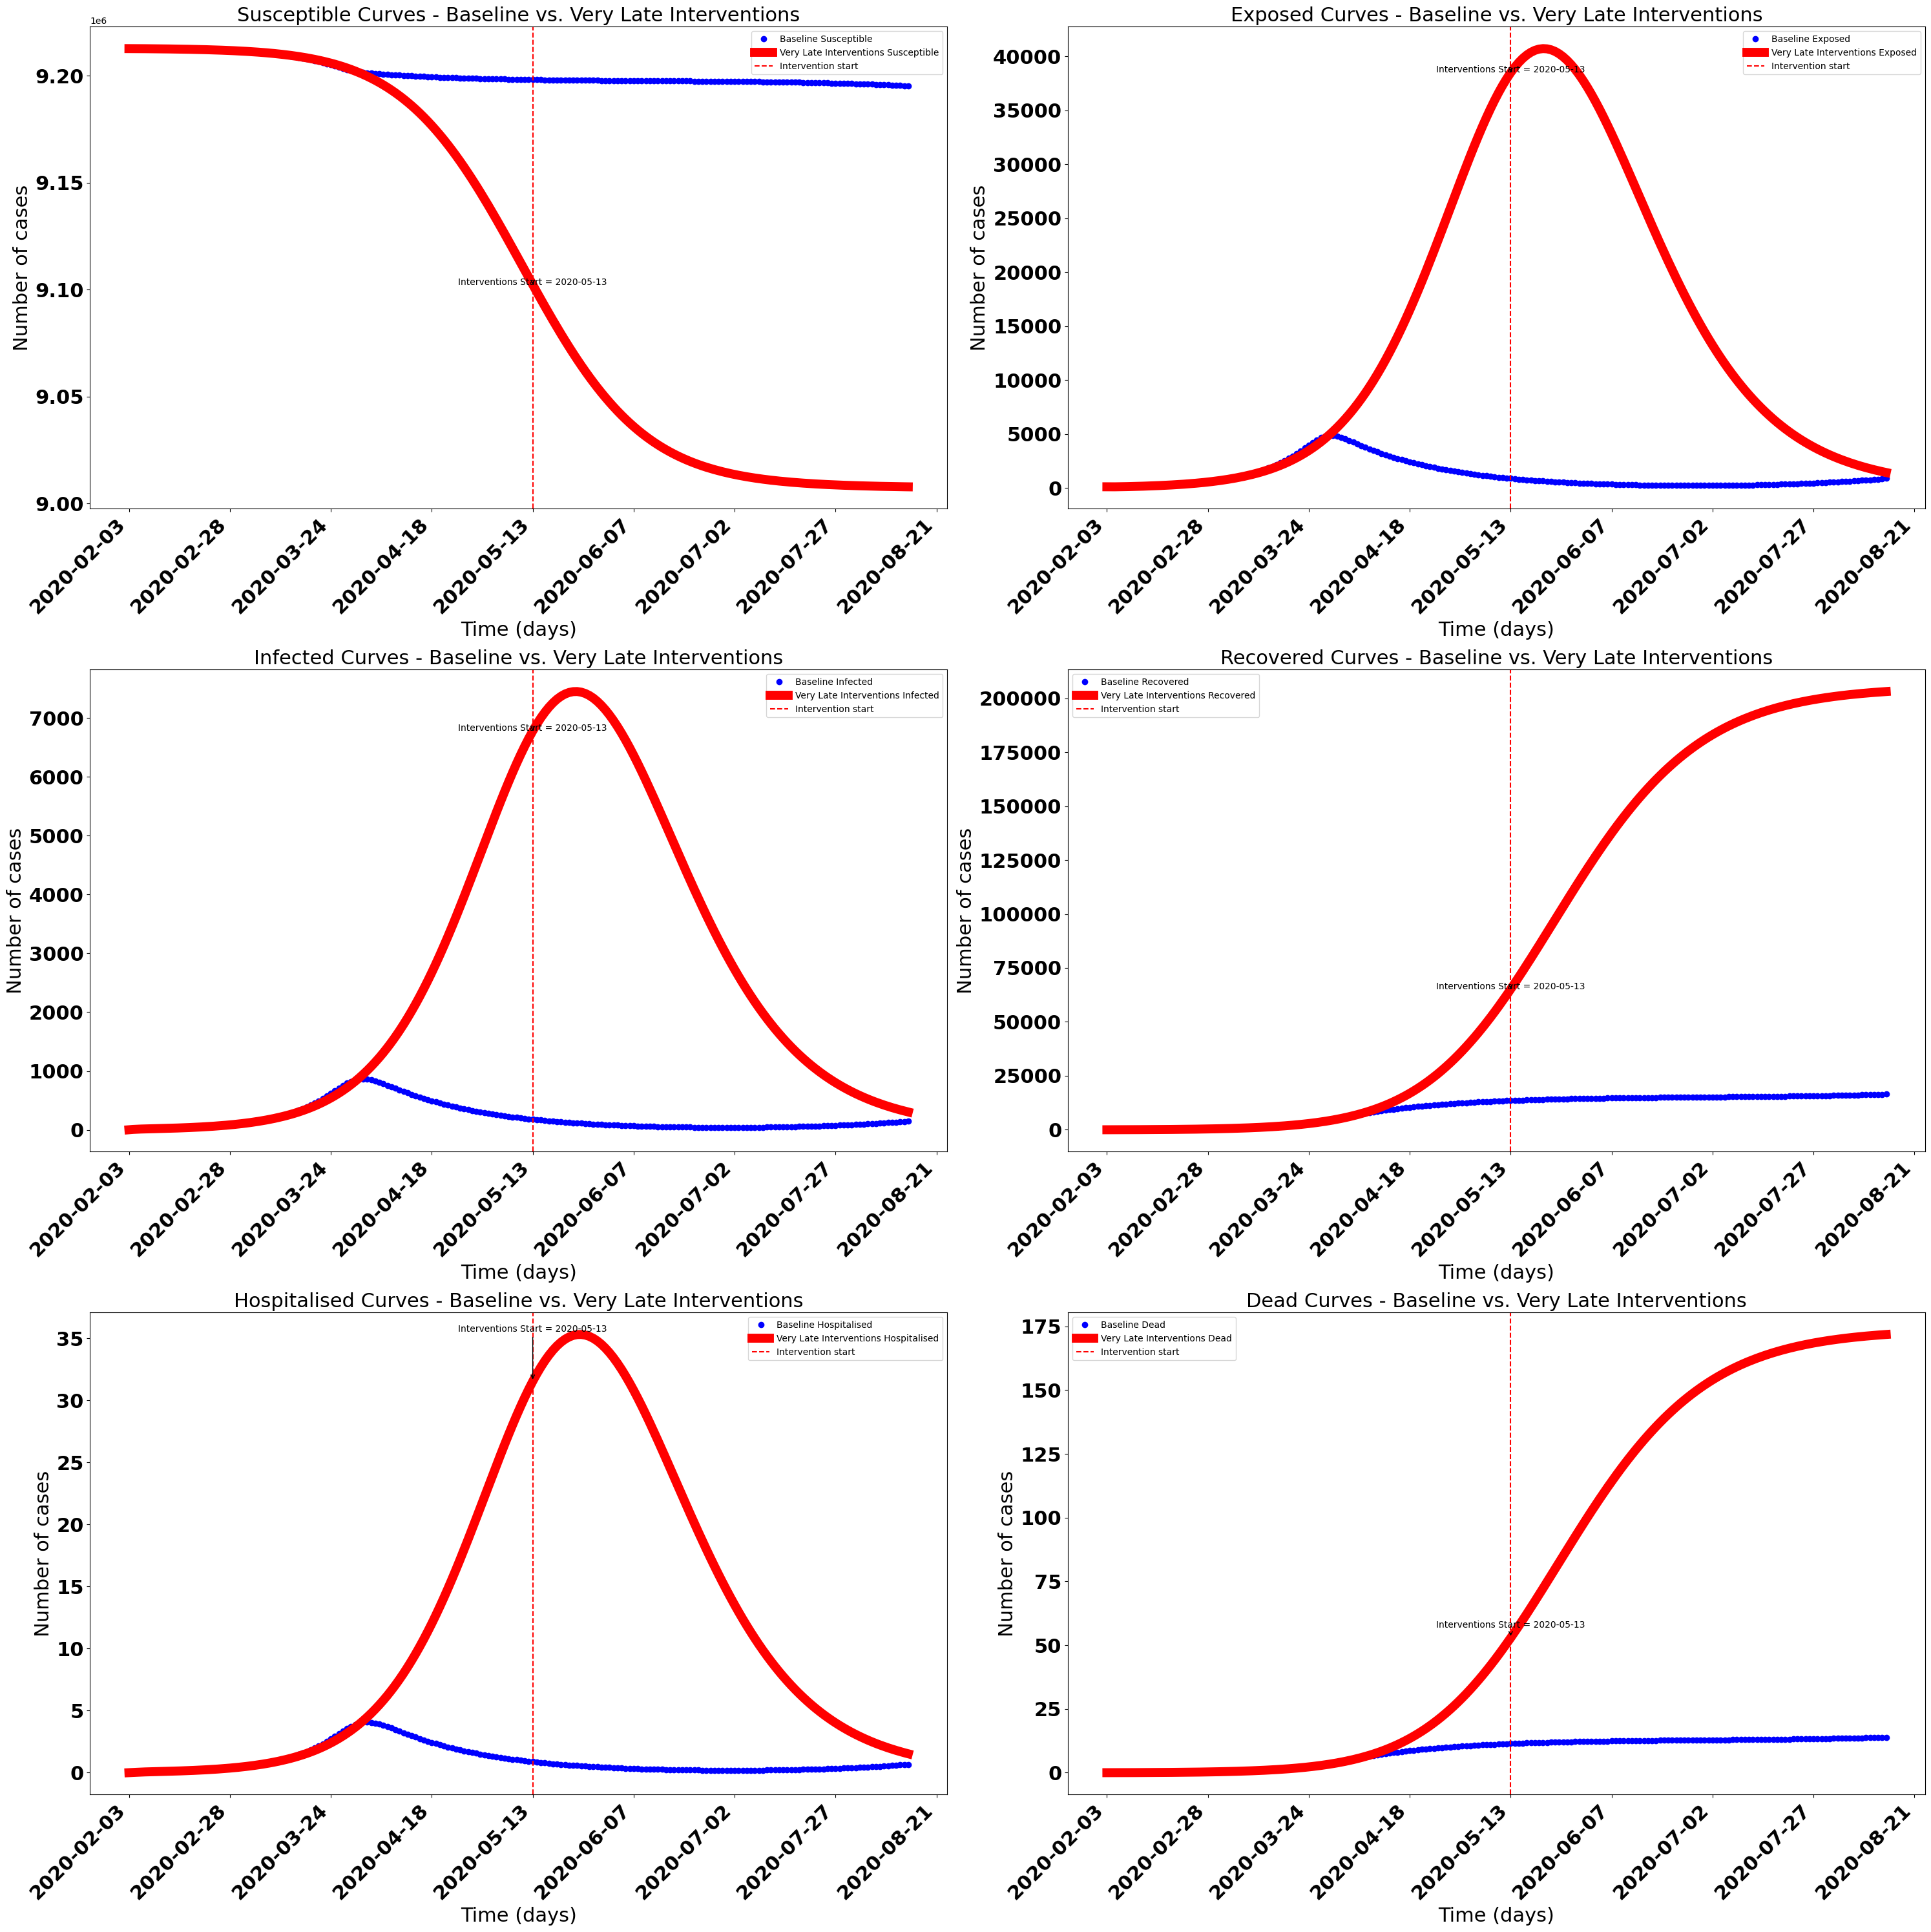

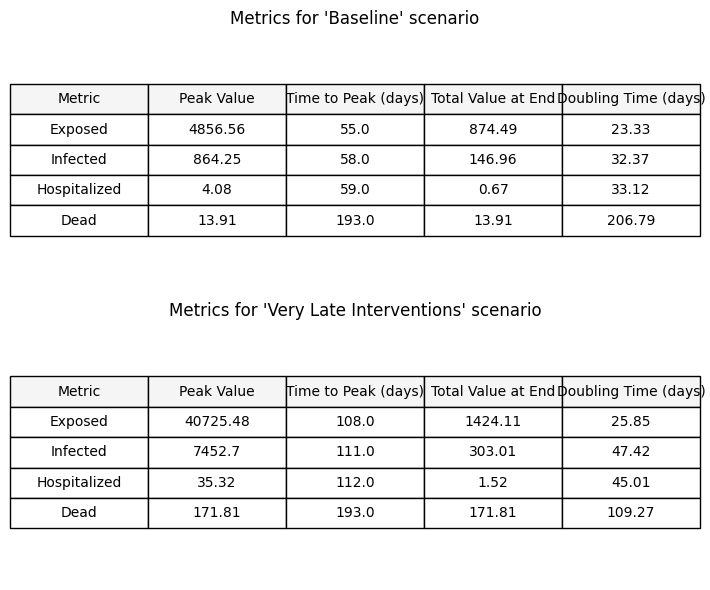

In [207]:
params_strict_late_interventions = params_baseline.copy()
params_strict_late_interventions['beta_lockdown'] = 0.10
params_strict_late_interventions['beta_end'] = 0.70
params_strict_late_interventions['k1'] = 0.05
params_strict_late_interventions['t1'] = 100
params_strict_late_interventions['k2'] = 0.99
params_strict_late_interventions['t2'] = 520


fn_plot_Baseline_VS_Scenarios(res["actual_interventions"], xdata_stage1, y0, params_strict_late_interventions, 'Very Late Interventions', 'linear')

## 9.7. Social distancing, mask wearing mandates in place and followed by the public

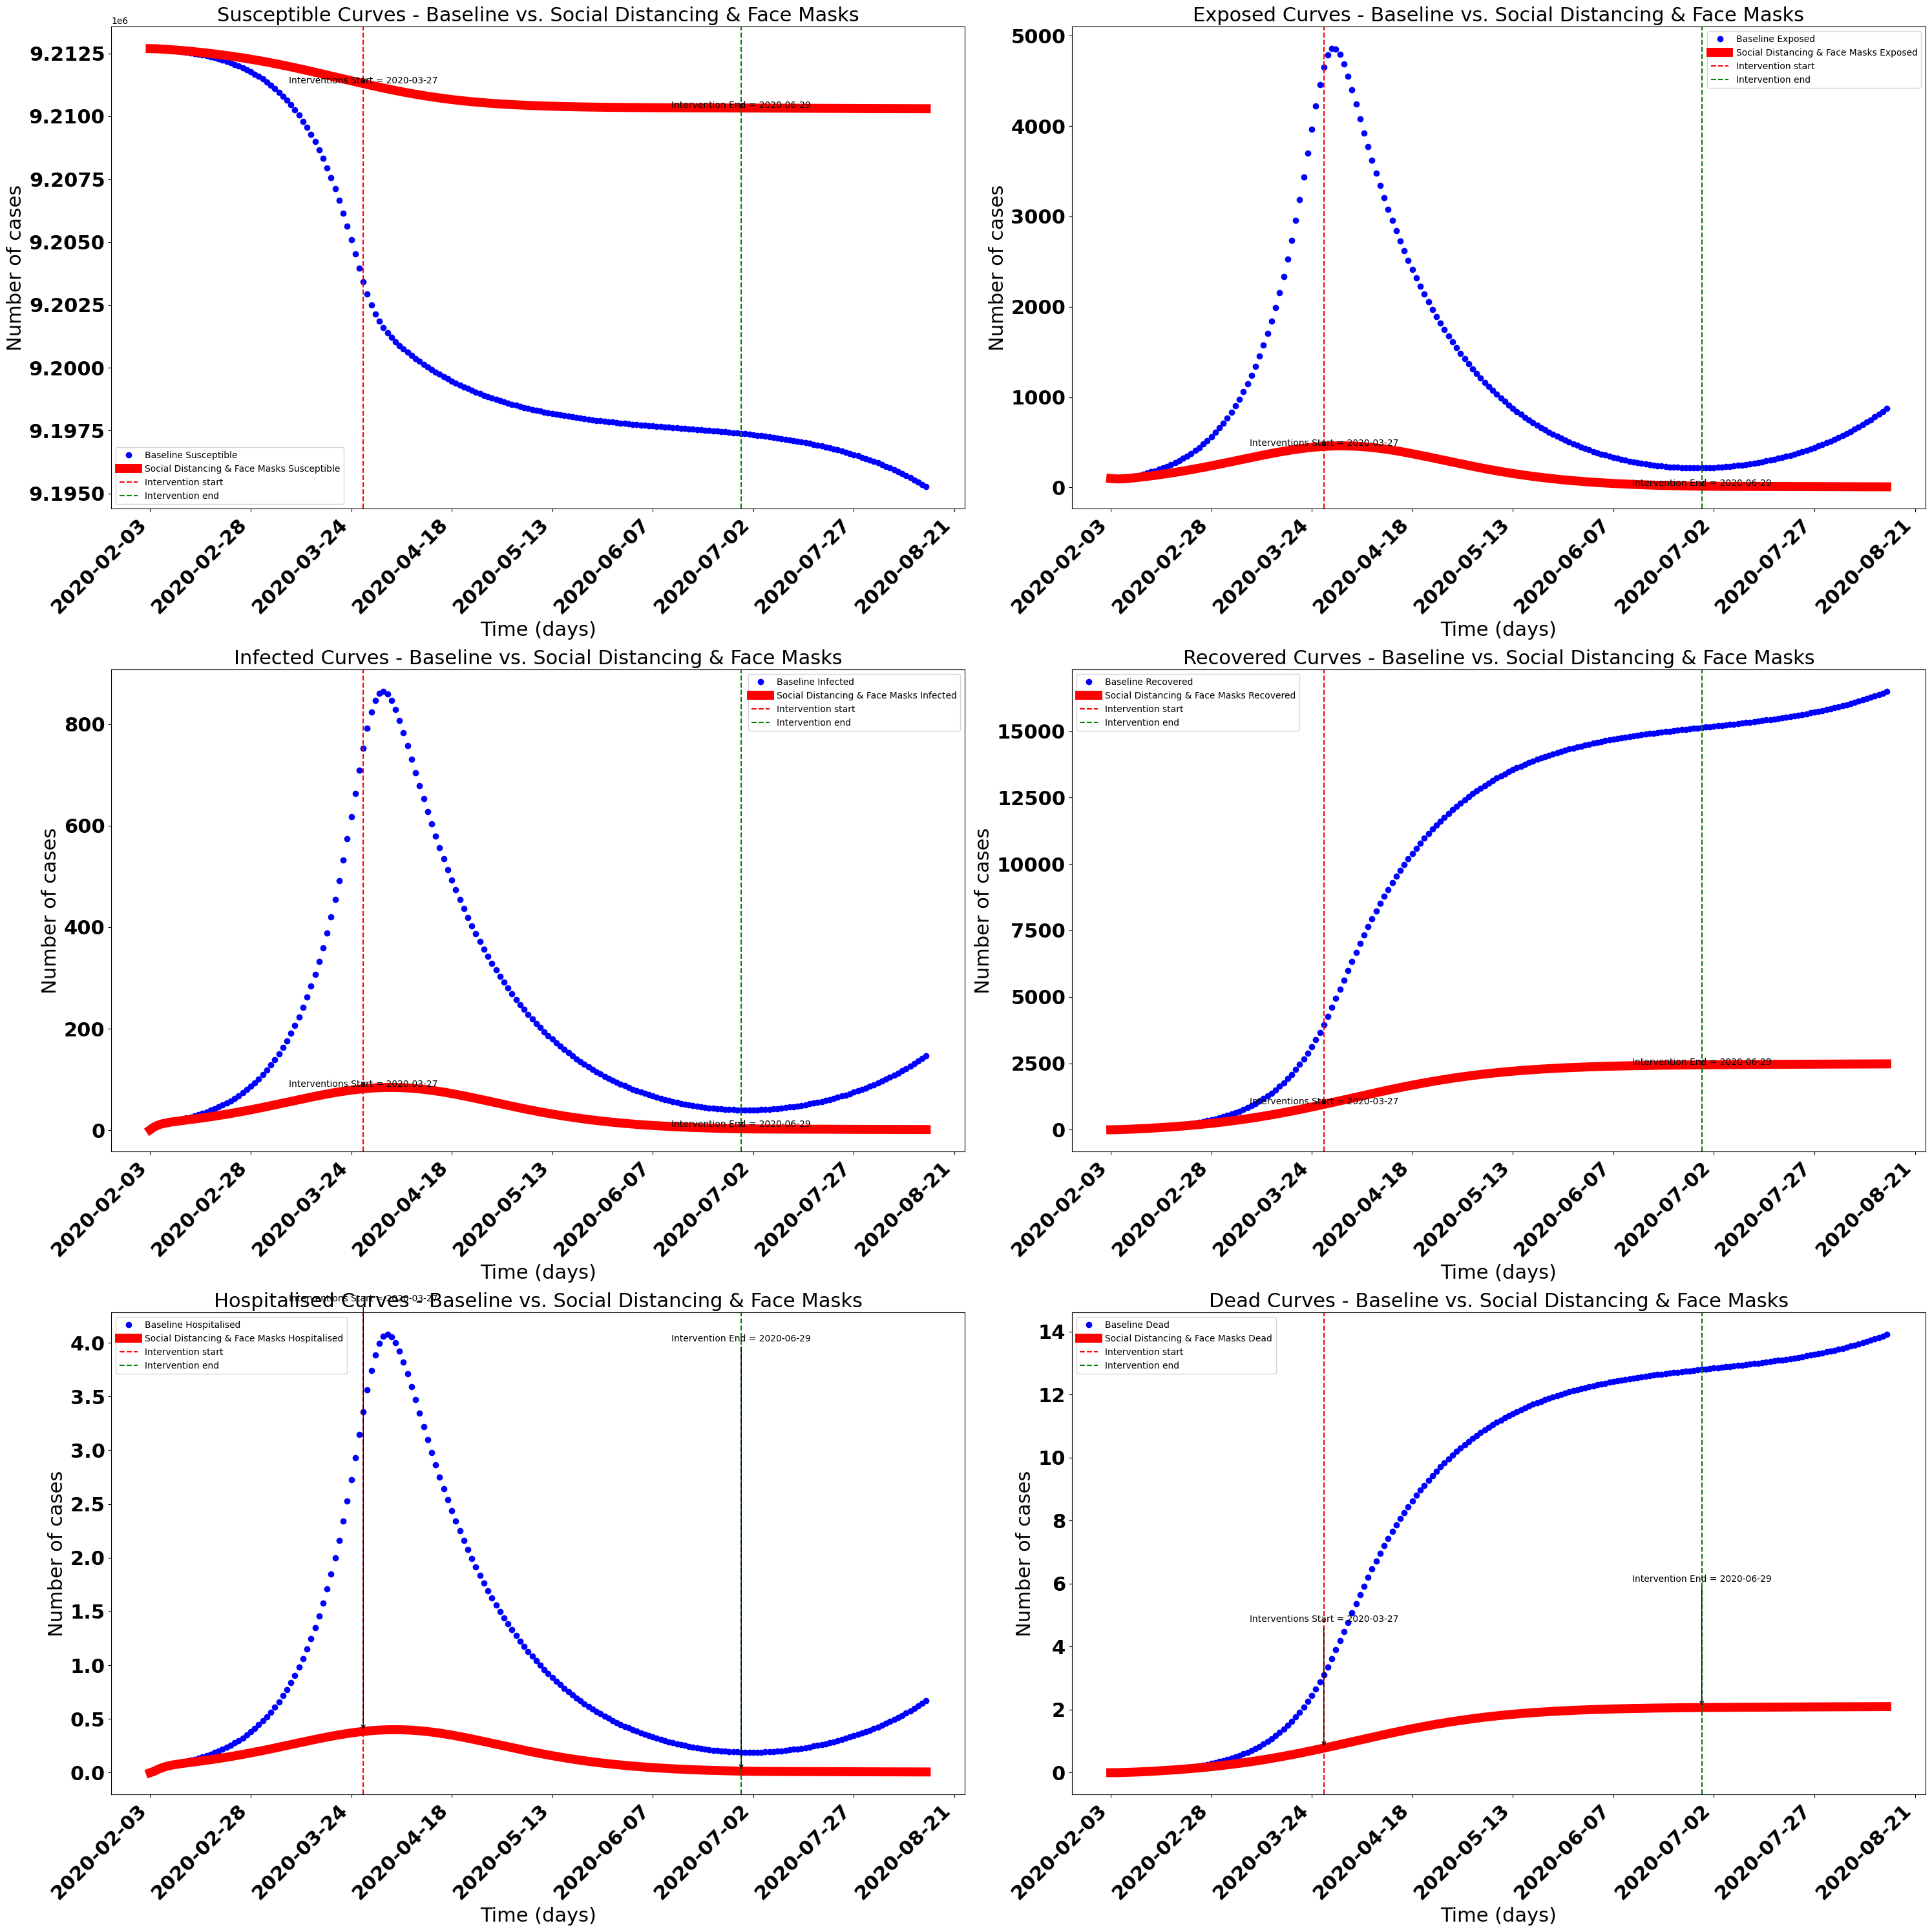

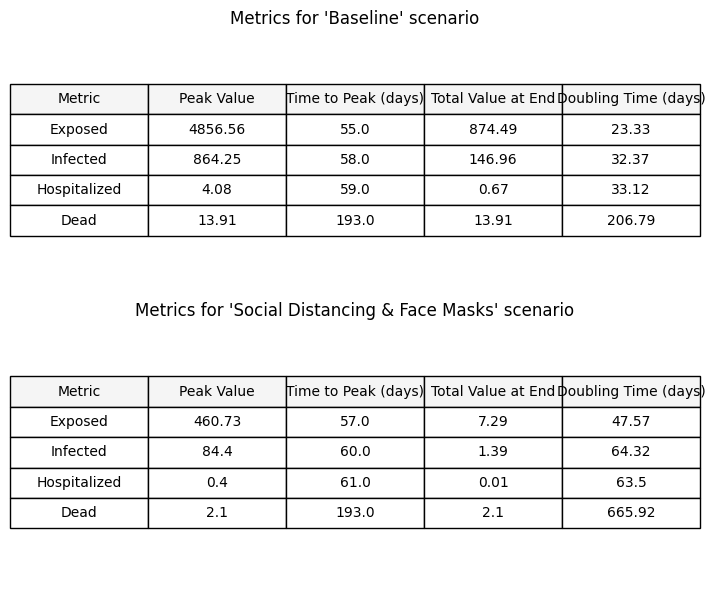

In [208]:
params_strict_social_distancing_masks_mandates= params_baseline.copy()
params_strict_social_distancing_masks_mandates['beta_lockdown'] = 0.10
params_strict_social_distancing_masks_mandates['beta_end'] = 0.40
params_strict_social_distancing_masks_mandates['k1'] = 0.05
params_strict_social_distancing_masks_mandates['k2'] = 0.55
params_strict_social_distancing_masks_mandates['alpha'] = 0.8


fn_plot_Baseline_VS_Scenarios(res["actual_interventions"], xdata_stage1, y0, params_strict_social_distancing_masks_mandates, 'Social Distancing & Face Masks', 'linear')

## 9.8. Reducing spatial mobility

In [210]:
od_matrix_normalized_weekly= od_matrix_normalized_weekly_backup.copy()

In [211]:
od_matrix_normalized_weekly_backup = od_matrix_normalized_weekly.copy()

In [212]:
grids_to_restrict = [4,5,9,10,13,14]

for i in range(od_matrix_normalized_weekly.shape[0]):
  for grid in grids_to_restrict:
    for columnIdx in range(od_matrix_normalized_weekly.shape[1]):
      od_matrix_normalized_weekly[i][grid][columnIdx] = 0
      od_matrix_normalized_weekly[i][columnIdx][grid] = 0

od_matrix_normalized_weekly

array([[[0.        , 0.00027462, 0.02514247, ..., 0.12826132,
         0.        , 0.        ],
        [0.0002756 , 0.        , 0.02495695, ..., 0.12844525,
         0.        , 0.        ],
        [0.0347808 , 0.0344009 , 0.        , ..., 0.14264931,
         0.        , 0.        ],
        ...,
        [0.12100023, 0.12074115, 0.09728112, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.00027462, 0.02514247, ..., 0.12826132,
         0.        , 0.        ],
        [0.0002756 , 0.        , 0.02495695, ..., 0.12844525,
         0.        , 0.        ],
        [0.0347808 , 0.0344009 , 0.        , ..., 0.14264931,
         0.        , 0.        ],
        ...,
        [0.12100023, 0.12074115, 0.09728112, ..., 0.        ,
         0.        , 0.        ],
        [0. 

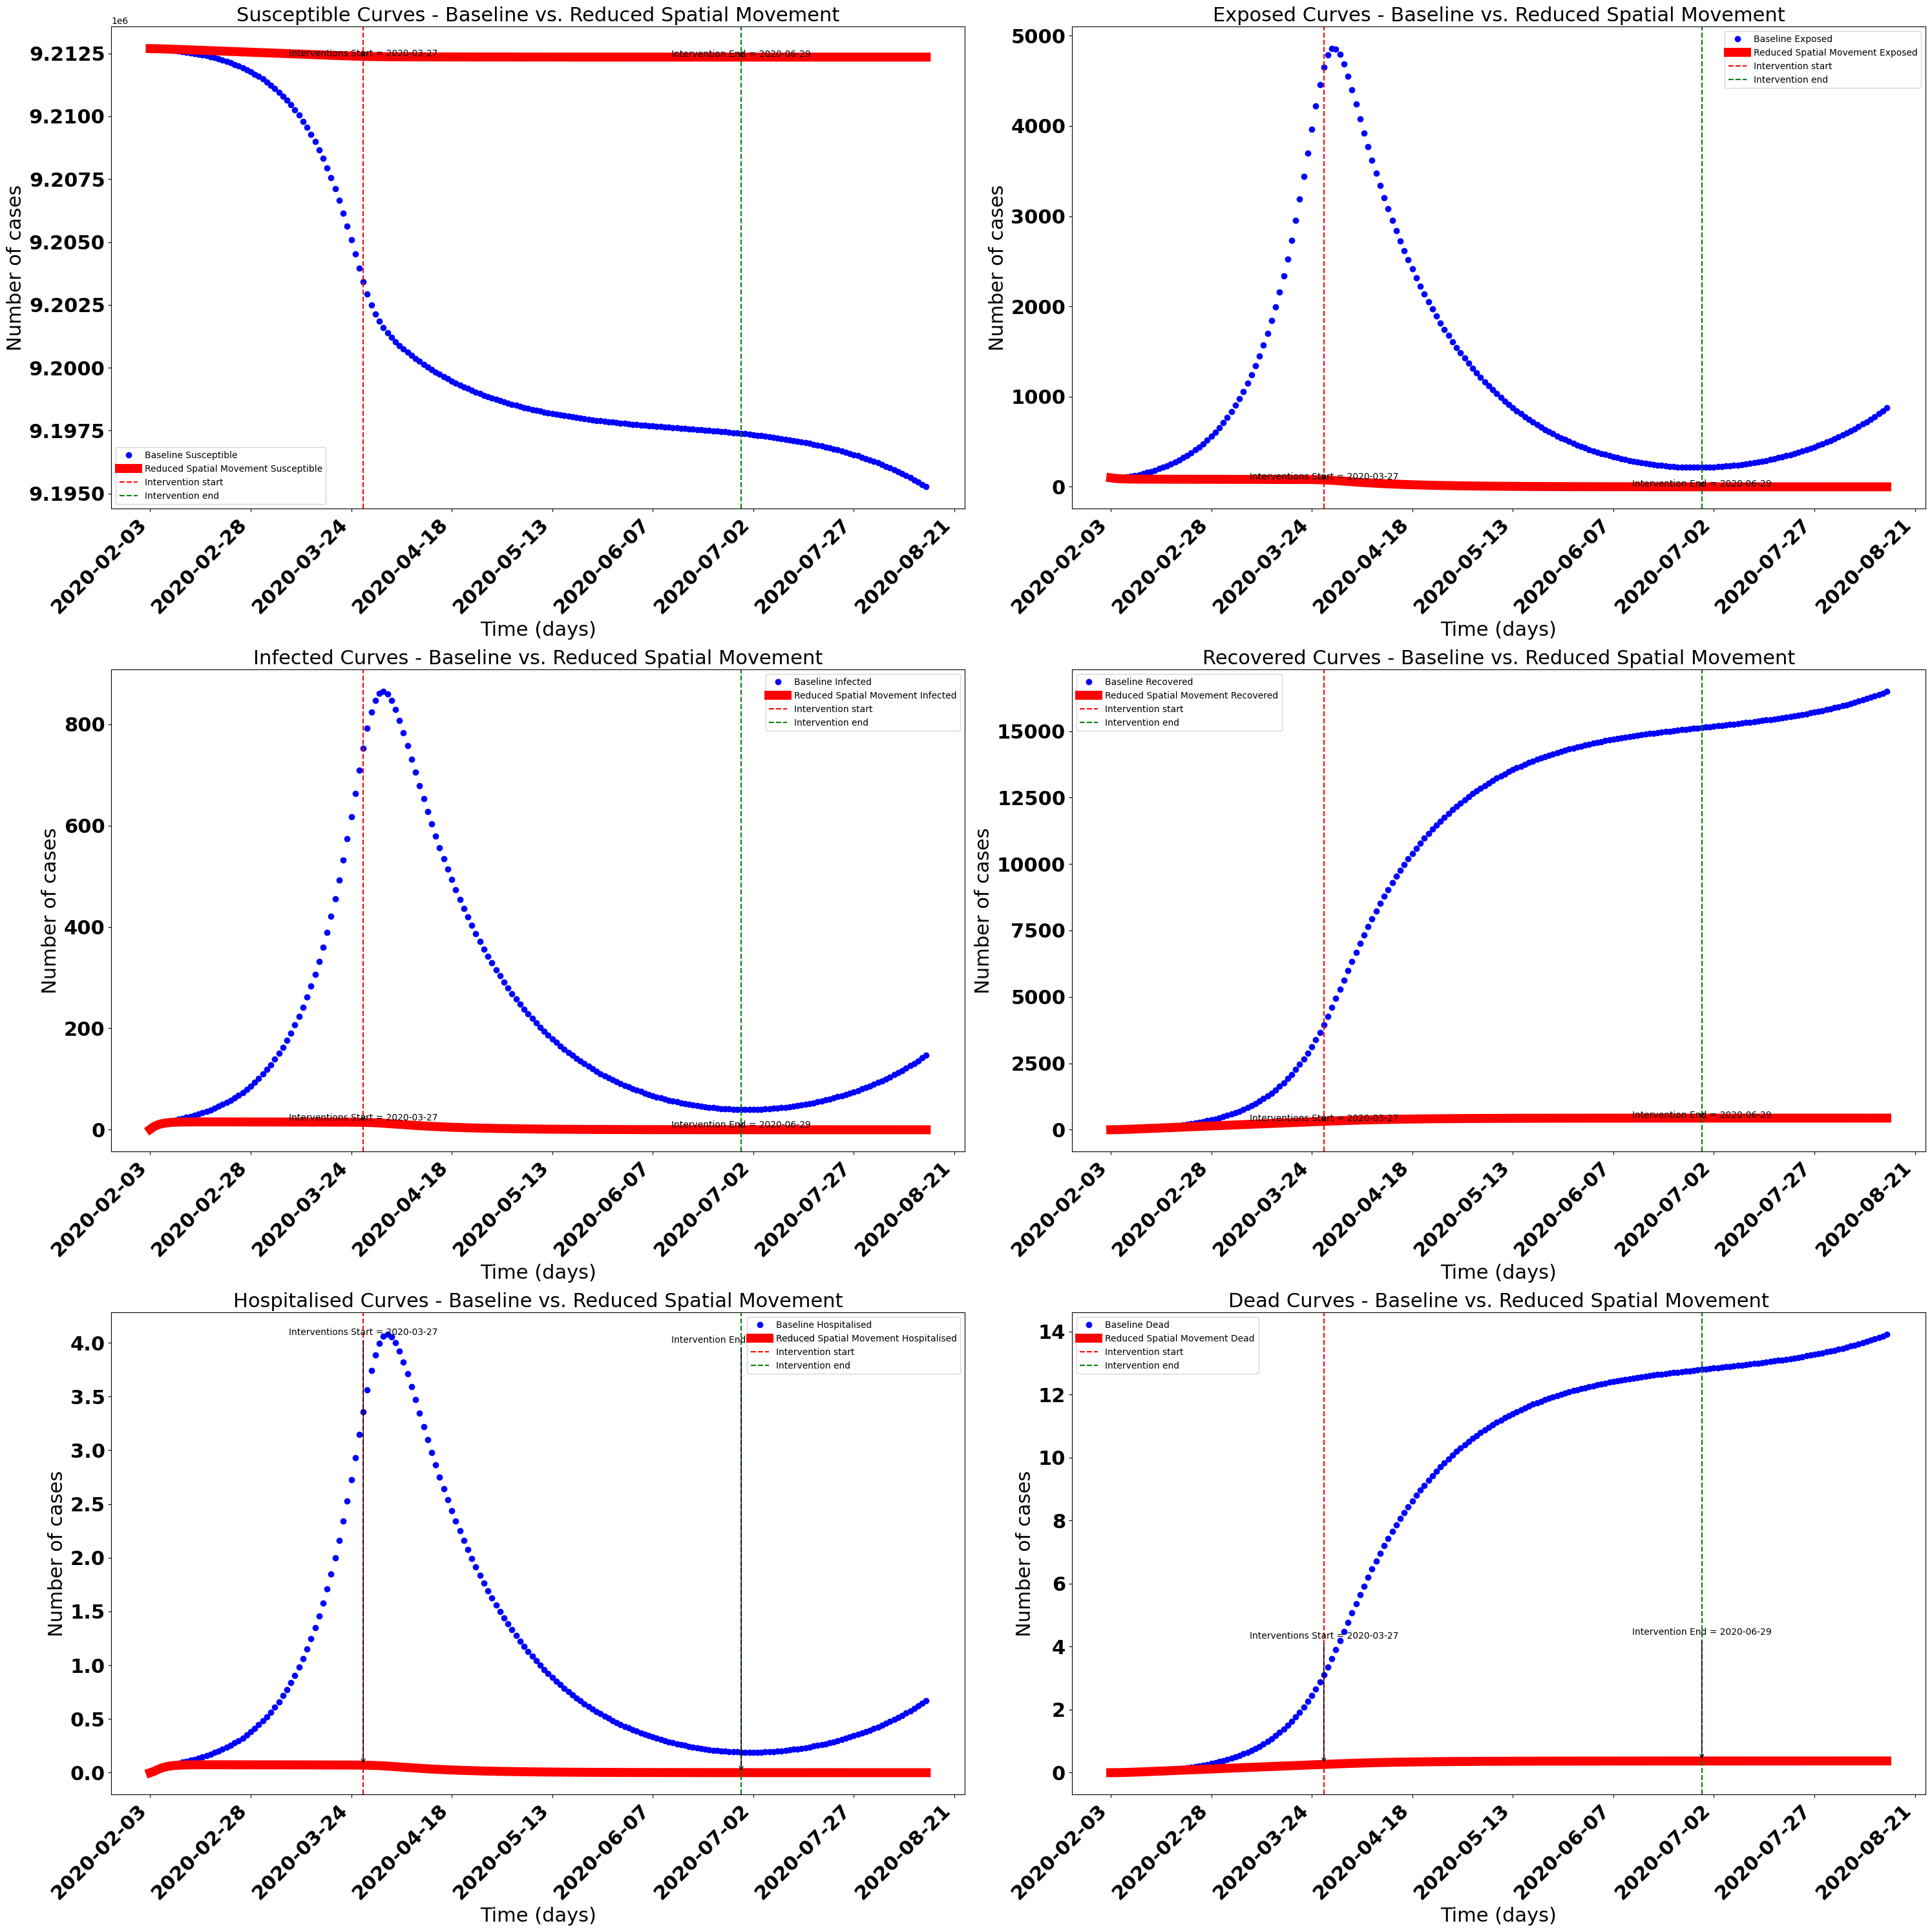

<ipython-input-200-760ec1560605>:18: RuntimeWarning: Mean of empty slice
  return round(np.nanmean(doubling_times),2)


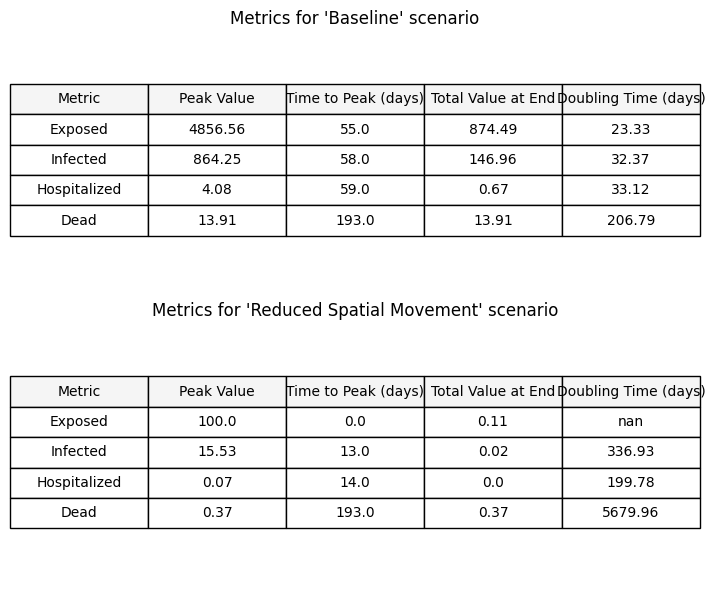

In [213]:
params_restricted_spatial_movement = params_baseline.copy()
params_restricted_spatial_movement['rho'] = 0.4
params_restricted_spatial_movement['alpha'] = 0.4


fn_plot_Baseline_VS_Scenarios(res["actual_interventions"], xdata_stage1, y0, params_restricted_spatial_movement, 'Reduced Spatial Movement', 'linear')

## 9.9 Strict Contact Tracing, Quarantine and Isolation of Infected Individuals

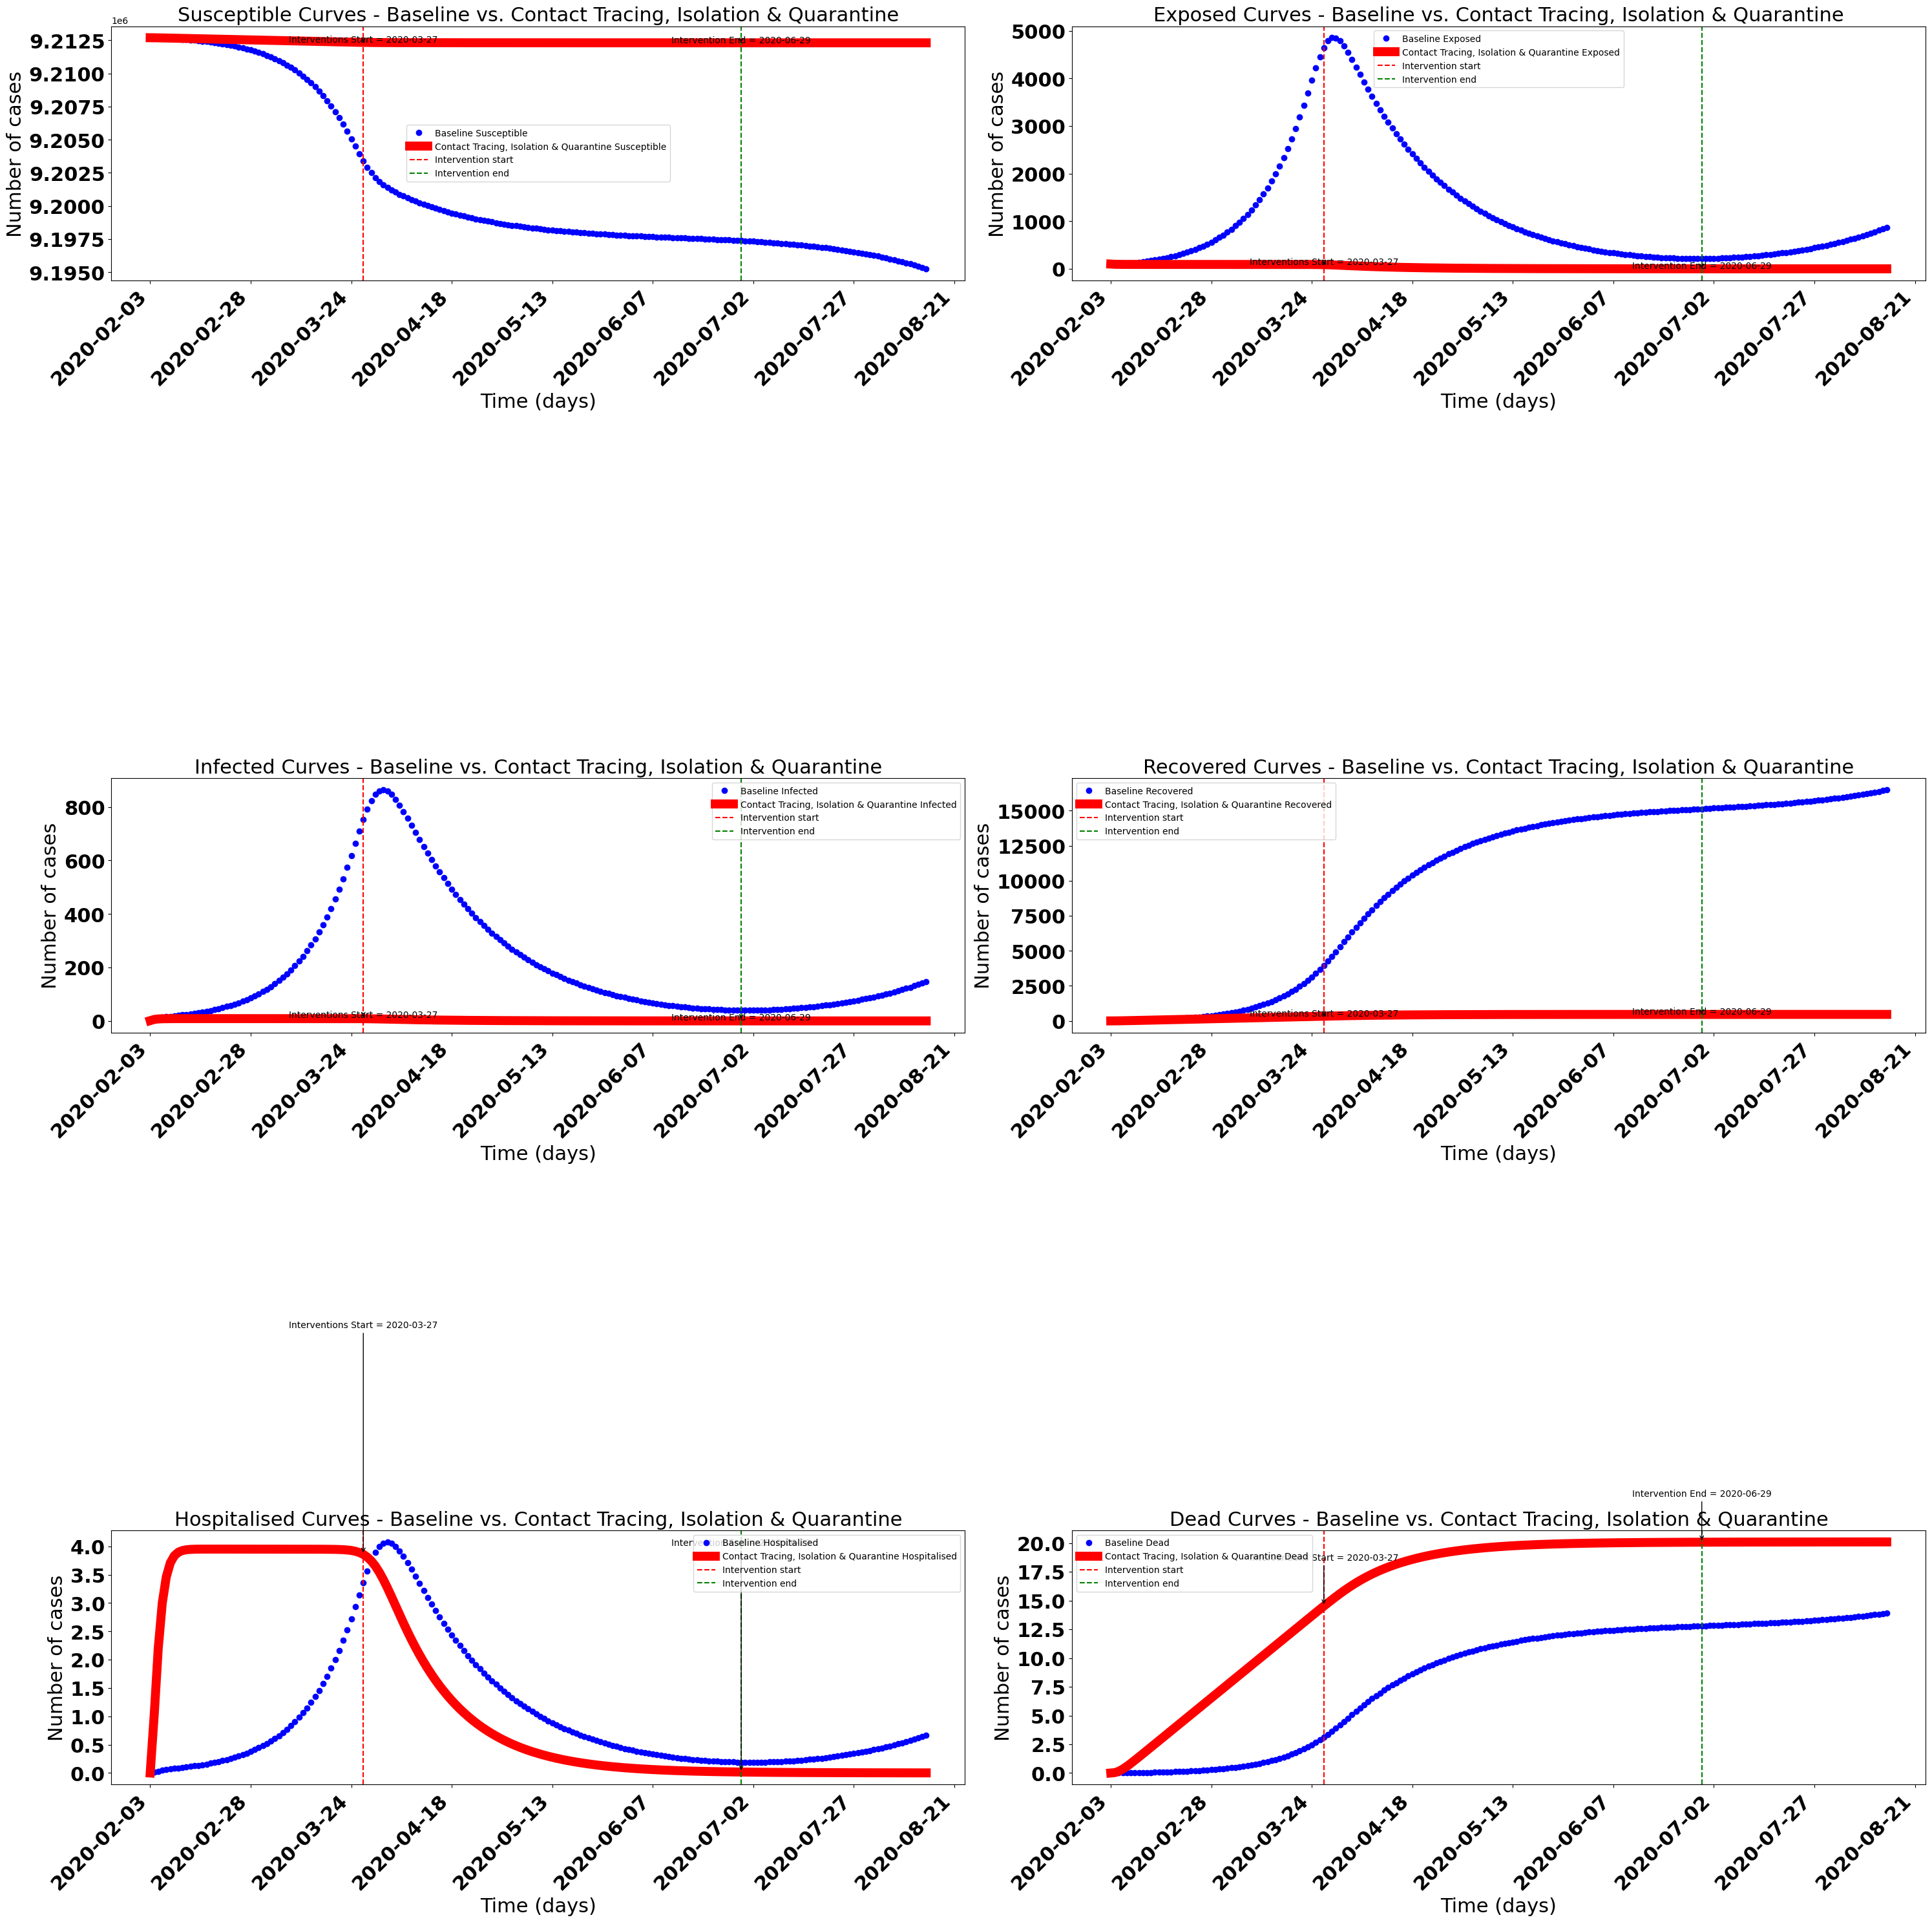

<ipython-input-200-760ec1560605>:18: RuntimeWarning: Mean of empty slice
  return round(np.nanmean(doubling_times),2)


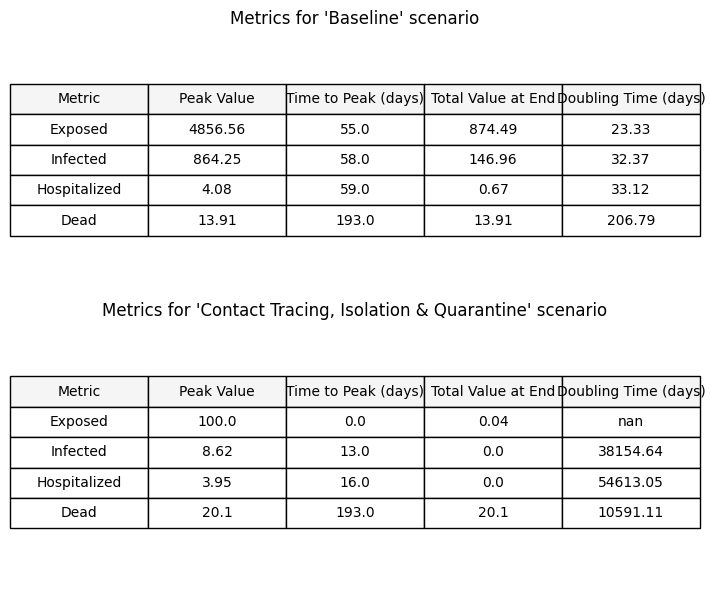

In [209]:
params_strict_contact_tracing = params_baseline.copy()
params_strict_contact_tracing['beta_end'] = 0.40
params_strict_contact_tracing['alpha'] = 0.8
params_strict_contact_tracing['gamma'] = 0.8
params_strict_contact_tracing['delta'] = 0.8
params_strict_contact_tracing['r_I_to_H'] = 0.5
params_strict_contact_tracing['gamma_H'] = 0.8


fn_plot_Baseline_VS_Scenarios(res["actual_interventions"], xdata_stage1, y0, params_strict_contact_tracing, 'Contact Tracing, Isolation & Quarantine', 'linear')

# References:

**[1]**: Gridded Population of the World v4 (https://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-count-rev11)